# Week HW 26

# Import


In [1433]:
import gurobipy as gp
from gurobipy import GRB
import gurobipy_pandas as gppd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gurobipy import min_, max_
from scipy.stats import multivariate_normal, norm
import pickle
import os
import glob
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from datetime import datetime
import matplotlib.pyplot as plt
import itertools
import math

params = {
    "WLSACCESSID": "73a6e3bf-2a9d-41e8-85eb-dd9b9eda802b",
    "WLSSECRET": "c394298a-96ea-4c8c-9d5e-ef2bd5032427",
    "LICENSEID": 2563044,
}

env = gp.Env(params=params)
model = gp.Model(env=env)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2563044
Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw


# Settings


In [1434]:
import numpy as np
from datetime import datetime

#####################

salvage_value = 0
cost = 400
price = 1000
holding_cost = 0

model_prefix = f"med_with_holding_cost_{holding_cost}"

#####################

CHUNK_SIZE = 30
data_size = CHUNK_SIZE * 3
train_size = 0.5
testing_size = 0.5

T = 10
service_level = 0.95  # 服務水準
M = 5000000
LASSO_BETA = 100
LASSO_ALPHA = 0.1
LASSO_BETA_SECOND_TRAIN = 0.9


ASSIGNED_FS = np.arange(0.1, 1.0, 0.1)
ASSIGNED_TS = list(range(2, T))  # 2 到 T-1

np.random.seed(0)

# Gurobi Model Constants
THREADS = 12
TIME_LIMIT = 20000
MIPGAP = 0.01
CURRENT_TIMESTAMP = int(datetime.now().strftime("%Y%m%d%H%M"))

# Utils


## Models' Parameters

In [1435]:
def save_model_parameters(
    name: str,
    alpha_values=None,
    beta_values=None,
    f_values=None,
    tau_values=None,
    data_size=data_size,
    current_timestamp=CURRENT_TIMESTAMP,
):
    os.makedirs("models", exist_ok=True)

    params = {}
    if alpha_values is not None:
        params["alpha"] = alpha_values
    if beta_values is not None:
        params["beta"] = beta_values
    if f_values is not None:
        params["f_values"] = f_values
    if tau_values is not None:
        params["tau_values"] = tau_values

    # 如果有參數才進行保存
    if params:
        with open(f"models/{name}_{data_size}_{current_timestamp}.pkl", "wb") as f:
            pickle.dump(params, f)
        print(
            f"Model parameters saved as models/{name}_{data_size}_{current_timestamp}.pkl"
        )
    else:
        print("No parameters provided to save.")

In [1436]:
def delete_model_parameters(name: str, data_size: int):
    # 構建檔案的路徑
    file_path = f"models/{name}_{data_size}_{CURRENT_TIMESTAMP}.pkl"

    # 檢查檔案是否存在
    if os.path.exists(file_path):
        os.remove(file_path)
        print(f"Model parameters file '{file_path}' has been deleted.")
    else:
        print(f"File '{file_path}' does not exist.")

In [1437]:
def show_models(model_prefix):
    file_paths = sorted(glob.glob(f"models/{model_prefix}_*.pkl"))

    # 逐一讀取並打印每個檔案的內容
    for file_path in file_paths:
        with open(file_path, "rb") as f:
            params = pickle.load(f)
            print(f"Contents of {file_path}:")
            print(params)
            print()  # 空行分隔每個檔案的內容

In [1438]:
# show_models("linear_constraint_med_with_holding_cost")

In [1439]:
# show_models("med_with_holding_cost")

## Visualization 

In [1440]:
def plot_strategies_profits_scatter(save_type, dfs: dict):
    names = list(dfs.keys())
    df_list = [dfs[name] for name in names]

    if len(df_list) <= 1:
        print("No dataframes to plot.")
        return

    pairs = list(itertools.combinations(range(len(df_list)), 2))
    num_pairs = len(pairs)
    grid_size = math.ceil(math.sqrt(num_pairs))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    fig.suptitle("Scatter Plots of Profits (Matrix View)")

    for idx, (i, j) in enumerate(pairs):
        row, col = divmod(idx, grid_size)
        df_i, df_j = df_list[i], df_list[j]

        if df_i is None or df_j is None or df_i.empty or df_j.empty:
            continue
        if len(df_i) != len(df_j):
            continue

        ax = axes[row, col]
        ax.scatter(df_i["profits"], df_j["profits"], alpha=0.6)
        ax.plot(
            [
                min(df_i["profits"].min(), df_j["profits"].min()),
                max(df_i["profits"].max(), df_j["profits"].max()),
            ],
            [
                min(df_i["profits"].min(), df_j["profits"].min()),
                max(df_i["profits"].max(), df_j["profits"].max()),
            ],
            "k--",
            linewidth=1,
        )
        ax.set_xlabel(names[i])
        ax.set_ylabel(names[j])
        ax.set_title(f"{names[i]} vs {names[j]}")

    # Remove empty subplots
    for idx in range(num_pairs, grid_size * grid_size):
        row, col = divmod(idx, grid_size)
        fig.delaxes(axes[row, col])

    plt.tight_layout(rect=[0, 0, 1, 0.95])

    os.makedirs("plots", exist_ok=True)
    save_path = f"plots/plot_strategies_profits_scatter_{save_type}.png"
    plt.savefig(save_path, bbox_inches="tight")
    print(f"Plot saved as {save_path}")

    plt.show()
    plt.close()

In [1441]:
def plot_relative_profit_deviation(save_type, baseline_profit, max_profits):
    """
    繪製多個策略相對於基準的平均利潤偏差。

    :param baseline_profit: 基準利潤值
    :param max_profits: 各策略的最大利潤列表，包含 None 值或 -1 表示無效數據
    """
    print(f"Baseline is: {baseline_profit}")
    for i, profit in enumerate(max_profits):
        print(f"S{i+1}'s profit: {profit}")

    # 計算相對值
    ratios = {}
    for idx, max_profit in enumerate(max_profits, start=1):
        if max_profit is not None and max_profit != -1:
            if baseline_profit != 0:
                ratio = (max_profit - baseline_profit) / abs(baseline_profit)
                ratios[f"S{idx}"] = ratio
            else:
                # 基準利潤為零時，直接記錄增量
                ratio = max_profit
                ratios[f"S{idx}"] = ratio

    # 設置 y 軸範圍
    if ratios:
        y_min = min(ratios.values()) - 0.1
        y_max = max(ratios.values()) + 0.1
    else:
        y_min, y_max = -0.1, 0.1

    # 創建圖表顯示結果
    plt.figure(figsize=(12, 8))

    if ratios:
        bars = plt.bar(
            ratios.keys(), ratios.values(), color=plt.cm.tab10(range(len(ratios)))
        )

        # 在每個柱狀圖上標出數值
        for bar in bars:
            yval = bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                yval,
                f"{yval:.4f}",
                ha="center",
                va="bottom",
            )

    # 添加基準線，表示基準值（No Opt）
    plt.axhline(y=0, color="gray", linestyle="--", label="Baseline (No Opt)")

    # 設置圖表標題和軸標籤
    plt.title("Relative Avg Profit Deviation from Baseline (1)")
    plt.xlabel("Strategies")
    plt.ylabel("Deviation from Baseline (1)")
    plt.ylim(y_min, y_max)
    plt.legend()

    name = "plot_relative_profit_deviation"

    os.makedirs("plots", exist_ok=True)
    save_path = f"plots/{name}_{save_type}_{data_size}_{CURRENT_TIMESTAMP}.png"

    plt.savefig(save_path, format="png", bbox_inches="tight")
    print(f"Plot saved as {save_path}")

    # Show plot
    plt.show()
    plt.close()

In [1442]:
def plot_relative_profit_comparison(
    save_type,
    train_baseline_profit,
    test_baseline_profit,
    test_max_profits,
    train_max_profits,
):

    # Calculate relative deviations from baseline for test and train data
    test_ratios, train_ratios = {}, {}
    for idx, (test_profit, train_profit) in enumerate(
        zip(test_max_profits, train_max_profits), start=1
    ):
        if test_profit is not None and test_profit != -1:
            if test_baseline_profit != 0:
                test_ratio = (test_profit - test_baseline_profit) / abs(
                    test_baseline_profit
                )  # Relative deviation
            else:
                test_ratio = test_profit  # Use profit directly if baseline is zero
            test_ratios[f"S{idx}"] = test_ratio

        if train_profit is not None and train_profit != -1:
            if train_baseline_profit != 0:
                train_ratio = (train_profit - train_baseline_profit) / abs(
                    train_baseline_profit
                )  # Relative deviation
            else:
                train_ratio = train_profit  # Use profit directly if baseline is zero
            train_ratios[f"S{idx}"] = train_ratio

    # Define the fixed range of the y-axis
    max_value = max(
        max(test_ratios.values(), default=0), max(train_ratios.values(), default=0)
    )
    y_max = min(max_value + 0.1, 1.0)  # Limit max y to 1.0
    y_min = -y_max  # Keep symmetric scaling

    # Ensure y-axis tick marks are at intervals of 0.05
    y_ticks = np.arange(y_min, y_max + 0.05, 0.05)  # Generate ticks

    # Create bar plot for relative profit deviation comparison
    plt.figure(figsize=(14, 8))
    bar_width = 0.35
    indices = np.arange(len(train_ratios))

    # Plot bars for train and test ratios, with train on the left for each pair
    train_bars = plt.bar(
        indices - bar_width / 2,
        train_ratios.values(),
        bar_width,
        label="Train Data",
        color="salmon",
    )
    test_bars = plt.bar(
        indices + bar_width / 2,
        test_ratios.values(),
        bar_width,
        label="Test Data",
        color="skyblue",
    )

    # Add baseline line
    plt.axhline(y=0, color="gray", linestyle="--", label="Baseline (No Opt)")

    # Add labels for each bar
    for bar in train_bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            f"{yval:.2f}",
            ha="center",
            va="bottom",
        )
    for bar in test_bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            f"{yval:.2f}",
            ha="center",
            va="bottom",
        )

    # Set plot labels and title
    plt.xlabel("Strategies")
    plt.ylabel("Deviation from Baseline")
    plt.title("Relative Profit Deviation Comparison between Train and Test Data")
    plt.xticks(indices, train_ratios.keys())

    # Set fixed y-axis range and ticks
    plt.ylim(y_min, y_max)
    plt.yticks(y_ticks)  # Apply fixed 0.05 intervals

    plt.legend()

    name = "plot_relative_profit_comparison"

    os.makedirs("plots", exist_ok=True)
    save_path = f"plots/{name}_{save_type}.png"

    plt.savefig(save_path, format="png", bbox_inches="tight")
    print(f"Plot saved as {save_path}")

    # Show plot
    plt.show()
    plt.close()

In [1443]:
def plot_Q0_Q1_distribution(save_type, stimulation_results_dfs):

    for idx, df in enumerate(stimulation_results_dfs, start=1):
        if df is None or len(df) == 0:
            continue

        df["Q0"] = pd.to_numeric(df["Q0"], errors="coerce")
        df["Q1"] = pd.to_numeric(df["Q1"], errors="coerce")
        df.dropna(subset=["Q0", "Q1"], inplace=True)

        plt.figure(figsize=(10, 6))
        plt.hist(df["Q0"], bins=20, alpha=0.6, label="Q0", edgecolor="black")
        plt.hist(df["Q1"], bins=20, alpha=0.6, label="Q1", edgecolor="black")
        plt.title(f"Histogram of Q0 and Q1 for stimulation_results_df_{idx}")
        plt.xlabel("Value")
        plt.ylabel("Count")
        plt.legend()
        plt.grid(True)

        name = "plot_Q0_Q1_distribution"

        os.makedirs("plots", exist_ok=True)
        save_path = (
            f"plots/{name}_{save_type}_{data_size}_S{idx}_{CURRENT_TIMESTAMP}.png"
        )

        plt.savefig(save_path, format="png", bbox_inches="tight")
        print(f"Plot saved as {save_path}")

        plt.show()

In [1444]:
import seaborn as sns


def plot_profits_deviation_box_plot(
    save_type, stimulation_results_dfs, baseline_avg_profits
):

    for idx, df in enumerate(stimulation_results_dfs, start=1):
        if df is not None and "profits" in df.columns:
            df["profits"] = pd.to_numeric(df["profits"], errors="coerce")
            df.dropna(subset=["profits"], inplace=True)

            # Calculate deviation
            df["Deviation"] = df["profits"] - baseline_avg_profits

            # Plot deviation as a boxplot
            plt.figure(figsize=(8, 6))
            sns.boxplot(y=df["Deviation"])
            plt.axhline(0, color="red", linestyle="--", label="Baseline")
            plt.title(
                f"Boxplot of Deviation of Profits from Baseline for stimulation_results_df_{idx}"
            )
            plt.ylabel("Deviation")
            plt.legend()
            plt.grid(True, axis="y")

            name = "plot_profits_deviation_box_plot"

            os.makedirs("plots", exist_ok=True)
            save_path = (
                f"plots/{name}_{save_type}_{data_size}_S{idx}_{CURRENT_TIMESTAMP}.png"
            )

            plt.savefig(save_path, format="png", bbox_inches="tight")
            print(f"Plot saved as {save_path}")

            plt.show()
        else:
            print(f"Skipping stimulation_results_df_{idx}: Missing 'profits' column.")

## Others

In [1445]:
# 線性模型預測公式
def compute_f_F_Q(X_data, alphas, Q_star):
    f = sum(X_data[j] * alphas[j] for j in range(len(alphas)))
    big_f = 1 / (1 + np.exp(-f))
    q0 = big_f * Q_star
    print(f"f_vars[i]: {f:.4f}, F_vars[i]: {big_f:.4f}, Q0_vars[i]: {q0:.4f}")
    return f, big_f, q0

In [1446]:
import math


def truncate_to_2(x):
    return math.floor(x * 100) / 100

In [1447]:
# Function to replace negative values with 0
def replace_negative_with_zero(df):
    return df.applymap(lambda x: max(x, 0))

In [1448]:
def check_values(
    Q1_vars,
    Q_hat_adjusteds,
    Q0_vars,
    Sold_0s,
    total_demand_up_to_k_minus_1_vars,
    Sold_1s,
    total_demand_from_k_to_T_vars,
    Q1_plus_lefts,
    Left_0s,
    Lost_0s,
    Left_1s,
    Lost_1s,
):

    # 用於存儲每個條件的統計結果
    results = {
        "Condition": [],
        "Average_Error_Percentage": [],
        "Max_Error_Percentage": [],
        "Min_Error_Percentage": [],
        "Max_Error": [],
        "Min_Error": [],
    }

    # 定義存儲每個條件下的誤差和誤差百分比
    conditions_errors = {
        "Q1_vars": [],
        "Sold_0s": [],
        "Sold_1s": [],
        "Left_0s": [],
        "Left_1s": [],
        "Lost_0s": [],
        "Lost_1s": [],
    }

    # 存儲每個條件下的誤差百分比
    conditions_error_percentage = {
        "Q1_vars": [],
        "Sold_0s": [],
        "Sold_1s": [],
        "Left_0s": [],
        "Left_1s": [],
        "Lost_0s": [],
        "Lost_1s": [],
    }

    # 遍歷每一個變量集合
    for i in range(len(Q1_vars)):
        # 提取變量的值
        Q1 = Q1_vars[i].X
        Q_hat_adjusted = Q_hat_adjusteds[i].X
        Q0 = Q0_vars[i].X
        Sold_0 = Sold_0s[i].X
        total_demand_up_to_k_minus_1 = total_demand_up_to_k_minus_1_vars[i].X
        Sold_1 = Sold_1s[i].X
        total_demand_from_k_to_T = total_demand_from_k_to_T_vars[i].X
        Q1_plus_left = Q1_plus_lefts[i].X
        Left_0 = Left_0s[i].X
        Lost_0 = Lost_0s[i].X
        Left_1 = Left_1s[i].X
        Lost_1 = Lost_1s[i].X

        # 計算理論值
        theoretical_sold_0 = min(total_demand_up_to_k_minus_1, Q0)
        theoretical_left_0 = max(Q0 - theoretical_sold_0, 0)
        theoretical_Q1_plus_left = Q1 + theoretical_left_0  # Q1_plus_left 的理論值
        theoretical_sold_1 = min(total_demand_from_k_to_T, theoretical_Q1_plus_left)
        theoretical_left_1 = max(theoretical_Q1_plus_left - theoretical_sold_1, 0)
        theoretical_lost_0 = max(total_demand_up_to_k_minus_1 - Q0, 0)
        theoretical_lost_1 = max(total_demand_from_k_to_T - theoretical_Q1_plus_left, 0)

        # 檢查條件 2：Sold_0 一定等於理論值
        if not (Sold_0 == theoretical_sold_0):
            error = abs(Sold_0 - theoretical_sold_0)
            conditions_errors["Sold_0s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Sold_0s"].append(
                (error / theoretical_sold_0) * 100 if theoretical_sold_0 != 0 else 0
            )

        # 檢查條件 3：Sold_1 一定等於理論值
        if not (Sold_1 == theoretical_sold_1):
            error = abs(Sold_1 - theoretical_sold_1)
            conditions_errors["Sold_1s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Sold_1s"].append(
                (error / theoretical_sold_1) * 100 if theoretical_sold_1 != 0 else 0
            )

        # 檢查條件 4：Left_0 一定等於理論值
        if not (Left_0 == theoretical_left_0):
            error = abs(Left_0 - theoretical_left_0)
            conditions_errors["Left_0s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Left_0s"].append(
                (error / theoretical_left_0) * 100 if theoretical_left_0 != 0 else 0
            )

        # 檢查條件 5：Left_1 一定等於理論值
        if not (Left_1 == theoretical_left_1):
            error = abs(Left_1 - theoretical_left_1)
            conditions_errors["Left_1s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Left_1s"].append(
                (error / theoretical_left_1) * 100 if theoretical_left_1 != 0 else 0
            )

        # 檢查條件 6：Lost_0 一定等於理論值
        if not (Lost_0 == theoretical_lost_0):
            error = abs(Lost_0 - theoretical_lost_0)
            conditions_errors["Lost_0s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Lost_0s"].append(
                (error / theoretical_lost_0) * 100 if theoretical_lost_0 != 0 else 0
            )

        # 檢查條件 7：Lost_1 一定等於理論值
        if not (Lost_1 == theoretical_lost_1):
            error = abs(Lost_1 - theoretical_lost_1)
            conditions_errors["Lost_1s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Lost_1s"].append(
                (error / theoretical_lost_1) * 100 if theoretical_lost_1 != 0 else 0
            )

    # 計算每個條件的統計結果
    for condition, errors in conditions_errors.items():
        error_percentages = conditions_error_percentage[condition]
        if errors:
            # 統計數據，並將所有數值四捨五入至小數點后三位
            avg_error_percentage = (
                round(sum(error_percentages) / len(error_percentages), 3)
                if error_percentages
                else 0.0
            )
            max_error_percentage = (
                round(max(error_percentages), 3) if error_percentages else 0.0
            )
            min_error_percentage = (
                round(min(error_percentages), 3) if error_percentages else 0.0
            )
            max_error = round(max(errors), 3) if errors else 0.0
            min_error = round(min(errors), 3) if errors else 0.0

            # 存儲結果
            results["Condition"].append(condition)
            results["Average_Error_Percentage"].append(avg_error_percentage)
            results["Max_Error_Percentage"].append(max_error_percentage)
            results["Min_Error_Percentage"].append(min_error_percentage)
            results["Max_Error"].append(max_error)
            results["Min_Error"].append(min_error)

    # 轉換為 DataFrame
    results_df = pd.DataFrame(results)
    return results_df

In [1449]:
# Calculate service level
def calculate_service_level(*, salvage_value, cost, price):

    cu = price - cost
    co = cost - salvage_value
    service_lv = cu / (co + cu)

    return service_lv

In [1450]:
calculate_service_level(salvage_value=salvage_value, cost=cost, price=price)

0.6

In [1451]:
def make_s3_related_strtegies_result(
    *,
    all_Rs,
    losses,
    lefts,
    profits,
    operation_profits,
    alpha_values,
    beta_values,
    F_vars,
    Q0_vars,
    Q1_vars,
    f_values,
    tau_values,
    holding_costs_0s,
    holding_costs_1s,
    all_left0s,
    all_left1s,
    all_lost0s,
    all_lost1s,
    gamma_values=None
):

    results_dict = {
        "average_profits": [sum(profits) / len(profits) if profits else 0],
        "average_losses": [sum(losses) / len(losses) if losses else 0],
        "average_lefts": [sum(lefts) / len(lefts) if lefts else 0],
        "average_operation_profits": [
            sum(operation_profits) / len(operation_profits) if operation_profits else 0
        ],
        "alpha_values": [alpha_values],
        "beta_values": [beta_values],
        "tau_values": [tau_values],
        "gamma_values": [gamma_values],
    }
    stimulations_result = {
        "R(T)": all_Rs,
        # "R": [x - 2 for x in all_Rs],
        "F": F_vars,
        "f_values": f_values,
        "profits": profits,
        "losses": losses,
        "lefts": lefts,
        "operation_profits": operation_profits,
        "Q0": Q0_vars,
        "Q1": Q1_vars,
        "hc0": holding_costs_0s,
        "hc1": holding_costs_1s,
        "Left0s": all_left0s,
        "Left1s": all_left1s,
        "lost0s": all_lost0s,
        "lost1s": all_lost1s,
    }

    return pd.DataFrame(results_dict).sort_values(
        by="average_profits", ascending=False
    ), pd.DataFrame(stimulations_result)

# Generate Data


## Data1: Training data for LR


### Making full data


In [1452]:
# np.random.seed(0)

# # full_df = pd.DataFrame(
# #     {
# #         "X1": np.zeros(data_size),
# #         "X2": np.zeros(data_size),
# #         "X3": np.zeros(data_size),
# #         "X4": np.random.uniform(5, 15, data_size),
# #     }
# # )

# full_df = pd.DataFrame(
#     {
#         "X1": np.zeros(data_size),
#         "X2": np.zeros(data_size),
#         "X3": np.zeros(data_size),  # 將作為轉折時間
#         # "X4": np.random.uniform(5, 15, data_size),
#     }
# )

# for i in range(0, data_size, CHUNK_SIZE):
#     half_chunk = CHUNK_SIZE // 2
#     # 訓練 (前 half_chunk)
#     full_df.loc[i : i + half_chunk - 1, "X1"] = np.random.uniform(
#         15, 20, size=half_chunk
#     )
#     full_df.loc[i : i + half_chunk - 1, "X2"] = 0
#     full_df.loc[i : i + half_chunk - 1, "X3"] = np.random.uniform(
#         250, 300, size=half_chunk
#     )

#     # 測試 (後 half_chunk)
#     full_df.loc[i + half_chunk : i + CHUNK_SIZE - 1, "X1"] = np.random.uniform(
#         15, 20, size=half_chunk
#     )
#     full_df.loc[i + half_chunk : i + CHUNK_SIZE - 1, "X2"] = 1
#     full_df.loc[i + half_chunk : i + CHUNK_SIZE - 1, "X3"] = np.random.uniform(
#         60, 70, size=half_chunk
#     )


# # # 初始化 X3
# # X3_values = np.zeros(data_size)

# # # 對每個 chunk 設定對應的 X3 範圍
# # for i in range(0, data_size, CHUNK_SIZE):
# #     half_chunk = CHUNK_SIZE // 2
# #     # 訓練資料 X3：200~250
# #     X3_values[i : i + half_chunk] = np.random.uniform(
# #         250, 300, size=min(half_chunk, data_size - i)
# #     )
# #     # 測試資料 X3：40~90
# #     X3_values[i + half_chunk : i + CHUNK_SIZE] = np.random.uniform(
# #         50, 100, size=min(half_chunk, data_size - i - half_chunk)
# #     )

# # # 填入 full_df
# # full_df["X3"] = X3_values
# full_df

In [1453]:
np.random.seed(0)

# 初始化 full_df，包含 X1, X2, X3, X4
# 其他變數 (例如 X4) 用 uniform 隨機數
full_df = pd.DataFrame(
    {
        "X1": np.zeros(data_size),
        "X2": np.zeros(data_size),
        "X3": np.zeros(data_size),  # 將作為轉折時間
        # "X4": np.random.uniform(5, 15, data_size),
    }
)

# # 根據 chunk，對第一半 (訓練) 設定 X1=1，對第二半 (測試) 設定 X2=1，
# # 並設定 X3 為轉折時間:
# #  訓練：X3 ~ Uniform(7, 9)
# #  測試：X3 ~ Uniform(2, 4)
# for i in range(0, data_size, CHUNK_SIZE):
#     half_chunk = CHUNK_SIZE // 2
#     # 訓練 (前 half_chunk)
#     full_df.loc[i : i + half_chunk - 1, "X1"] = 1
#     full_df.loc[i : i + half_chunk - 1, "X2"] = 0
#     full_df.loc[i : i + half_chunk - 1, "X3"] = np.random.uniform(7, 9, size=half_chunk)

#     # 測試 (後 half_chunk)
#     full_df.loc[i + half_chunk : i + CHUNK_SIZE - 1, "X1"] = 0
#     full_df.loc[i + half_chunk : i + CHUNK_SIZE - 1, "X2"] = 1
#     full_df.loc[i + half_chunk : i + CHUNK_SIZE - 1, "X3"] = np.random.uniform(
#         2, 4, size=half_chunk
#     )

for i in range(0, data_size, CHUNK_SIZE):
    half_chunk = CHUNK_SIZE // 2
    # 訓練部分（前 half_chunk）
    full_df.loc[i : i + half_chunk - 1, "X1"] = 250
    full_df.loc[i : i + half_chunk - 1, "X2"] = 0
    full_df.loc[i : i + half_chunk - 1, "X3"] = np.random.uniform(6, 8, size=half_chunk)

    # 測試部分（後 half_chunk）
    full_df.loc[i + half_chunk : i + CHUNK_SIZE - 1, "X1"] = 100
    full_df.loc[i + half_chunk : i + CHUNK_SIZE - 1, "X2"] = 1
    full_df.loc[i + half_chunk : i + CHUNK_SIZE - 1, "X3"] = np.random.uniform(
        2, 4, size=half_chunk
    )

# 顯示 full_df（部分）
full_df.head(30)

,X1,X2,X3
0,250.0,0.0,7.097627
1,250.0,0.0,7.430379
2,250.0,0.0,7.205527
3,250.0,0.0,7.089766
4,250.0,0.0,6.847310
5,250.0,0.0,7.291788
6,250.0,0.0,6.875174
7,250.0,0.0,7.783546
8,250.0,0.0,7.927326
9,250.0,0.0,6.766883


In [1454]:
features_num = full_df.shape[1]
features_num

3

### Split training and testing data


In [1455]:
# from sklearn.preprocessing import StandardScaler


# def train_data_split_and_normalized(data, train_size=0.5):
#     folds = []
#     scalers = []

#     # 計算訓練集的大小
#     train_len = int(len(data) * train_size)

#     # 將資料切分為前半部分為訓練集，後半部分為測試集
#     train_data = data.iloc[:train_len].reset_index(drop=True)
#     test_data = data.iloc[train_len:].reset_index(drop=True)

#     # # 標準化處理
#     # scaler = StandardScaler()
#     # train_data_normalized = scaler.fit_transform(train_data)
#     # test_data_normalized = scaler.transform(test_data)

#     # # 將標準化資料轉回 DataFrame
#     # train_data_normalized = pd.DataFrame(train_data_normalized, columns=data.columns)
#     # test_data_normalized = pd.DataFrame(test_data_normalized, columns=data.columns)

#     # # 將資料加入 folds 與 scaler
#     # folds.append((train_data_normalized, test_data_normalized))
#     # scalers.append(scaler)

#     # 將資料加入 folds 與 scaler
#     folds.append((train_data, test_data))
#     scalers.append(None)

#     return folds, scalers


# training_data_folds, scalers = train_data_split_and_normalized(full_df, train_size)

# for i, (train, test) in enumerate(training_data_folds):
#     print(f"Fold {i + 1}:")
#     print(f"Train size: {train.shape}, Test size: {test.shape}")
#     print("Train (normalized):")
#     print(train.head())
#     print("Test (normalized):")
#     print(test.head())
#     print()

In [1456]:
from sklearn.preprocessing import StandardScaler


def train_data_split_and_normalized_k_fold(data, train_size=0.5, chunk_size=CHUNK_SIZE):

    folds = []
    scalers = []
    train_chunk = int(train_size * chunk_size)
    n = len(data)

    # 依序將資料切分成 chunk_size 大小的子集
    for start in range(0, n, chunk_size):
        if start + chunk_size > n:
            break  # 若剩餘資料不足一個完整的 chunk，則跳過
        chunk = data.iloc[start : start + chunk_size].reset_index(drop=True)
        train_data = chunk.iloc[:train_chunk].reset_index(drop=True)
        test_data = chunk.iloc[train_chunk:].reset_index(drop=True)

        # # 建立並使用 StandardScaler 分別標準化當前的訓練與測試資料
        # scaler = StandardScaler()
        # train_data_normalized = scaler.fit_transform(train_data)
        # test_data_normalized = scaler.transform(test_data)

        # # 轉回 DataFrame 格式
        # train_data_normalized = pd.DataFrame(
        #     train_data_normalized, columns=data.columns
        # )
        # test_data_normalized = pd.DataFrame(test_data_normalized, columns=data.columns)

        # folds.append((train_data_normalized, test_data_normalized))
        # scalers.append(scaler)

        folds.append((train_data, test_data))
        scalers.append(None)

    return folds, scalers


training_data_folds, scalers = train_data_split_and_normalized_k_fold(full_df)

for i, (train, test) in enumerate(training_data_folds):
    print(f"Fold {i + 1}:")
    print(f"Train size: {train.shape}, Test size: {test.shape}")
    print("Train (normalized):")
    print(train.shape)
    print(train.head())
    print("Test (normalized):")
    print(test.shape)
    print(test.head())
    print()

Fold 1:
Train size: (15, 3), Test size: (15, 3)
Train (normalized):
(15, 3)
      X1   X2        X3
0  250.0  0.0  7.097627
1  250.0  0.0  7.430379
2  250.0  0.0  7.205527
3  250.0  0.0  7.089766
4  250.0  0.0  6.847310
Test (normalized):
(15, 3)
      X1   X2        X3
0  100.0  1.0  2.174259
1  100.0  1.0  2.040437
2  100.0  1.0  3.665240
3  100.0  1.0  3.556314
4  100.0  1.0  3.740024

Fold 2:
Train size: (15, 3), Test size: (15, 3)
Train (normalized):
(15, 3)
      X1   X2        X3
0  250.0  0.0  6.529111
1  250.0  0.0  7.548467
2  250.0  0.0  6.912301
3  250.0  0.0  7.136868
4  250.0  0.0  6.037580
Test (normalized):
(15, 3)
      X1   X2        X3
0  100.0  1.0  3.341276
1  100.0  1.0  2.420765
2  100.0  1.0  2.257853
3  100.0  1.0  2.630857
4  100.0  1.0  2.727422

Fold 3:
Train size: (15, 3), Test size: (15, 3)
Train (normalized):
(15, 3)
      X1   X2        X3
0  250.0  0.0  6.317939
1  250.0  0.0  6.220750
2  250.0  0.0  7.312659
3  250.0  0.0  6.276366
4  250.0  0.0  6.393

## Data2: demand_df


### mu of each time(t)


In [1457]:
# # 設定 b0, b1, b2
# b0 = 0
# b1 = 0
# b2 = 0
# b3 = 1
# # b4 = 0
# bt = 0


# def cal_mu_matrix_with_random_noise(data_size, T, training_df, sigma_t):
#     np.random.seed(0)

#     # 初始化 mu_matrix
#     mu_matrix = np.zeros((data_size, T))

#     # 生成每個 t 的隨機數
#     random_noises = np.random.normal(0, sigma_t, T)

#     # 計算 mu_matrix
#     for t in range(1, T + 1):
#         mu_matrix[:, t - 1] = (
#             b0 * random_noises[t - 1]
#             + b1 * training_df["X1"]
#             + b2 * training_df["X2"]
#             + b3 * training_df["X3"]
#             # + b4 * training_df["X4"]
#             + bt * t
#         )

#     return mu_matrix


# mu_matrix = cal_mu_matrix_with_random_noise(data_size, T, full_df, sigma_t=1)

# print(f"mu_matrix shape: {mu_matrix.shape}")
# print(f"mu_matrix[:3]: \n{mu_matrix[:3]}")
# print(
#     f"mu_matrix[CHUNK_SIZE : CHUNK_SIZE + 3]: \n{mu_matrix[CHUNK_SIZE : CHUNK_SIZE + 3]}"
# )


# mu_df = pd.DataFrame(mu_matrix, columns=[f"t{t}" for t in range(1, T + 1)])
# mu_df.head(30)

In [1458]:
def cal_mu_matrix_with_turning_point(
    data_size, T, training_df, sigma_t, delta=50, gamma=1.0
):
    np.random.seed(0)
    mu_matrix = np.zeros((data_size, T))
    random_noises = np.random.normal(0, sigma_t, T)

    # 用 X1, X2 區分高低 baseline，X3 作為轉折點
    for i in range(data_size):
        # 根據 X1 / X2 決定 baseline range
        if training_df.loc[i, "X2"] == 1:  # Test

            # 低 baseline
            baseline1 = np.random.uniform(50, 70)
            baseline2 = np.random.uniform(90, 110)
            # baseline1 = np.random.uniform(100, 120)
            # baseline2 = np.random.uniform(160, 180)

        else:
            # 高 baseline
            baseline1 = np.random.uniform(200, 220)
            baseline2 = np.random.uniform(240, 260)

        # 將 X3 視為轉折點
        t_switch = training_df.loc[i, "X3"]

        # 對於每一個時間點，生成一個平滑轉折項
        for t in range(1, T + 1):
            # 基本線性部分：當 t < t_switch 則為 baseline1，之後用 baseline2
            if t < t_switch:
                mu_base = baseline1
            else:
                mu_base = baseline2
            # 加上轉折項（使轉折更平滑或更明顯）
            turning_term = delta / (1 + np.exp(-gamma * (t - t_switch)))
            mu_matrix[i, t - 1] = mu_base + turning_term
    return mu_matrix


mu_matrix = cal_mu_matrix_with_turning_point(
    data_size, T, full_df, 1, delta=50, gamma=1.0
)
mu_df = pd.DataFrame(mu_matrix, columns=[f"t{t}" for t in range(1, T + 1)])
mu_df.head(30)

,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10
0,215.946658,216.138206,216.651531,217.994763,221.300885,228.343740,239.615131,286.149744,294.085892,297.976079
1,211.441354,211.579007,211.949381,212.928863,215.405157,221.012875,231.062686,290.445722,299.898413,304.955967
2,201.521430,201.693532,202.155411,203.368635,206.383485,212.945396,223.860642,276.182137,284.616328,288.861408
3,200.517409,200.710456,201.227739,202.580936,205.909141,212.987482,224.283041,292.304795,300.204667,304.069897
4,215.707102,215.952552,216.607700,218.304163,222.372590,230.563012,284.305173,295.400342,302.196239,305.350973
5,219.664768,219.822744,220.247157,221.365066,224.162634,230.349881,240.950674,289.483467,298.313381,302.858645
6,209.369609,209.608384,210.246031,211.899313,215.876794,223.938525,282.168880,293.354719,300.275223,303.505845
7,202.422037,202.518905,202.780332,203.477299,205.276480,209.558780,218.043296,280.493581,291.370366,297.884290
8,202.916049,202.999991,203.226752,203.832857,205.408025,209.219411,217.040447,284.801410,296.148638,303.304317
9,210.592953,210.858721,211.567036,213.393977,217.733486,226.294654,276.194076,287.011421,293.452452,296.396323


In [1459]:
# 每一筆 row 的總和
row_sums = mu_df.sum(axis=1)

# 前 25 筆 row 的總和平均
first_25_avg = row_sums.head(25).mean()

# 後 25 筆（第 6 到第 30 筆）的 row 總和平均
last_25_avg = row_sums.iloc[5:30].mean()

print("前 25 筆資料的 row 總和平均：", first_25_avg)
print("後 25 筆資料的 row 總和平均：", last_25_avg)

前 25 筆資料的 row 總和平均： 1931.8924355396284
後 25 筆資料的 row 總和平均： 1694.6565567311484


Train indices: [0, 1, 2]
Test indices: [15, 16, 17]


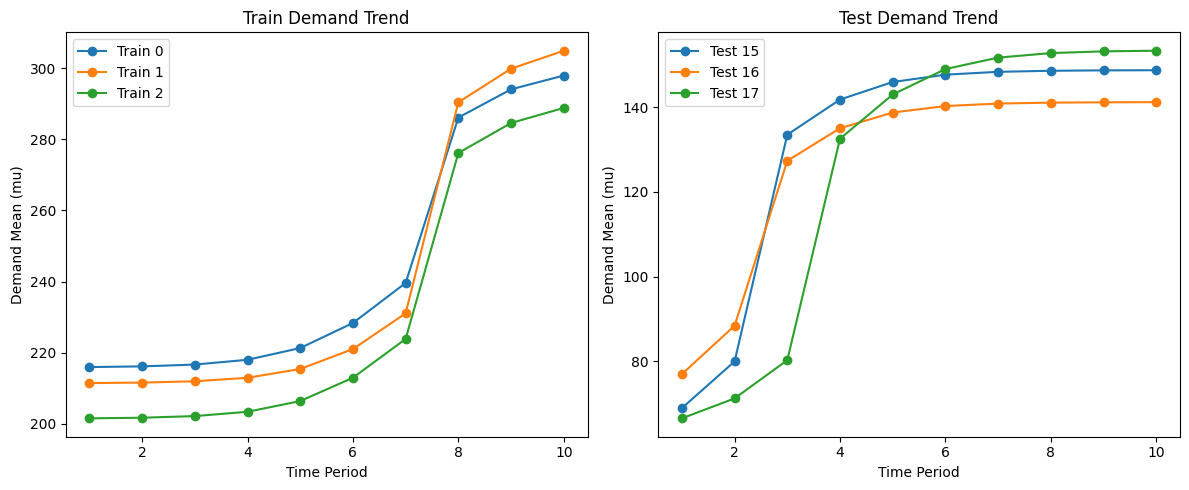

In [1460]:
# 現在我們從 full_df 中取出第一個 chunk（共 CHUNK_SIZE 筆），並分別選出前 3 筆訓練與後 3 筆測試觀測
chunk_indices = range(0, CHUNK_SIZE)
train_indices = [i for i in chunk_indices if full_df.loc[i, "X2"] == 0][:3]
test_indices = [i for i in chunk_indices if full_df.loc[i, "X2"] == 1][:3]

print("Train indices:", train_indices)
print("Test indices:", test_indices)

# 繪圖：X軸為 t=1..T, Y軸為 mu
plt.figure(figsize=(12, 5))

# 畫出訓練資料趨勢
plt.subplot(1, 2, 1)
for i in train_indices:
    plt.plot(range(1, T + 1), mu_matrix[i, :], marker="o", label=f"Train {i}")
plt.title("Train Demand Trend")
plt.xlabel("Time Period")
plt.ylabel("Demand Mean (mu)")
plt.legend()

# 畫出測試資料趨勢
plt.subplot(1, 2, 2)
for i in test_indices:
    plt.plot(range(1, T + 1), mu_matrix[i, :], marker="o", label=f"Test {i}")
plt.title("Test Demand Trend")
plt.xlabel("Time Period")
plt.ylabel("Demand Mean (mu)")
plt.legend()

plt.tight_layout()
plt.show()

### sigma matrix


In [1461]:
X = full_df.values
feature_num = X.shape[1]
print(f"X.shape: {X.shape}")

# 生成輸入特徵矩陣 X (shape: feature_num * data_size)
np.random.seed(0)

# 隨機生成常數項 c 和係數向量 coefficients
c = np.random.uniform(0, 1)
coefficients = np.random.uniform(-1, 1, (feature_num, T))  # shape: (feature_num, T)

print(f"coefficients.shape: {coefficients.shape}")
print(f"coefficients: {coefficients}")

X.shape: (90, 3)
coefficients.shape: (3, 10)
coefficients: [[ 0.43037873  0.20552675  0.08976637 -0.1526904   0.29178823 -0.12482558
   0.783546    0.92732552 -0.23311696  0.58345008]
 [ 0.05778984  0.13608912  0.85119328 -0.85792788 -0.8257414  -0.95956321
   0.66523969  0.5563135   0.7400243   0.95723668]
 [ 0.59831713 -0.07704128  0.56105835 -0.76345115  0.27984204 -0.71329343
   0.88933783  0.04369664 -0.17067612 -0.47088878]]


In [1462]:
# 進行矩陣運算
# X.T 的形狀為 (data_size, feature_num)，X.T @ coefficients 的形狀為 (feature_num, T)
linear_combination = c + X @ coefficients

# 使用 sigmoid 函數將值映射到 [0, 1] 之間
sigma_matrix = 1 / (1 + np.exp(-linear_combination))  # shape: (data_size, T)
# print(f"sigma_matrix.shape: {sigma_matrix.shape}")
# print(f"sigma_matrix: {sigma_matrix}")

# 計算每個元素的最小值和最大值
min_value = np.min(sigma_matrix)
max_value = np.max(sigma_matrix)
print(f"Value range: {(min_value, max_value)}")

# 再將值縮放到 [2, 10] 的範圍
# shape: (data_size, T)
# sigma_matrix = 0 + sigma_matrix * 300

# sigma_matrix = 0 + sigma_matrix * 200
# sigma_matrix = 100 + sigma_matrix * 100
# sigma_matrix = 0 + sigma_matrix * 10
sigma_matrix = 0 + sigma_matrix * 3
# sigma_matrix = 50 + sigma_matrix * 50
# sigma_matrix = 0 + sigma_matrix * 2
# sigma_matrix = 10 + sigma_matrix * 5
# sigma_matrix = 0 + sigma_matrix * 1


# sigma_matrix = 0 + sigma_matrix * 80
# sigma_matrix = 40 + sigma_matrix * 40
# sigma_matrix = 0 + sigma_matrix * 40
# sigma_matrix = 20 + sigma_matrix * 20
# sigma_matrix = 0 + sigma_matrix * 5

# sigma_matrix = 0 + sigma_matrix * 8
# sigma_matrix = 4 + sigma_matrix * 4
# sigma_matrix = 0 + sigma_matrix * 4
# sigma_matrix = 2 + sigma_matrix * 2
# sigma_matrix = 0 + sigma_matrix * 0.3

# 計算每個元素的最小值和最大值
min_value = np.min(sigma_matrix)
max_value = np.max(sigma_matrix)
print(f"New Value range: {(min_value, max_value)}")

# 輸出 sigma_matrix 的形狀和內容
sigma_matrix_shape = sigma_matrix.shape
sigma_matrix_content = sigma_matrix

sigma_matrix_shape, sigma_matrix_content

Value range: (np.float64(2.1799654523117813e-26), np.float64(1.0))
New Value range: (np.float64(6.539896356935343e-26), np.float64(3.0))


((90, 10),
 array([[3.00000000e+00, 3.00000000e+00, 3.00000000e+00, 6.08149613e-19,
         3.00000000e+00, 9.20458963e-16, 3.00000000e+00, 3.00000000e+00,
         7.56855515e-26, 3.00000000e+00],
        [3.00000000e+00, 3.00000000e+00, 3.00000000e+00, 4.71717948e-19,
         3.00000000e+00, 7.25980243e-16, 3.00000000e+00, 3.00000000e+00,
         7.15069397e-26, 3.00000000e+00],
        [3.00000000e+00, 3.00000000e+00, 3.00000000e+00, 5.60060460e-19,
         3.00000000e+00, 8.52274144e-16, 3.00000000e+00, 3.00000000e+00,
         7.43044890e-26, 3.00000000e+00],
        [3.00000000e+00, 3.00000000e+00, 3.00000000e+00, 6.11810223e-19,
         3.00000000e+00, 9.25634421e-16, 3.00000000e+00, 3.00000000e+00,
         7.57871612e-26, 3.00000000e+00],
        [3.00000000e+00, 3.00000000e+00, 3.00000000e+00, 7.36217830e-19,
         3.00000000e+00, 1.10039246e-15, 3.00000000e+00, 3.00000000e+00,
         7.89891484e-26, 3.00000000e+00],
        [3.00000000e+00, 3.00000000e+00, 3.000000

### corr matrix


In [1463]:
# Generate correlation matrix
np.random.seed(0)

A = np.random.uniform(-1, 1, (T, T))
corr_matrix = np.dot(A, A.T)

D = np.diag(1 / np.sqrt(np.diag(corr_matrix)))
corr_matrix = D @ corr_matrix @ D

print(f"corr_matrix shape: {corr_matrix.shape}")
print(f"corr_matrix: \n{corr_matrix}")

corr_matrix shape: (10, 10)
corr_matrix: 
[[ 1.          0.35424279  0.5557836   0.58741064 -0.38777369 -0.16148427
  -0.0990728  -0.27594366 -0.48889127 -0.02092469]
 [ 0.35424279  1.          0.64567134  0.34424882 -0.53396229 -0.11871438
  -0.3666009   0.07223015  0.10995817 -0.04912633]
 [ 0.5557836   0.64567134  1.          0.259728   -0.42849166 -0.23652044
  -0.55154321  0.01056255 -0.4142461  -0.12870872]
 [ 0.58741064  0.34424882  0.259728    1.         -0.43371556 -0.07896157
   0.16623268 -0.63102156  0.08913915  0.24417687]
 [-0.38777369 -0.53396229 -0.42849166 -0.43371556  1.          0.37139904
   0.30031034  0.29401969 -0.15371929 -0.10854857]
 [-0.16148427 -0.11871438 -0.23652044 -0.07896157  0.37139904  1.
   0.65829169  0.52050763 -0.34173775  0.14741869]
 [-0.0990728  -0.3666009  -0.55154321  0.16623268  0.30031034  0.65829169
   1.          0.03894138 -0.00977194  0.48587032]
 [-0.27594366  0.07223015  0.01056255 -0.63102156  0.29401969  0.52050763
   0.03894138  1.

### cov matrix


In [1464]:
# Generate covariance matrices
cov_matrices = []
for i in range(data_size):
    cov_matrix = np.zeros((T, T))  # 每一個模擬都會有 T*T 的共變異矩陣
    for j in range(T):
        for k in range(T):
            cov_matrix[j, k] = (
                corr_matrix[j, k] * sigma_matrix[i, j] * sigma_matrix[i, k]
            )
    cov_matrices.append(cov_matrix)

print(f"cov_matrices shape: {np.array(cov_matrices).shape}")
print(f"cov_matrices: \n{cov_matrices[0]}")

cov_matrices shape: (90, 10, 10)
cov_matrices: 
[[ 9.00000000e+00  3.18818512e+00  5.00205241e+00  1.07170067e-18
  -3.48996324e+00 -4.45918936e-16 -8.91655219e-01 -2.48349295e+00
  -1.11006017e-25 -1.88322255e-01]
 [ 3.18818512e+00  9.00000000e+00  5.81104207e+00  6.28064362e-19
  -4.80566058e+00 -3.27815136e-16 -3.29940812e+00  6.50071334e-01
   2.49667332e-26 -4.42136970e-01]
 [ 5.00205241e+00  5.81104207e+00  9.00000000e+00  4.73860448e-19
  -3.85642497e+00 -6.53122065e-16 -4.96388886e+00  9.50629143e-02
  -9.40573334e-26 -1.15837848e+00]
 [ 1.07170067e-18  6.28064362e-19  4.73860448e-19  3.69845952e-37
  -7.91291843e-19 -4.42008538e-35  3.03283011e-19 -1.15126655e-18
   4.10290917e-45  4.45488207e-19]
 [-3.48996324e+00 -4.80566058e+00 -3.85642497e+00 -7.91291843e-19
   9.00000000e+00  1.02557273e-15  2.70279307e+00  2.64617719e+00
  -3.49029871e-26 -9.76937126e-01]
 [-4.45918936e-16 -3.27815136e-16 -6.53122065e-16 -4.42008538e-35
   1.02557273e-15  8.47244703e-31  1.81779147e-15  

In [1465]:
def is_positive_definite(matrix):
    return np.all(np.linalg.eigvals(matrix) > 0)


positive_definite_check = all(is_positive_definite(cov) for cov in cov_matrices)
print("All covariance matrices are positive definite:", positive_definite_check)

All covariance matrices are positive definite: False


### MVN stimulation for demand_df


In [1466]:
def simulate_demand_data(data_size, T, cov_matrices, mu_matrix):
    np.random.seed(0)

    simulated_data = np.array(
        [
            np.random.multivariate_normal(mu_matrix[i], cov_matrices[i])
            for i in range(data_size)
        ]
    )

    demand_df = pd.DataFrame(
        simulated_data, columns=[f"demand_t{t}" for t in range(1, T + 1)]
    )
    return demand_df


demand_df = simulate_demand_data(data_size, T, cov_matrices, mu_matrix)
demand_df

,demand_t1,demand_t2,demand_t3,demand_t4,demand_t5,demand_t6,demand_t7,demand_t8,demand_t9,demand_t10
0,216.269540,211.134274,215.128316,217.994763,229.527662,228.343740,242.806583,289.728142,294.085892,302.742662
1,213.412362,212.203824,210.885199,212.928863,214.608230,221.012875,232.696730,291.971737,299.898413,310.098635
2,204.681787,207.336518,210.952538,203.368635,201.143341,212.945396,217.246014,274.878251,284.616328,292.693517
3,198.383496,200.987261,197.538109,202.580936,202.908901,212.987482,223.541107,289.059699,300.204667,305.030320
4,219.811740,215.888884,220.591784,218.304163,224.051815,230.563012,282.302153,291.526875,302.196239,297.751466
...,...,...,...,...,...,...,...,...,...,...
85,62.698196,78.611085,139.791254,143.076516,142.163674,150.919528,145.896928,149.493779,152.352166,146.679443
86,64.781553,72.263140,83.800937,130.848821,141.944226,142.279298,146.301937,144.274959,144.628356,146.560884
87,75.532997,88.519768,134.606680,145.260208,152.214092,151.198150,151.674544,151.286388,152.224362,152.695641
88,61.766267,71.418492,79.609229,136.806694,149.697938,149.059237,151.665693,152.244795,151.654347,150.452055


### Replace negative values to 0


In [1467]:
demand_df = replace_negative_with_zero(demand_df)
demand_df

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_65248/2799096767.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df.applymap(lambda x: max(x, 0))


,demand_t1,demand_t2,demand_t3,demand_t4,demand_t5,demand_t6,demand_t7,demand_t8,demand_t9,demand_t10
0,216.269540,211.134274,215.128316,217.994763,229.527662,228.343740,242.806583,289.728142,294.085892,302.742662
1,213.412362,212.203824,210.885199,212.928863,214.608230,221.012875,232.696730,291.971737,299.898413,310.098635
2,204.681787,207.336518,210.952538,203.368635,201.143341,212.945396,217.246014,274.878251,284.616328,292.693517
3,198.383496,200.987261,197.538109,202.580936,202.908901,212.987482,223.541107,289.059699,300.204667,305.030320
4,219.811740,215.888884,220.591784,218.304163,224.051815,230.563012,282.302153,291.526875,302.196239,297.751466
...,...,...,...,...,...,...,...,...,...,...
85,62.698196,78.611085,139.791254,143.076516,142.163674,150.919528,145.896928,149.493779,152.352166,146.679443
86,64.781553,72.263140,83.800937,130.848821,141.944226,142.279298,146.301937,144.274959,144.628356,146.560884
87,75.532997,88.519768,134.606680,145.260208,152.214092,151.198150,151.674544,151.286388,152.224362,152.695641
88,61.766267,71.418492,79.609229,136.806694,149.697938,149.059237,151.665693,152.244795,151.654347,150.452055


### Validate the mean and std of total demand


檢查生成的需求數據是否符合上述總需求的特性。例如，從生成的需求 demand_df 中計算總需求
𝐷
D，然後檢查其均值和標準差是否接近理論值（即均值為所有
𝜇
𝑡
μ
t
​
的和，標準差根據共變異數矩陣計算）。


In [1468]:
def check_theoretical_vs_empirical(demand_df, cov_matrices, mu_matrix):
    results = []
    for i in range(len(demand_df)):

        demand_i = demand_df.iloc[i, :]

        # theoretical mean
        theoretical_mean = mu_matrix[i].sum()

        # theoretical std
        variance_sum = np.sum(np.diag(cov_matrices[i]))
        covariance_sum = np.sum(cov_matrices[i]) - variance_sum
        theoretical_variance = variance_sum + covariance_sum
        theoretical_std = np.sqrt(theoretical_variance)

        # empirical mean and std
        empirical_mean = demand_i.sum()
        empirical_std = demand_i.std(ddof=0)  # 指定除以 n 而非 n-1
        std_relative_error = abs(theoretical_std - empirical_std) / empirical_std * 100

        # save the results
        results.append(
            {
                "theoretical_mean": theoretical_mean,
                "empirical_mean": empirical_mean,
                "theoretical_std": theoretical_std,
                "empirical_std": empirical_std,
                "std_relative_error": std_relative_error,
            }
        )

    return pd.DataFrame(results)


results_df = check_theoretical_vs_empirical(demand_df, cov_matrices, mu_matrix)
results_df

,theoretical_mean,empirical_mean,theoretical_std,empirical_std,std_relative_error
0,2434.202629,2447.761572,7.865978,34.437346,77.158582
1,2410.679424,2419.716868,7.865978,39.092791,79.878699
2,2301.588404,2309.862324,7.865978,35.257145,77.689690
3,2344.795563,2333.221978,7.865978,43.183231,81.784647
4,2506.759846,2502.988131,7.865978,35.731136,77.985648
...,...,...,...,...,...
85,1318.547653,1311.682568,7.865969,30.691519,74.370871
86,1217.007718,1217.684113,7.865971,32.086912,75.485421
87,1363.009964,1355.212829,7.865967,27.406663,71.299070
88,1258.880281,1254.374747,7.865972,36.149307,78.240325


### Validate normal distribution


In [1469]:
demand_df

,demand_t1,demand_t2,demand_t3,demand_t4,demand_t5,demand_t6,demand_t7,demand_t8,demand_t9,demand_t10
0,216.269540,211.134274,215.128316,217.994763,229.527662,228.343740,242.806583,289.728142,294.085892,302.742662
1,213.412362,212.203824,210.885199,212.928863,214.608230,221.012875,232.696730,291.971737,299.898413,310.098635
2,204.681787,207.336518,210.952538,203.368635,201.143341,212.945396,217.246014,274.878251,284.616328,292.693517
3,198.383496,200.987261,197.538109,202.580936,202.908901,212.987482,223.541107,289.059699,300.204667,305.030320
4,219.811740,215.888884,220.591784,218.304163,224.051815,230.563012,282.302153,291.526875,302.196239,297.751466
...,...,...,...,...,...,...,...,...,...,...
85,62.698196,78.611085,139.791254,143.076516,142.163674,150.919528,145.896928,149.493779,152.352166,146.679443
86,64.781553,72.263140,83.800937,130.848821,141.944226,142.279298,146.301937,144.274959,144.628356,146.560884
87,75.532997,88.519768,134.606680,145.260208,152.214092,151.198150,151.674544,151.286388,152.224362,152.695641
88,61.766267,71.418492,79.609229,136.806694,149.697938,149.059237,151.665693,152.244795,151.654347,150.452055


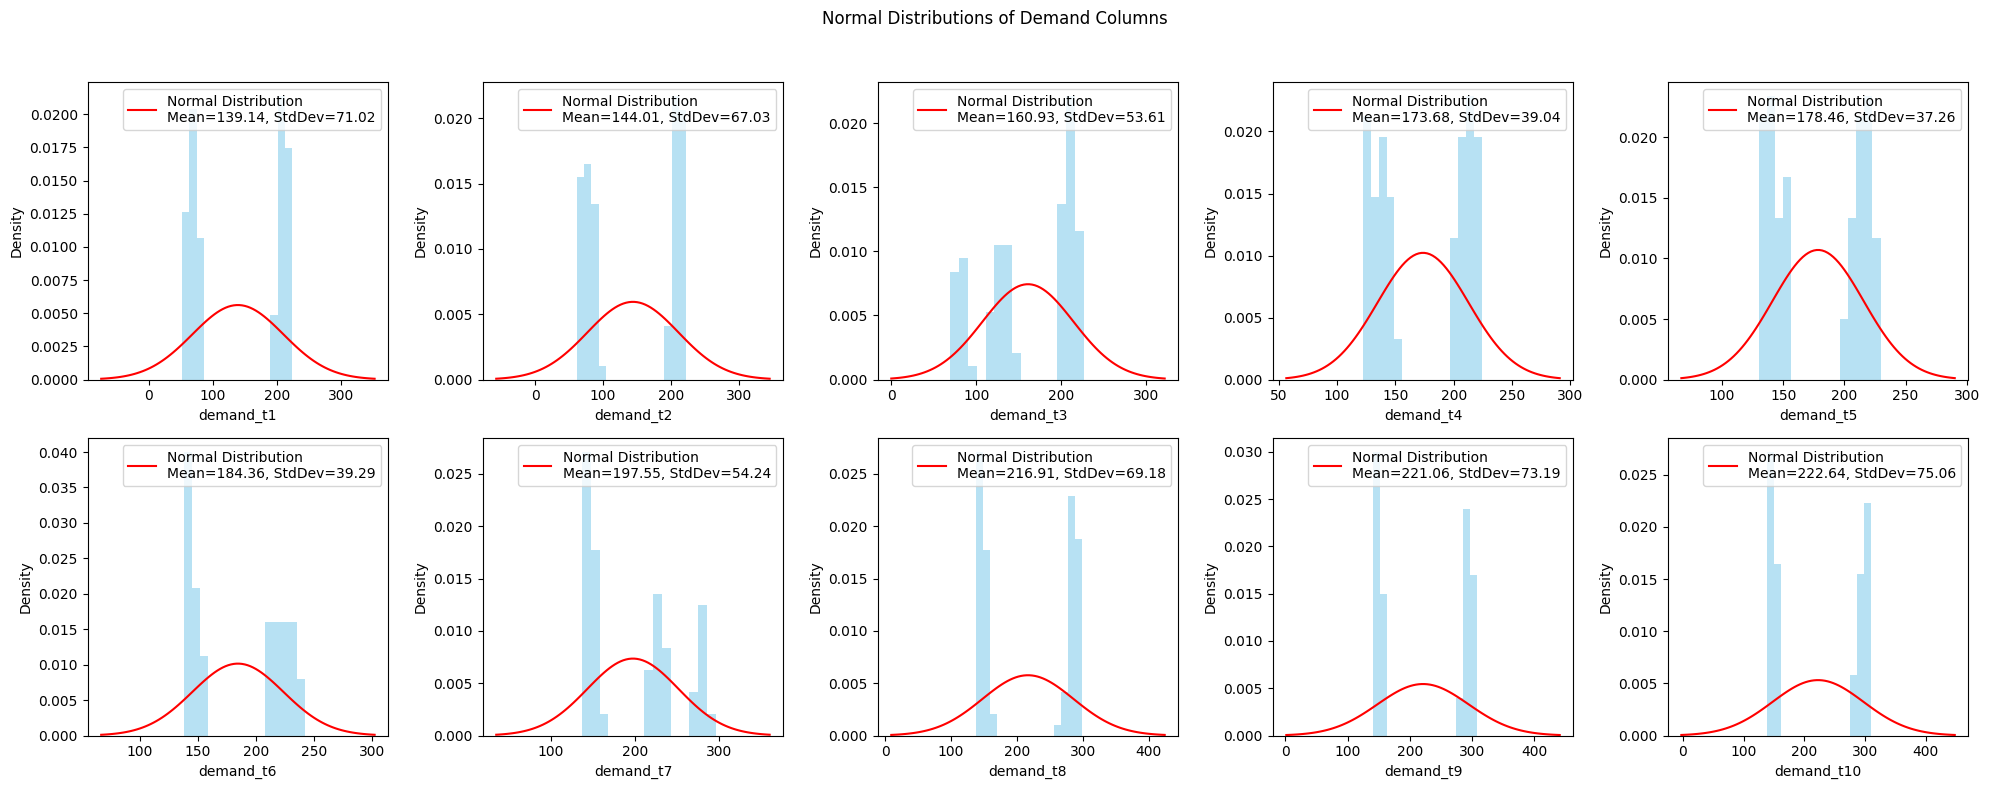

In [1470]:
# 創建 2x5 的子圖網格
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle("Normal Distributions of Demand Columns")

for idx, column in enumerate(demand_df.columns):
    data = demand_df[column].dropna()  # 移除缺失值
    mean, std_dev = np.mean(data), np.std(data)

    # 產生 x 值範圍
    x = np.linspace(mean - 3 * std_dev, mean + 3 * std_dev, 100)
    pdf = norm.pdf(x, mean, std_dev)

    # 確定當前的軸位置
    ax = axes[idx // 5, idx % 5]
    ax.hist(data, bins=15, density=True, alpha=0.6, color="skyblue")
    ax.plot(
        x,
        pdf,
        "r-",
        label=f"Normal Distribution\nMean={mean:.2f}, StdDev={std_dev:.2f}",
    )
    ax.set_xlabel(column)
    ax.set_ylabel("Density")
    ax.legend()

# 移除空白子圖（若有）
for idx in range(len(demand_df.columns), 10):
    fig.delaxes(axes[idx // 5, idx % 5])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Validate the covariance


In [1471]:
demand_df.cov()

,demand_t1,demand_t2,demand_t3,demand_t4,demand_t5,demand_t6,demand_t7,demand_t8,demand_t9,demand_t10
demand_t1,5100.505115,4808.047395,3661.323557,2772.347453,2632.614785,2782.226478,3663.192086,4921.687805,5217.772355,5345.413769
demand_t2,4808.047395,4544.115580,3477.890700,2619.745987,2483.783544,2624.946271,3451.603840,4638.947910,4916.813649,5035.990363
demand_t3,3661.323557,3477.890700,2906.644827,2047.925147,1917.364971,2015.001633,2632.481680,3507.813425,3721.903140,3807.554414
demand_t4,2772.347453,2619.745987,2047.925147,1541.594594,1464.165999,1543.098011,2031.097847,2689.919684,2848.917692,2915.470163
demand_t5,2632.614785,2483.783544,1917.364971,1464.165999,1404.258060,1473.552272,1947.776343,2566.333892,2712.387325,2772.758480
demand_t6,2782.226478,2624.946271,2015.001633,1543.098011,1473.552272,1561.357341,2087.275585,2711.966398,2866.394441,2929.358577
demand_t7,3663.192086,3451.603840,2632.481680,2031.097847,1947.776343,2087.275585,2975.296334,3594.672783,3783.151788,3853.261662
demand_t8,4921.687805,4638.947910,3507.813425,2689.919684,2566.333892,2711.966398,3594.672783,4839.496415,5113.808138,5236.299388
demand_t9,5217.772355,4916.813649,3721.903140,2848.917692,2712.387325,2866.394441,3783.151788,5113.808138,5416.836813,5549.438577
demand_t10,5345.413769,5035.990363,3807.554414,2915.470163,2772.758480,2929.358577,3853.261662,5236.299388,5549.438577,5696.572903


In [1472]:
empirical_covariance = demand_df.cov()
covariance_diff = np.abs(empirical_covariance - np.array(cov_matrices).mean(axis=0))
covariance_diff

,demand_t1,demand_t2,demand_t3,demand_t4,demand_t5,demand_t6,demand_t7,demand_t8,demand_t9,demand_t10
demand_t1,5091.505115,4804.859210,3656.321521,2772.347453,2636.104748,2782.226479,3664.083741,4924.171298,5217.772355,5345.602092
demand_t2,4804.859210,4535.115580,3472.079677,2619.745987,2488.589204,2624.946271,3454.903248,4638.297838,4916.813649,5036.432500
demand_t3,3656.321521,3472.079677,2897.644886,2047.925147,1921.221383,2015.001633,2637.445552,3507.718362,3721.903140,3808.712789
demand_t4,2772.347453,2619.745987,2047.925147,1541.594594,1464.165999,1543.098011,2031.097847,2689.919684,2848.917692,2915.470163
demand_t5,2636.104748,2488.589204,1921.221383,1464.165999,1395.258060,1473.552272,1945.073550,2563.687715,2712.387325,2773.735417
demand_t6,2782.226479,2624.946271,2015.001633,1543.098011,1473.552272,1561.357341,2087.275584,2711.966398,2866.394441,2929.358577
demand_t7,3664.083741,3454.903248,2637.445552,2031.097847,1945.073550,2087.275584,2966.296334,3594.322311,3783.151788,3848.888829
demand_t8,4924.171298,4638.297838,3507.718362,2689.919684,2563.687715,2711.966398,3594.322311,4830.496415,5113.808138,5235.125003
demand_t9,5217.772355,4916.813649,3721.903140,2848.917692,2712.387325,2866.394441,3783.151788,5113.808138,5416.836813,5549.438577
demand_t10,5345.602092,5036.432500,3808.712789,2915.470163,2773.735417,2929.358577,3848.888829,5235.125003,5549.438577,5687.572903


### Validate the corr matrix of damand_df is close to original setting


In [1473]:
demand_df

,demand_t1,demand_t2,demand_t3,demand_t4,demand_t5,demand_t6,demand_t7,demand_t8,demand_t9,demand_t10
0,216.269540,211.134274,215.128316,217.994763,229.527662,228.343740,242.806583,289.728142,294.085892,302.742662
1,213.412362,212.203824,210.885199,212.928863,214.608230,221.012875,232.696730,291.971737,299.898413,310.098635
2,204.681787,207.336518,210.952538,203.368635,201.143341,212.945396,217.246014,274.878251,284.616328,292.693517
3,198.383496,200.987261,197.538109,202.580936,202.908901,212.987482,223.541107,289.059699,300.204667,305.030320
4,219.811740,215.888884,220.591784,218.304163,224.051815,230.563012,282.302153,291.526875,302.196239,297.751466
...,...,...,...,...,...,...,...,...,...,...
85,62.698196,78.611085,139.791254,143.076516,142.163674,150.919528,145.896928,149.493779,152.352166,146.679443
86,64.781553,72.263140,83.800937,130.848821,141.944226,142.279298,146.301937,144.274959,144.628356,146.560884
87,75.532997,88.519768,134.606680,145.260208,152.214092,151.198150,151.674544,151.286388,152.224362,152.695641
88,61.766267,71.418492,79.609229,136.806694,149.697938,149.059237,151.665693,152.244795,151.654347,150.452055


In [1474]:
correlation_matrix = demand_df.corr()
print("Correlation Matrix from demand_df:")
correlation_matrix

Correlation Matrix from demand_df:


,demand_t1,demand_t2,demand_t3,demand_t4,demand_t5,demand_t6,demand_t7,demand_t8,demand_t9,demand_t10
demand_t1,1.000000,0.998706,0.950902,0.988681,0.983688,0.985904,0.940347,0.990621,0.992672,0.991672
demand_t2,0.998706,1.000000,0.956963,0.989804,0.983254,0.985473,0.938709,0.989224,0.991029,0.989814
demand_t3,0.950902,0.956963,1.000000,0.967460,0.949042,0.945863,0.895167,0.935277,0.937986,0.935714
demand_t4,0.988681,0.989804,0.967460,1.000000,0.995134,0.994620,0.948376,0.984814,0.985875,0.983822
demand_t5,0.983688,0.983254,0.949042,0.995134,1.000000,0.995155,0.952907,0.984441,0.983457,0.980351
demand_t6,0.985904,0.985473,0.945863,0.994620,0.995155,1.000000,0.968419,0.986582,0.985625,0.982233
demand_t7,0.940347,0.938709,0.895167,0.948376,0.952907,0.968419,1.000000,0.947314,0.942358,0.935958
demand_t8,0.990621,0.989224,0.935277,0.984814,0.984441,0.986582,0.947314,1.000000,0.998784,0.997281
demand_t9,0.992672,0.991029,0.937986,0.985875,0.983457,0.985625,0.942358,0.998784,1.000000,0.999009
demand_t10,0.991672,0.989814,0.935714,0.983822,0.980351,0.982233,0.935958,0.997281,0.999009,1.000000


In [1475]:
print(f"Original corr_matrix shape: {corr_matrix.shape}")
corr_matrix_df = pd.DataFrame(corr_matrix)
corr_matrix_df

Original corr_matrix shape: (10, 10)


,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.354243,0.555784,0.587411,-0.387774,-0.161484,-0.099073,-0.275944,-0.488891,-0.020925
1,0.354243,1.000000,0.645671,0.344249,-0.533962,-0.118714,-0.366601,0.072230,0.109958,-0.049126
2,0.555784,0.645671,1.000000,0.259728,-0.428492,-0.236520,-0.551543,0.010563,-0.414246,-0.128709
3,0.587411,0.344249,0.259728,1.000000,-0.433716,-0.078962,0.166233,-0.631022,0.089139,0.244177
4,-0.387774,-0.533962,-0.428492,-0.433716,1.000000,0.371399,0.300310,0.294020,-0.153719,-0.108549
5,-0.161484,-0.118714,-0.236520,-0.078962,0.371399,1.000000,0.658292,0.520508,-0.341738,0.147419
6,-0.099073,-0.366601,-0.551543,0.166233,0.300310,0.658292,1.000000,0.038941,-0.009772,0.485870
7,-0.275944,0.072230,0.010563,-0.631022,0.294020,0.520508,0.038941,1.000000,-0.203659,0.130487
8,-0.488891,0.109958,-0.414246,0.089139,-0.153719,-0.341738,-0.009772,-0.203659,1.000000,0.355112
9,-0.020925,-0.049126,-0.128709,0.244177,-0.108549,0.147419,0.485870,0.130487,0.355112,1.000000


### Split test and train demand_df


In [1476]:
def demand_data_split_data_k_fold(data):
    folds = []
    chunk_size = CHUNK_SIZE  # 每組 60 筆資料
    train_chunk = int(train_size * chunk_size)

    n = len(data)
    # 依序切分每一個 chunk
    for start in range(0, n, chunk_size):
        # 若剩餘資料不足 60 筆，這裡直接跳過
        if start + chunk_size > n:
            break
        chunk = data.iloc[start : start + chunk_size].reset_index(drop=True)
        train_data = chunk.iloc[:train_chunk].reset_index(drop=True)
        test_data = chunk.iloc[train_chunk:].reset_index(drop=True)
        folds.append((train_data, test_data))

    return folds


# 使用函數切分資料
demand_folds = demand_data_split_data_k_fold(demand_df)

# 印出結果，每個 fold 的訓練與測試資料
for i, (train_data, test_data) in enumerate(demand_folds, 1):
    print(f"Fold {i}:")
    print("Train Data:")
    print(train_data.shape)
    print("Test Data:")
    print(test_data.shape)
    print("=" * 40)

Fold 1:
Train Data:
(15, 10)
Test Data:
(15, 10)
Fold 2:
Train Data:
(15, 10)
Test Data:
(15, 10)
Fold 3:
Train Data:
(15, 10)
Test Data:
(15, 10)


### Define the Q star(Q optimal)


In [1477]:
def calculate_Q_star(demand_df, service_level=0.95):

    # 計算每一行的總和
    demand_sum = demand_df.sum(axis=1)

    # 計算總和的均值和標準差
    mean_sum = demand_sum.mean()
    std_sum = demand_sum.std()

    # 計算總和的95%百分位數值
    Q_star = norm.ppf(service_level, loc=mean_sum, scale=std_sum)

    # 打印結果
    print(f"mean of sum: {mean_sum}")
    print(f"std of sum: {std_sum}")
    print(f"{service_level*100} percentile of sum: {Q_star}")

    return Q_star

In [1478]:
demand_folds

[(     demand_t1   demand_t2   demand_t3   demand_t4   demand_t5   demand_t6  \
  0   216.269540  211.134274  215.128316  217.994763  229.527662  228.343740   
  1   213.412362  212.203824  210.885199  212.928863  214.608230  221.012875   
  2   204.681787  207.336518  210.952538  203.368635  201.143341  212.945396   
  3   198.383496  200.987261  197.538109  202.580936  202.908901  212.987482   
  4   219.811740  215.888884  220.591784  218.304163  224.051815  230.563012   
  5   220.360046  221.653541  221.084469  221.365066  219.588375  230.349881   
  6   206.804647  210.281255  211.971112  211.899313  212.103444  223.938525   
  7   197.500672  202.217054  202.132739  203.477299  205.711701  209.558780   
  8   204.862165  204.349647  204.410897  203.832857  198.517193  209.219411   
  9   214.729484  211.058905  213.111249  213.393977  216.269393  226.294654   
  10  203.536333  198.875464  199.443303  206.642554  213.162637  213.806483   
  11  211.399931  203.772432  204.362386

In [1479]:
# demand_df_train_1 = demand_folds[0][0]
# Q_star = calculate_Q_star(demand_df_train_1, service_level=0.95)
# print(f"Q_star: {Q_star}\n")

# demand_df_train_2 = demand_folds[1][0]
# Q_star = calculate_Q_star(demand_df_train_2, service_level=0.95)
# print(f"Q_star: {Q_star}\n")

demand_df_train_1 = demand_folds[0][0]
Q_star = calculate_Q_star(demand_df_train_1, service_level=0.95)
print(f"Q_star: {Q_star}\n")

mean of sum: 2400.9164885329315
std of sum: 75.12106255060029
95.0 percentile of sum: 2524.479640729735
Q_star: 2524.479640729735



## Data3: Qk hat df


### Functions


In [1480]:
# 計算條件分佈的函數
def calculate_conditional_distribution(mu, covariance_matrix, x_observed, k):
    mu_1 = mu[:k]
    mu_2 = mu[k:]
    Sigma_11 = covariance_matrix[:k, :k]
    Sigma_22 = covariance_matrix[k:, k:]
    Sigma_12 = covariance_matrix[k:, :k]
    Sigma_21 = covariance_matrix[:k, k:]

    # Compute conditional mean and covariance
    Sigma_11_inv = np.linalg.pinv(Sigma_11)
    mu_cond = mu_2 + np.dot(Sigma_12, np.dot(Sigma_11_inv, (x_observed - mu_1)))
    sigma_cond = Sigma_22 - np.dot(Sigma_12, np.dot(Sigma_11_inv, Sigma_21))

    return mu_cond, sigma_cond

In [1481]:
def cal_Var_Y(sigma_cond):

    # Extract the variances (diagonal elements)
    variances = np.diag(sigma_cond)

    # Calculate the sum of covariances (off-diagonal elements)
    covariances_sum = np.sum(sigma_cond) - np.sum(variances)

    # Total variance for the sum of mu_cond
    total_variance = np.sum(variances) + covariances_sum

    return total_variance

In [1482]:
def cal_Qk_hat(mu_cond, sigma_cond, service_level, x_observed):
    # predict_quantity = mu_cond + norm.ppf(service_level) * np.sqrt(np.diag(sigma_cond))
    # Qk_hat = x_observed.sum() + predict_quantity.sum()

    mean_Y = np.sum(mu_cond)
    var_Y = cal_Var_Y(sigma_cond)

    sd_Y = np.sqrt(var_Y)
    if sd_Y < 0 or np.isnan(sd_Y):  # scale must be positive
        sd_Y = 1e-6

    percentile_95_Y = norm.ppf(service_level, loc=mean_Y, scale=sd_Y)

    # print(f"        mean_Y: {mean_Y}")
    # print(f"        sd_Y: {sd_Y}")
    # print(f"    percentile_95_Y: {percentile_95_Y}")

    Qk_hat = x_observed.sum() + percentile_95_Y
    return Qk_hat

In [1483]:
def cal_mu_and_cov_matrix(demand_df_train):

    mu_matrix = demand_df_train.mean().values
    covariance_matrix = demand_df_train.cov().values

    # print(f"mu_matrix: {mu_matrix}")
    # print(f"covariance_matrix: \n{covariance_matrix}\n")

    return mu_matrix, covariance_matrix

In [1484]:
def make_Qk_hat_df(demand_df, T, service_level, mu_matrix, covariance_matrix):
    results_df = pd.DataFrame(index=demand_df.index)

    for index, row_data in demand_df.iterrows():
        for k in range(2, T):
            # print(f"Now processing index: {index}, t={k}")

            x_observed = row_data[
                : k - 1
            ].values  # 取出前 k 個觀測值 -> Qk_hat_2(t=2): 則 observerd: T=1

            mu_cond, sigma_cond = calculate_conditional_distribution(
                mu_matrix, covariance_matrix, x_observed, len(x_observed)
            )

            Qk_hat = cal_Qk_hat(mu_cond, sigma_cond, service_level, x_observed)

            results_df.loc[index, f"Qk_hat_k{k}"] = Qk_hat

            # print(f"    x_observed: {x_observed}")
            # print(f"    mu_cond: {mu_cond}")
            # print(f"    sigma_cond: \n{sigma_cond}")
            # print(f"    Qk_hat: {Qk_hat}")
            # print("\n")

    return results_df

公式連結：https://jujueffectivelife.notion.site/Qk-eab4d89ec36345efbf3a0d4a4f488474?pvs=4


### Validate the consistency of condMVN in Python and R


#### Given mu and sigma


In [1485]:
from scipy.stats import multivariate_normal

# Define the mean vector and the covariance matrix
mu = np.array([10, 20, 30, 40])
covariance_matrix = np.array([[5, 1, 0, 2], [1, 8, 1, 0], [0, 1, 10, 1], [2, 0, 1, 7]])

# Mean and covariance partitioning
mu_1 = mu[:2]
mu_2 = mu[2:]
Sigma_11 = covariance_matrix[:2, :2]
Sigma_22 = covariance_matrix[2:, 2:]
Sigma_12 = covariance_matrix[2:, :2]
Sigma_21 = covariance_matrix[:2, 2:]

print(f"Sigma_11: \n{Sigma_11}\n")
print(f"Sigma_22: \n{Sigma_22}\n")
print(f"Sigma_12: \n{Sigma_12}\n")
print(f"Sigma_21: \n{Sigma_21}\n")

Sigma_11: 
[[5 1]
 [1 8]]

Sigma_22: 
[[10  1]
 [ 1  7]]

Sigma_12: 
[[0 1]
 [2 0]]

Sigma_21: 
[[0 2]
 [1 0]]



In [1486]:
# Observed values of X1 and X2
x_observed = np.array([6, 30])

mu_cond, sigma_cond = calculate_conditional_distribution(
    mu, covariance_matrix, x_observed, len(x_observed)
)
print(f"mu_cond: {mu_cond}")
print(f"sigma_cond: \n{sigma_cond}")

mu_cond: [31.38461538 37.84615385]
sigma_cond: 
[[9.87179487 1.05128205]
 [1.05128205 6.17948718]]


In [1487]:
# Define the conditional distribution
conditional_dist = multivariate_normal(mean=mu_cond, cov=sigma_cond)

# Values at which to evaluate the PDF and CDF
x3, x4 = 30, 40  # These can be any values of interest

# Calculate the PDF
pdf_value = conditional_dist.pdf([x3, x4])
print(f"Conditional density at X3 = {x3}, X4 = {x4}: {pdf_value}")

# Calculate the CDF
cdf_value = conditional_dist.cdf([x3, x4])
print(f"Conditional cumulative probability up to X3 = {x3}, X4 = {x4}: {cdf_value}")

# Qk hat
Qk_hat = cal_Qk_hat(mu_cond, sigma_cond, service_level, x_observed)
print(f"Qk_hat of x_observed: {Qk_hat}")

Conditional density at X3 = 30, X4 = 40: 0.012061749355189695
Conditional cumulative probability up to X3 = 30, X4 = 40: 0.2790601403798458
Qk_hat of x_observed: 112.23905144741786


```
R 中運行的結果
```

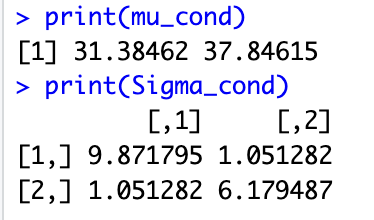
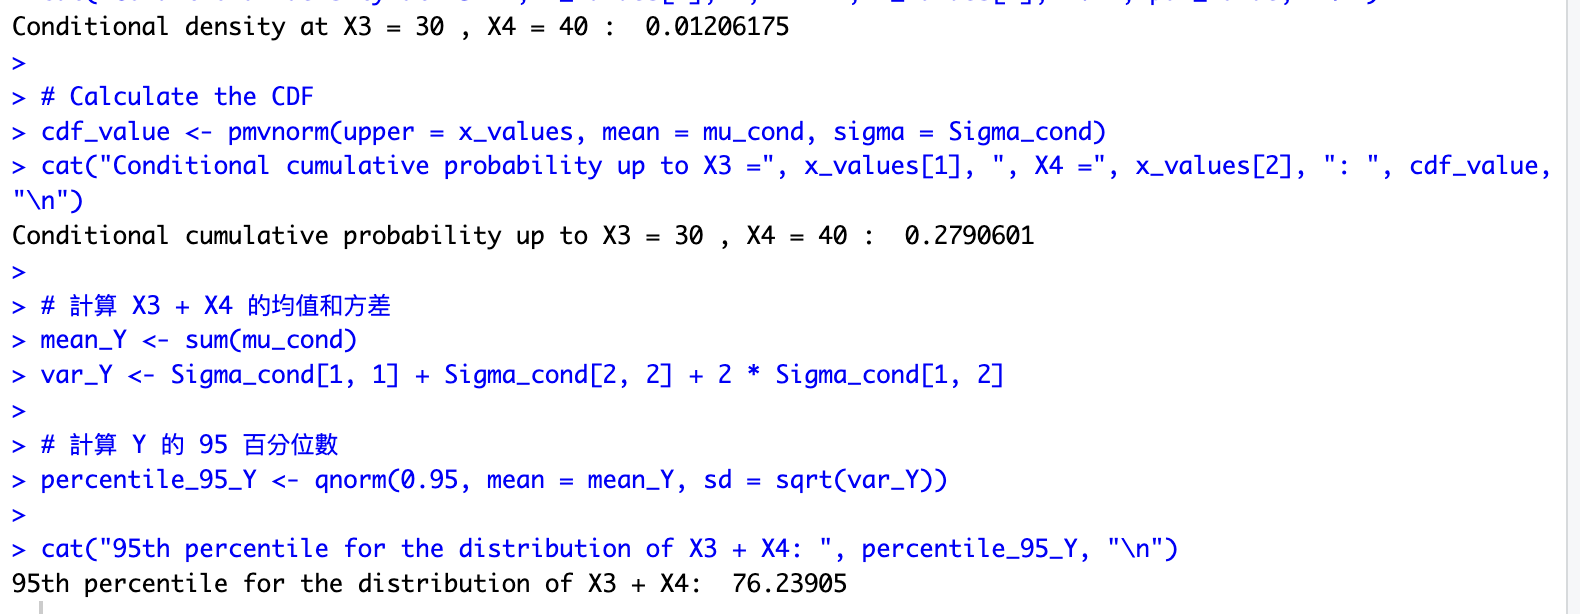


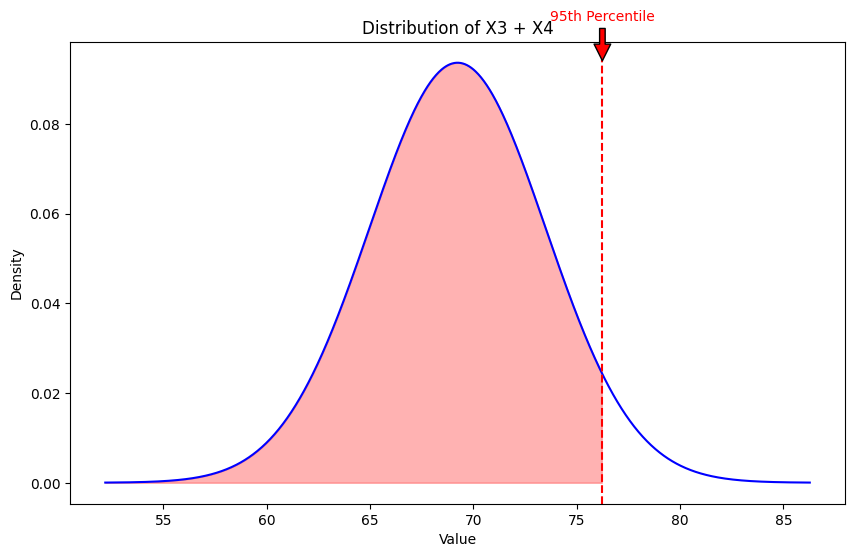

In [1488]:
import matplotlib.pyplot as plt
from scipy.stats import norm

mean_Y = np.sum(mu_cond)
var_Y = cal_Var_Y(sigma_cond)

percentile_95_Y = norm.ppf(service_level, loc=mean_Y, scale=np.sqrt(var_Y))

# Generate normal distribution data
x_values = np.linspace(mean_Y - 4 * np.sqrt(var_Y), mean_Y + 4 * np.sqrt(var_Y), 1000)
y_values = norm.pdf(x_values, loc=mean_Y, scale=np.sqrt(var_Y))

# Create dataframe
data = pd.DataFrame({"x": x_values, "y": y_values})

# Plot distribution
plt.figure(figsize=(10, 6))
plt.plot(data["x"], data["y"], color="blue")
plt.axvline(x=percentile_95_Y, color="red", linestyle="dashed")
plt.fill_between(
    data["x"], data["y"], where=(data["x"] <= percentile_95_Y), color="red", alpha=0.3
)
plt.title("Distribution of X3 + X4")
plt.xlabel("Value")
plt.ylabel("Density")
plt.annotate(
    "95th Percentile",
    xy=(percentile_95_Y, max(y_values)),
    xytext=(percentile_95_Y, max(y_values) * 1.1),
    arrowprops=dict(facecolor="red", shrink=0.05),
    color="red",
    ha="center",
)
plt.show()

```
以下為 R 程式結果
```


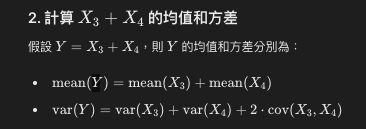


P(X3,X4∣X1=10,X2=20) 的 R 計算如下

```
install.packages("condMVNorm")
install.packages("mvtnorm")
library(condMVNorm)
library(mvtnorm)
library(ggplot2)

# Define the mean vector and covariance matrix
mu <- c(10, 20, 30, 40)
sigma <- matrix(c(
    5, 1, 0, 2,
    1, 8, 1, 0,
    0, 1, 10, 1,
    2, 0, 1, 7
), nrow = 4, byrow = TRUE)

# Observed values of X1 and X2
x_observed <- c(6, 30)

# Compute the conditional mean and covariance using condMVNorm
conditional_results <- condMVN(mean = mu, sigma = sigma, dependent.ind = c(3, 4), given.ind = c(1, 2), X.given = x_observed)

# Print the conditional mean and covariance
print(conditional_results$condMean)
print(conditional_results$condVar)

# Extract the conditional mean and covariance
mu_cond <- conditional_results$condMean
Sigma_cond <- conditional_results$condVar

# Print the conditional mean and covariance
print(mu_cond)
print(Sigma_cond)

# Values at which to evaluate the PDF and CDF
x_values <- c(30, 40)

# Calculate the PDF
pdf_value <- dmvnorm(x_values, mean = mu_cond, sigma = Sigma_cond)
cat("Conditional density at X3 =", x_values[1], ", X4 =", x_values[2], ": ", pdf_value, "\n")

# Calculate the CDF
cdf_value <- pmvnorm(upper = x_values, mean = mu_cond, sigma = Sigma_cond)
cat("Conditional cumulative probability up to X3 =", x_values[1], ", X4 =", x_values[2], ": ", cdf_value, "\n")

```


#### Conditional mean and variance


In [1489]:
def cal_Var_Y(sigma_cond):
    variances = np.diag(sigma_cond)
    covariances_sum = np.sum(sigma_cond) - np.sum(variances)
    total_variance = np.sum(variances) + covariances_sum

    return total_variance


def simulate_Y(mu_cond, sigma_cond, num_samples=10000):
    samples = np.random.multivariate_normal(mu_cond, sigma_cond, num_samples)

    Y = samples[:, 0] + samples[:, 1]

    mean_Y = np.mean(Y)
    var_Y = np.var(Y)

    return mean_Y, var_Y


mu_cond = [2, 3]
sigma_cond = [[1, 0.5], [0.5, 1]]

mean_Y_formula = np.sum(mu_cond)
var_Y_formula = cal_Var_Y(sigma_cond)

mean_Y_simulated, var_Y_simulated = simulate_Y(mu_cond, sigma_cond)

print(f"公式計算的Y的均值: {mean_Y_formula}")
print(f"公式計算的Y的方差: {var_Y_formula}")
print(f"模擬計算的Y的均值: {mean_Y_simulated}")
print(f"模擬計算的Y的方差: {var_Y_simulated}")

公式計算的Y的均值: 5
公式計算的Y的方差: 3.0
模擬計算的Y的均值: 5.01077089723792
模擬計算的Y的方差: 2.9701945334779807


### Calculate Qk hat for 2~T-1 of demand_df_train


In [1490]:
demand_df_train = demand_folds[0][0]

In [1491]:
_, _ = cal_mu_and_cov_matrix(demand_df_train)

In [1492]:
mu_matrix, covariance_matrix = cal_mu_and_cov_matrix(demand_df)
Qk_hat_df = make_Qk_hat_df(demand_df, T, service_level, mu_matrix, covariance_matrix)

In [1493]:
Qk_hat_df

,Qk_hat_k2,Qk_hat_k3,Qk_hat_k4,Qk_hat_k5,Qk_hat_k6,Qk_hat_k7,Qk_hat_k8,Qk_hat_k9
0,2543.187282,2520.705176,2528.829590,2526.149161,2542.158236,2515.075421,2502.250564,2458.130618
1,2520.273230,2511.301893,2507.827690,2479.318113,2474.161385,2452.049828,2442.544347,2429.494767
2,2450.255595,2453.357978,2448.529785,2371.869213,2362.748709,2363.529295,2338.448340,2316.483020
3,2399.744435,2401.367154,2387.885637,2344.721035,2336.819482,2329.809214,2314.584298,2336.624213
4,2571.595090,2554.195423,2562.026131,2541.792726,2546.556232,2542.224658,2559.948890,2514.056082
...,...,...,...,...,...,...,...,...
85,1311.572811,1333.047755,1349.106955,1350.022211,1338.130099,1346.136222,1330.017408,1320.957869
86,1328.280961,1319.912066,1293.870823,1286.077090,1287.722012,1262.202019,1270.667264,1225.693075
87,1414.505598,1428.116645,1433.896935,1421.801612,1426.459046,1403.479862,1406.882661,1362.185374
88,1304.098906,1302.902952,1269.765826,1320.890245,1322.800522,1292.081682,1298.679291,1264.775512


### Plot the distribuction


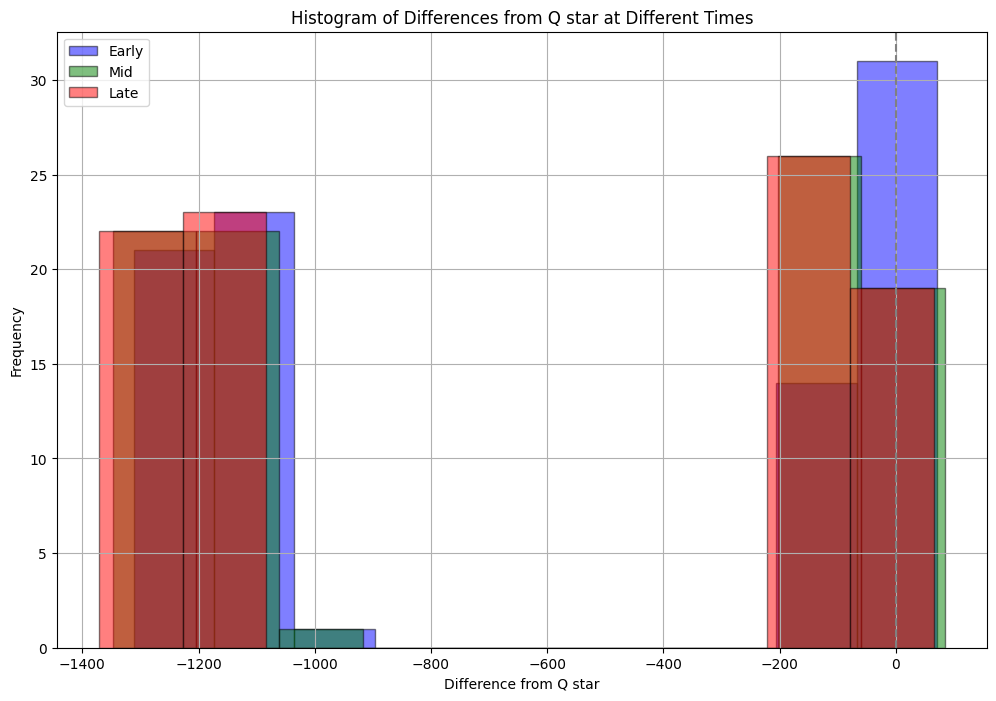

Q_star is: 2524.479640729735
Early bias: -602.9057344111947
Mid bias: -636.3266223153399
Late bias: -660.7051518982014


In [1494]:
# 將 T 個時期分成三份
early_values = Qk_hat_df.iloc[:, : T // 3].mean(axis=1)
mid_values = Qk_hat_df.iloc[:, T // 3 : 2 * T // 3].mean(axis=1)
late_values = Qk_hat_df.iloc[:, 2 * T // 3 :].mean(axis=1)

# 計算與 Q_star 的差距
early_diff = early_values - Q_star
mid_diff = mid_values - Q_star
late_diff = late_values - Q_star

# 繪製直方圖
plt.figure(figsize=(12, 8))

# 早期
plt.hist(early_diff, bins=10, alpha=0.5, label="Early", color="blue", edgecolor="black")
# 中期
plt.hist(mid_diff, bins=10, alpha=0.5, label="Mid", color="green", edgecolor="black")
# 晚期
plt.hist(late_diff, bins=10, alpha=0.5, label="Late", color="red", edgecolor="black")

plt.axvline(0, color="grey", linestyle="--")

plt.xlabel("Difference from Q star")
plt.ylabel("Frequency")
plt.title("Histogram of Differences from Q star at Different Times")
plt.legend()
plt.grid(True)
plt.show()

# 計算偏差
early_bias = np.mean(early_diff)
mid_bias = np.mean(mid_diff)
late_bias = np.mean(late_diff)

print(f"Q_star is: {Q_star}")
print(f"Early bias: {early_bias}")
print(f"Mid bias: {mid_bias}")
print(f"Late bias: {late_bias}")

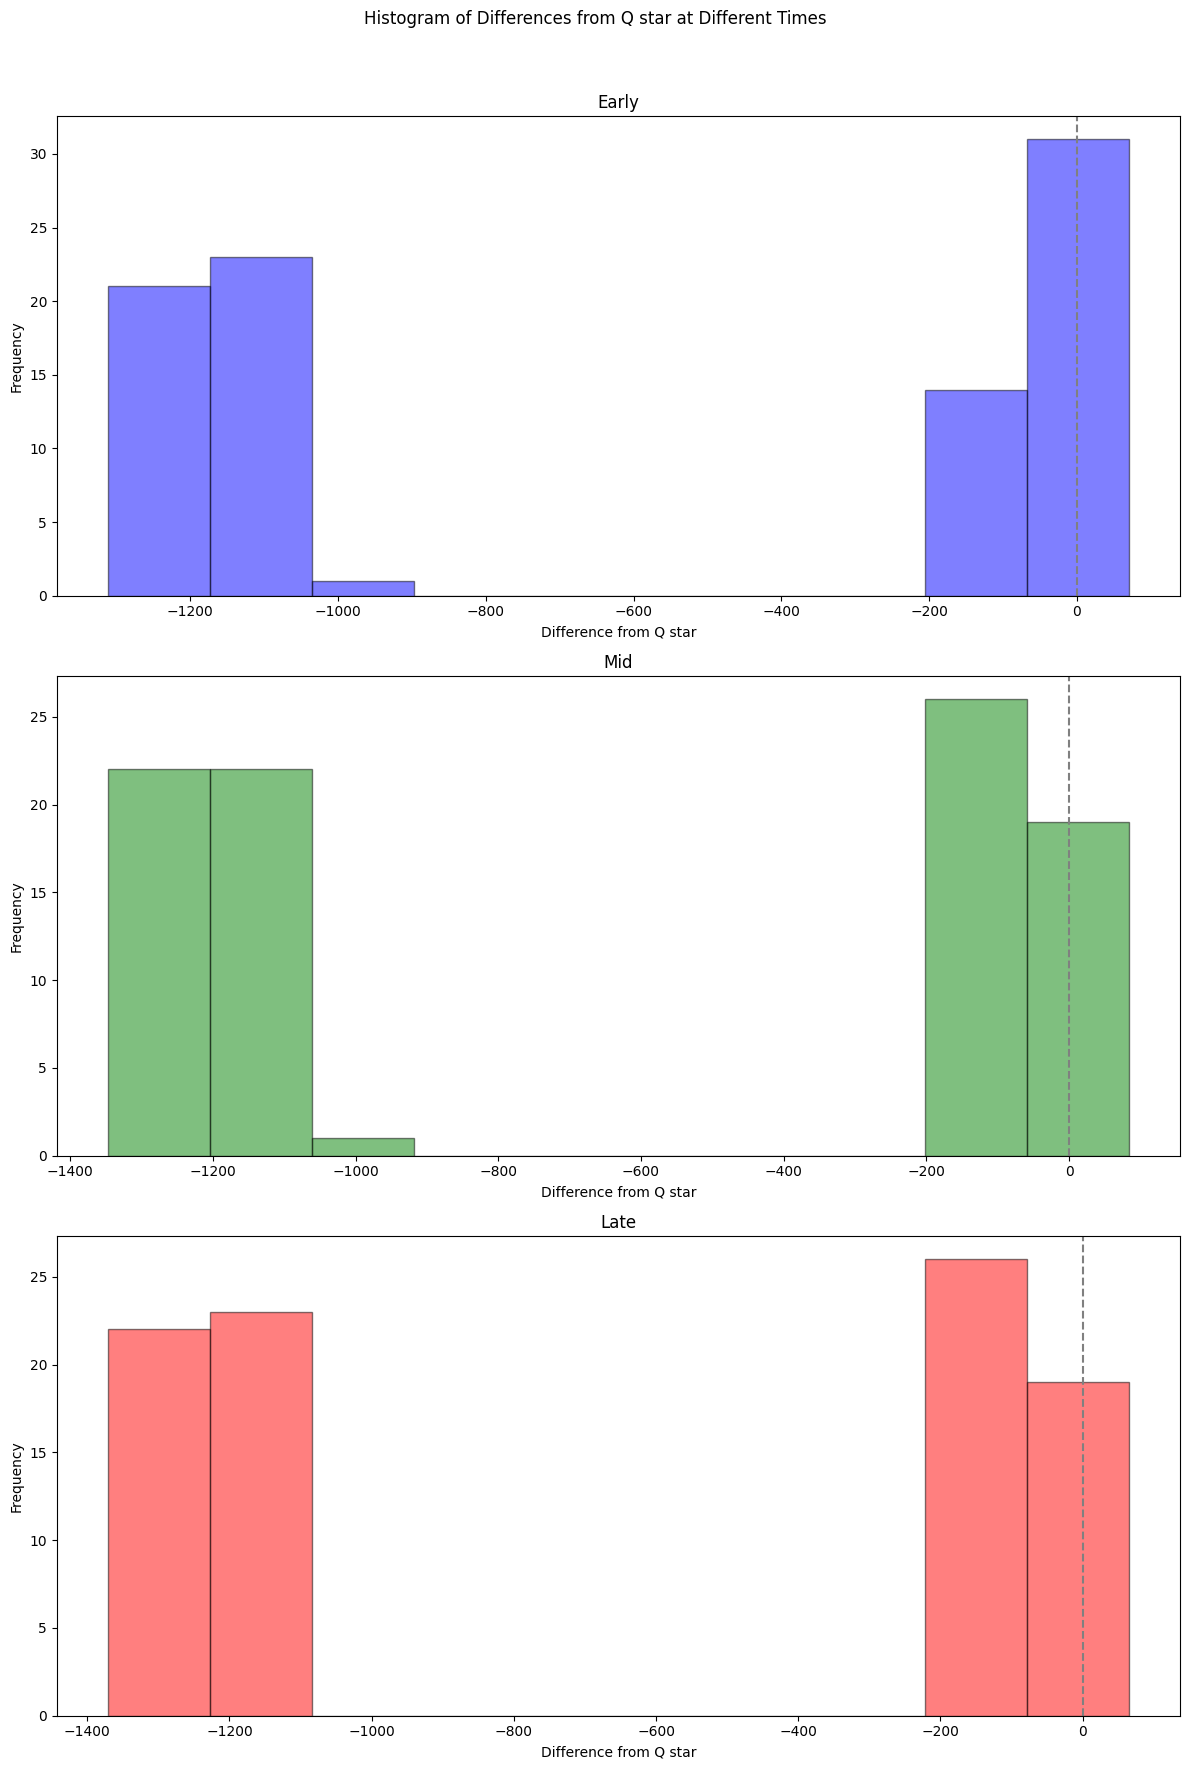

In [1495]:
# 繪製直方圖
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# 早期
axes[0].hist(early_diff, bins=10, alpha=0.5, color="blue", edgecolor="black")
axes[0].axvline(0, color="grey", linestyle="--")
axes[0].set_title("Early")
axes[0].set_xlabel("Difference from Q star")
axes[0].set_ylabel("Frequency")

# 中期
axes[1].hist(mid_diff, bins=10, alpha=0.5, color="green", edgecolor="black")
axes[1].axvline(0, color="grey", linestyle="--")
axes[1].set_title("Mid")
axes[1].set_xlabel("Difference from Q star")
axes[1].set_ylabel("Frequency")

# 晚期
axes[2].hist(late_diff, bins=10, alpha=0.5, color="red", edgecolor="black")
axes[2].axvline(0, color="grey", linestyle="--")
axes[2].set_title("Late")
axes[2].set_xlabel("Difference from Q star")
axes[2].set_ylabel("Frequency")

fig.suptitle("Histogram of Differences from Q star at Different Times")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Strategies utils


## Validation

### Validate the r and R

In [1496]:
# import gurobipy as gp
# from gurobipy import GRB

# # 初始化模型
# # model = gp.Model("Test_r_R_relationship")
# model = gp.Model(env=env)

# # 設定參數
# K = 4  # 候選數量
# i = 0  # 單個 i 的例子

# # 定義變數
# r_vars = model.addVars(K, lb=0.0, ub=1.0, name="r_vars")  # r_{i,k}
# R_vars = model.addVars(K, vtype=GRB.BINARY, name="R_vars")  # R_{i,k}
# max_r_helper = model.addVar(lb=0.0, ub=1.0, name="max_r_helper")  # 最大值輔助變數

# # 假設 exp_tau_vars 是已知的輸入數值
# exp_tau_vars = [0.1, 0.3, 0.5, 0.2]  # 例子數值

# # 限制式 1: 定義 r_vars 與 exp_tau_vars 的關係
# for k in range(K):
#     model.addConstr(
#         r_vars[k] * sum(exp_tau_vars) == exp_tau_vars[k],
#         name=f"softmax_relation_{k}",
#     )

# # 限制式 2: 確保 r_vars 的加總為 1
# model.addConstr(gp.quicksum(r_vars[k] for k in range(K)) == 1, name="sum_r_constraint")

# # 限制式 3: 找出 r_vars 中的最大值
# model.addGenConstrMax(
#     max_r_helper, [r_vars[k] for k in range(K)], name="max_r_constraint"
# )

# # 限制式 4: 確保 R_vars 對應到最大值
# for k in range(K):
#     model.addGenConstrIndicator(
#         R_vars[k], 1, r_vars[k] == max_r_helper, name=f"indicator_R_{k}"
#     )

# # 限制式 5: 確保僅有一個 R_vars[k] 為 1
# model.addConstr(
#     gp.quicksum(R_vars[k] for k in range(K)) == 1, name="unique_R_constraint"
# )

# # 設定目標函數（範例：最大化 max_r_helper）
# model.setObjective(max_r_helper, GRB.MAXIMIZE)

# # 求解模型
# model.optimize()

# # 輸出結果
# if model.Status == GRB.OPTIMAL:
#     print("Optimal solution found!")
#     print(f"max_r_helper: {max_r_helper.X}")
#     print("r_vars:")
#     for k in range(K):
#         print(f"  r_vars[{k}]: {r_vars[k].X}")
#     print("R_vars:")
#     for k in range(K):
#         print(f"  R_vars[{k}]: {R_vars[k].X}")
# else:
#     print("No optimal solution found.")

檢驗結果：目前的寫法可以成功讓 r 與 R 的關係實現



## S0 - One-time Procurement


In [1497]:
def one_time_procurement(Q_star, demand_df, cost, price, salvage_value):

    all_losses = []
    all_lefts = []
    all_operation_profits = []
    all_profits = []

    for i, row in demand_df.iterrows():
        inventory = Q_star
        losses = []
        lefts = []
        daily_operation_profits = []
        daily_profits = []
        total_sold = 0  # 追蹤總售出量
        total_lost = 0  # 追蹤總丟失量

        # print("=" * 50)
        # print(
        #     f"Processing row {i+1}/{len(demand_df)} with initial inventory Q_star={Q_star}"
        # )
        # print("=" * 50)

        for day, demand in enumerate(row):
            sales = min(inventory, demand)
            loss = max(demand - inventory, 0)
            left = max(inventory - sales, 0)
            total_sold += sales
            total_lost += loss

            inventory -= sales

            # print("-" * 50)
            # print(f"Day {day+1}")
            # print(f"Demand      : {demand}")
            # print(f"Sales       : {sales}")
            # print(f"Loss        : {loss}")
            # print(f"Left        : {left}")
            # print(f"Inventory   : {inventory}")
            # print("-" * 50)

            if day == len(row) - 1:
                left_penalty_cost = (cost - salvage_value) * left
                lefts.append(left)
                # print(f"End of period: Left Penalty Cost = {left_penalty_cost}")
                # print("-" * 50)
            else:
                left_penalty_cost = 0

        operation_profit = (price - cost) * total_sold
        profit = operation_profit - left_penalty_cost - (price - cost) * total_lost

        # print("=" * 50)
        # print(f"Row {i+1} Summary")
        # print(f"Total Sold         : {total_sold}")
        # print(f"Total Lost         : {total_lost}")
        # print(f"Operation Profit   : {operation_profit}")
        # print(f"Profit             : {profit}")
        # print("=" * 50)

        all_losses.append(total_lost)
        all_lefts.append(sum(lefts))
        all_operation_profits.append(operation_profit)
        all_profits.append(profit)

    avg_losses = np.mean(all_losses)
    avg_lefts = np.mean(all_lefts)
    avg_operation_profits = np.mean(all_operation_profits)
    avg_profits = np.mean(all_profits)

    # print("=" * 50)
    # print("Overall Summary")
    # print(f"Average Losses           : {avg_losses}")
    # print(f"Average Lefts            : {avg_lefts}")
    # print(f"Average Operation Profits: {avg_operation_profits}")
    # print(f"Average Profits          : {avg_profits}")
    # print("=" * 50)

    stimulation_df = pd.DataFrame(
        {
            "losses": all_losses,
            "lefts": all_lefts,
            "operation_profits": all_operation_profits,
            "profits": all_profits,
        }
    )

    return avg_losses, avg_lefts, avg_profits, avg_operation_profits, stimulation_df

## S1 - Grid for Fixed F & Fixed Rk


In [1498]:
def cal_fixed_F_fixed_R(
    Q_star, assigned_F, assigned_R, demand_df, cost, price, salvage_value, Qk_hat_df
):
    all_losses = []
    all_lefts = []
    all_left0s = []
    all_left1s = []
    all_operation_profits = []
    all_profits = []
    all_q0s = []
    all_q1s = []

    Q0 = assigned_F * Q_star  # 期初庫存

    # print(f"\n")
    # print(f"====" * 10)
    # print(f"\n")

    for i, row in demand_df.iterrows():

        # 第一階段計算
        total_sold_0 = min(Q0, row[: assigned_R + 1].sum())  # 第一階段售出量
        left_0 = max(Q0 - total_sold_0, 0)  # 第一階段剩餘
        lost_0 = max((row[: assigned_R + 1].sum() - Q0), 0)

        # 第二階段開始補貨，根據指定的 R
        Qk_hat = Qk_hat_df.iloc[i, assigned_R]
        Q1 = max((Qk_hat - Q0), 0)  # 二次訂貨量
        total_sold_1 = min(Q1 + left_0, row[assigned_R + 1 :].sum())  # 第二階段售出量
        left_1 = max((Q1 + left_0) - total_sold_1, 0)  # 第二階段剩餘
        lost_1 = max(row[assigned_R + 1 :].sum() - (Q1 + left_0), 0)

        # 統計
        total_sold = total_sold_0 + total_sold_1
        total_lost = lost_0 + lost_1
        total_left = left_0 + left_1

        # 計算運營利潤和總利潤
        operation_profit = (price - cost) * total_sold

        # left_penalty_cost = (cost - salvage_value) * left_1
        left_penalty_cost = (cost - salvage_value) * total_left
        lost_penalty_cost = (price - cost) * total_lost

        profit = operation_profit - left_penalty_cost - lost_penalty_cost

        all_losses.append(total_lost)
        all_lefts.append(total_left)
        all_operation_profits.append(operation_profit)
        all_profits.append(profit)
        all_q0s.append(Q0)
        all_q1s.append(Q1)
        all_left0s.append(left_0)
        all_left1s.append(left_1)

        # print(f"這是第 {i+1} 筆模擬資料\n")
        # print(f"F: {assigned_F}, R: {assigned_R+2}")
        # print(f"Q_star 為 {Q_star}")
        # print(f"期初庫存 Q0: {Q0}")
        # print(f"重新估計量 Qk_hat: {Qk_hat}")
        # print(f"訂貨量 Q1 為 {Q1}\n")

        # print(
        #     f"第一階段：期初庫存 Q0: {Q0}，需求量為 {row[:assigned_R + 1].sum()}，Sold_0 為 {total_sold_0}，Left_0 為 {left_0}，Lost_0 為 {lost_0}"
        # )
        # print(
        #     f"第二階段：期初庫存 Q1+left_0 為 {Q1+left_0}，需求量為 {row[assigned_R + 1:].sum()}，Sold_1 為 {total_sold_1}，Left_1 為 {left_1}，Lost_1 為 {lost_1}\n"
        # )
        # print(
        #     f"統計結果：Sold 為 {total_sold}, Lost 為 {total_lost} Left_Penalty_Cost 為 {left_penalty_cost}，Lost_Penalty_Cost 為 {lost_penalty_cost}，Profit 為 {profit}"
        # )
        # print("----" * 10)

    result_df = {
        "R(T)": assigned_R + 2,
        "F": assigned_F,
        "Q0": all_q0s,
        "Q1": all_q1s,
        "average_profits": np.mean(all_profits),
        "average_losses": np.mean(all_losses),
        "average_lefts": np.mean(all_lefts),
        "average_operation_profits": np.mean(all_operation_profits),
    }

    stimulation_result = {
        "R(T)": assigned_R + 2,
        "F": assigned_F,
        "profits": all_profits,
        "losses": all_losses,
        "lefts": all_lefts,
        "Left0s": all_left0s,
        "Left1s": all_left1s,
        "operation_profits": all_operation_profits,
        "Q0": all_q0s,
        "Q1": all_q1s,
    }

    return result_df, stimulation_result

In [1499]:
def grid_fixed_F_fixed_R(
    assigned_Ts,
    assigned_Fs,
    cost,
    price,
    salvage_value,
    Qk_hat_df,
    demand_df_train,
    Q_star,
):

    results_list = []
    max_profit = None
    max_profit_stimulation_result = {}

    for assigned_T in assigned_Ts:
        for assigned_F in assigned_Fs:
            assigned_R = assigned_T - 2
            mean_result, stimulation_result = cal_fixed_F_fixed_R(
                Q_star,
                assigned_F,
                assigned_R,
                demand_df_train,
                cost,
                price,
                salvage_value,
                Qk_hat_df,
            )
            results_list.append(mean_result)

            if max_profit is None or max_profit < mean_result["average_profits"]:
                # print(
                #     f"max_profit is changed from {max_profit} to {mean_result['average_profits']}"
                # )
                max_profit = mean_result["average_profits"]
                max_profit_stimulation_result = stimulation_result

    results_df_1 = pd.DataFrame(results_list).sort_values(
        by="average_profits", ascending=False
    )

    return results_df_1, pd.DataFrame(max_profit_stimulation_result)

## S8 - Grid for Fixed F & Fixed Rk(with holding cost)


In [1500]:
def cal_fixed_F_fixed_R_with_holding_cost(
    Q_star,
    assigned_F,
    assigned_R,
    demand_df,
    cost,
    price,
    salvage_value,
    Qk_hat_df,
    holding_cost,
):
    all_losses = []
    all_lefts = []
    all_operation_profits = []
    all_profits = []
    all_q0s = []
    all_q1s = []
    all_holding_costs_0 = []
    all_holding_costs_1 = []
    all_left0s = []
    all_left1s = []
    all_lost0s = []
    all_lost1s = []

    Q0 = assigned_F * Q_star  # 期初庫存

    # print(f"\n")
    # print(f"====" * 10)
    # print(f"\n")

    for i, row in demand_df.iterrows():

        # 第一階段計算
        total_sold_0 = min(Q0, row[: assigned_R + 1].sum())  # 第一階段售出量
        left_0 = max(Q0 - total_sold_0, 0)  # 第一階段剩餘
        lost_0 = max(row[: assigned_R + 1].sum() - Q0, 0)

        # 第二階段開始補貨，根據指定的 R
        Qk_hat = Qk_hat_df.iloc[i, assigned_R]
        Q1 = max((Qk_hat - Q0), 0)  # 二次訂貨量
        total_sold_1 = min(Q1 + left_0, row[assigned_R + 1 :].sum())  # 第二階段售出量
        left_1 = max((Q1 + left_0) - total_sold_1, 0)  # 第二階段剩餘
        lost_1 = max(row[assigned_R + 1 :].sum() - (Q1 + left_0), 0)

        # 統計
        total_sold = total_sold_0 + total_sold_1
        total_lost = lost_0 + lost_1

        # 計算 holding_cost
        """
        今天 T = 10, 假設 R = 5 (此時 assigned_R=3), 此時:
        第一階段是 T=1~4 -> 高為 R-1 = (assigned_R+2) - 1
        第二階段是 T=5~10 -> 高為 T - R = T - (assigned_R+2)
        """

        first_holding_cost = (Q0 + left_0 + Q1) * ((assigned_R + 2) - 1) / 2
        # T = 1 ~ R+1, R+1 才是代表 R(T)
        second_holding_cost = (Q1 + left_0 + left_1) * (T - (assigned_R + 2)) / 2
        # T = R+1 ~ T
        holding_penalty = holding_cost * (first_holding_cost + second_holding_cost)

        # 計算運營利潤和總利潤
        operation_profit = (price - cost) * total_sold
        left_penalty_cost = (cost - salvage_value) * left_1
        lost_penalty_cost = (price - cost) * total_lost
        profit = (
            operation_profit - left_penalty_cost - lost_penalty_cost - holding_penalty
        )

        all_losses.append(total_lost)
        all_lefts.append(left_1)
        all_operation_profits.append(operation_profit)
        all_profits.append(profit)
        all_q0s.append(Q0)
        all_q1s.append(Q1)
        all_holding_costs_0.append(first_holding_cost)
        all_holding_costs_1.append(second_holding_cost)
        all_left0s.append(left_0)
        all_left1s.append(left_1)
        all_lost0s.append(lost_0)
        all_lost1s.append(lost_1)

        # print(f"這是第 {i+1} 筆模擬資料\n")
        # print(f"F: {assigned_F}, R: {assigned_R+2}")
        # print(f"Q_star 為 {Q_star}")
        # print(f"期初庫存 Q0: {Q0}")
        # print(f"重新估計量 Qk_hat: {Qk_hat}")
        # print(f"訂貨量 Q1 為 {Q1}\n")

        # print(
        #     f"第一階段：期初庫存 Q0: {Q0}，需求量為 {row[:assigned_R + 1].sum()}，Sold_0 為 {total_sold_0}，Left_0 為 {left_0}，Lost_0 為 {lost_0}, first_holding_cost 為 {first_holding_cost}"
        # )
        # print(
        #     f"第二階段：期初庫存 Q1+left_0 為 {Q1+left_0}，需求量為 {row[assigned_R + 1:].sum()}，Sold_1 為 {total_sold_1}，Left_1 為 {left_1}，Lost_1 為 {lost_1}, second_holding_cost 為 {second_holding_cost}\n"
        # )
        # print(
        #     f"統計結果：Sold 為 {total_sold}, Lost 為 {total_lost} Left_Penalty_Cost 為 {left_penalty_cost}，Lost_Penalty_Cost 為 {lost_penalty_cost}，holding_penalty 為 {holding_penalty}，Profit 為 {profit}"
        # )
        # print("----" * 10)

    result_df = {
        "R(T)": assigned_R + 2,
        "F": assigned_F,
        "Q0": all_q0s,
        "Q1": all_q1s,
        "average_profits": np.mean(all_profits),
        "average_losses": np.mean(all_losses),
        "average_lefts": np.mean(all_lefts),
        "average_operation_profits": np.mean(all_operation_profits),
    }

    stimulation_result = {
        "R(T)": assigned_R + 2,
        "F": assigned_F,
        "profits": all_profits,
        "losses": all_losses,
        "lefts": all_lefts,
        "operation_profits": all_operation_profits,
        "Q0": all_q0s,
        "Q1": all_q1s,
        "hc0": all_holding_costs_0,
        "hc1": all_holding_costs_1,
        "Left0s": all_left0s,
        "Left1s": all_left1s,
        "lost0s": all_lost0s,
        "lost1s": all_lost1s,
    }

    return result_df, stimulation_result

In [1501]:
def grid_fixed_F_fixed_R_with_holding_cost(
    assigned_Ts,
    assigned_Fs,
    cost,
    price,
    salvage_value,
    holding_cost,
    Qk_hat_df,
    demand_df_train,
    Q_star,
):

    results_list = []
    max_profit = None
    max_profit_stimulation_result = {}

    for assigned_T in assigned_Ts:
        for assigned_F in assigned_Fs:
            assigned_R = assigned_T - 2
            mean_result, stimulation_result = cal_fixed_F_fixed_R_with_holding_cost(
                Q_star,
                assigned_F,
                assigned_R,
                demand_df_train,
                cost,
                price,
                salvage_value,
                Qk_hat_df,
                holding_cost,
            )
            results_list.append(mean_result)

            if max_profit is None or max_profit < mean_result["average_profits"]:
                # print(
                #     f"max_profit is changed from {max_profit} to {mean_result['average_profits']}"
                # )
                max_profit = mean_result["average_profits"]
                max_profit_stimulation_result = stimulation_result

    results_df_1 = pd.DataFrame(results_list).sort_values(
        by="average_profits", ascending=False
    )

    return results_df_1, pd.DataFrame(max_profit_stimulation_result)

## S2 - Grid for Fixed Rk & Flexible F


In [1502]:
# def cal_flexible_F_fixed_R(
#     assigned_R,
#     salvage_value,
#     cost,
#     price,
#     Q_star,
#     demand_df_train,
#     Qk_hat_df,
#     training_df,
# ):
#     # print(
#     #     f"+++++++++++++++++++++++++++++++++++++++ THis is R={assigned_R} +++++++++++++++++++++++++++++++++++++++++++++++++"
#     # )
#     with gp.Model("profit_maximization", env=env) as model:
#         model.setParam("OutputFlag", True)
#         model.setParam("Threads", THREADS)
#         model.setParam("MIPGap", MIPGAP)
#         model.setParam("TimeLimit", TIME_LIMIT)

#         # ======================= Decision Variables =======================
#         alphas = model.addVars(
#             features_num + 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="alphas"
#         )
#         Sold_0s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_0")
#         Sold_1s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_1")
#         Lost_0s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_0")
#         Lost_1s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_1")
#         Left_1s = model.addVars(len(demand_df_train), lb=0.0, name="Left_1")

#         f_vars = model.addVars(
#             len(demand_df_train), lb=-GRB.INFINITY, ub=GRB.INFINITY, name="f_var"
#         )
#         F_vars = model.addVars(len(demand_df_train), lb=0, ub=1, name="Fraction")

#         Q0_vars = model.addVars(
#             len(demand_df_train), lb=0.0, ub=(Q_star + 1), name="Q0_var"
#         )
#         Q1_vars = model.addVars(len(Qk_hat_df), lb=0.0, name="Q1_var")

#         profits_vars = model.addVars(
#             len(demand_df_train), lb=-GRB.INFINITY, name="profits_vars"
#         )

#         # ======================= Model Constraints =======================
#         for i, row in demand_df_train.iterrows():
#             demand_row = demand_df_train.iloc[i]
#             Qk_hat_df_row = Qk_hat_df.iloc[i].tolist()
#             X_data = training_df.iloc[i].tolist()
#             X_data.append(1)

#             model.addConstr(F_vars[i] >= 0, name=f"Fraction_lower_bound_{i}")
#             model.addConstr(F_vars[i] <= 1, name=f"Fraction_upper_bound_{i}")

#             # Calculate F using logistic regression
#             model.addConstr(
#                 f_vars[i]
#                 == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
#             )
#             model.addGenConstrLogistic(xvar=f_vars[i], yvar=F_vars[i])

#             # Calculate initial order quantity
#             model.addConstr(Q0_vars[i] == F_vars[i] * Q_star)

#             # Define demand variables for before and after reorder point
#             total_demand_before_R = demand_row[: assigned_R + 1].sum()
#             total_demand_after_R = demand_row[assigned_R + 1 :].sum()

#             # Calculate first period sales and lost sales
#             model.addGenConstrMin(
#                 Sold_0s[i],
#                 [total_demand_before_R, Q0_vars[i]],
#                 name=f"min_sales_constr_{i}",
#             )

#             # Calculate lost sales
#             Lost_0_expr = total_demand_before_R - Q0_vars[i]
#             Lost_0_var = model.addVar(lb=-GRB.INFINITY, name=f"Lost_0_expr_{i}")
#             model.addConstr(Lost_0_var == Lost_0_expr)
#             model.addGenConstrMax(
#                 Lost_0s[i], [Lost_0_var, 0], name=f"max_lost_constr_{i}"
#             )

#             # Calculate inventory left after first period
#             left_0 = Q0_vars[i] - Sold_0s[i]

#             # Calculate Q1 based on reorder point estimate
#             Q_hat = Qk_hat_df_row[assigned_R]
#             Q_hat_adjusted = Q_hat - Q0_vars[i]
#             Q_hat_adjusted_var = model.addVar(
#                 lb=-GRB.INFINITY, name=f"Q_hat_adjusted_{i}"
#             )
#             model.addConstr(Q_hat_adjusted_var == Q_hat_adjusted)

#             model.addGenConstrMax(
#                 Q1_vars[i], [Q_hat_adjusted_var, 0], name=f"max_Q1_constr_{i}"
#             )

#             # Calculate second period sales and lost sales
#             total_stock_second_period = Q1_vars[i] + left_0
#             total_stock_second_period_var = model.addVar(
#                 lb=0, name=f"total_stock_second_period_{i}"
#             )
#             model.addConstr(total_stock_second_period_var == total_stock_second_period)

#             model.addGenConstrMin(
#                 Sold_1s[i],
#                 [total_demand_after_R, total_stock_second_period_var],
#                 name=f"min_sales2_constr_{i}",
#             )

#             # Calculate second period lost sales
#             Lost_1_expr = total_demand_after_R - total_stock_second_period_var
#             Lost_1_var = model.addVar(lb=-GRB.INFINITY, name=f"Lost_1_expr_{i}")
#             model.addConstr(Lost_1_var == Lost_1_expr)

#             model.addGenConstrMax(
#                 Lost_1s[i], [Lost_1_var, 0], name=f"max_lost2_constr_{i}"
#             )

#             model.addConstr(Left_1s[i] == total_stock_second_period_var - Sold_1s[i])

#             # # Calculate holding costs directly in profit equation
#             # holding_cost_1 = (
#             #     (Q0_vars[i] + total_stock_second_period) * (assigned_R + 2 - 1) / 2
#             # )
#             # holding_cost_2 = (
#             #     (total_stock_second_period + Left_1s[i]) * (T - (assigned_R + 2)) / 2
#             # )

#             # Calculate profit
#             model.addConstr(
#                 profits_vars[i]
#                 == (
#                     (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue
#                     - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
#                     - (cost - salvage_value) * Left_1s[i]  # Salvage cost
#                     # - holding_cost * (holding_cost_1 + holding_cost_2)  # Holding cost
#                 )
#             )

#         # Set objective
#         model.setObjective(
#             gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
#             GRB.MAXIMIZE,
#         )

#         model.write("s2_model_debug.lp")
#         model.write("s2_model.mps")

#         # Solve model
#         try:
#             model.optimize()

#             if model.status == GRB.OPTIMAL or model.status == GRB.TIME_LIMIT:
#                 print(f"Model status: {model.status}")

#                 # Collect results
#                 alpha_values = np.array([alpha.X for alpha in alphas.values()])

#                 results = {
#                     "losses": [],
#                     "lefts": [],
#                     "profits": [],
#                     "operation_profits": [],
#                     "Q0s": [],
#                     "Q1s": [],
#                     "Fs": [],
#                 }

#                 for i in range(len(demand_df_train)):
#                     sold0, sold1 = Sold_0s[i].X, Sold_1s[i].X
#                     lost0, lost1 = Lost_0s[i].X, Lost_1s[i].X
#                     left1 = Left_1s[i].X
#                     left0 = Q0_vars[i].X - Sold_0s[i].X

#                     # Record results
#                     results["losses"].append(lost0 + lost1)
#                     results["lefts"].append(left1)
#                     # results["lefts"].append(left0)

#                     results["operation_profits"].append(
#                         (price - cost) * (sold0 + sold1)
#                     )
#                     results["profits"].append(profits_vars[i].X)
#                     results["Q0s"].append(Q0_vars[i].X)
#                     results["Q1s"].append(Q1_vars[i].X)
#                     results["Fs"].append(F_vars[i].X)

#                     # print(f"\nObservation {i+1}:")
#                     # print(f"Reorder day: {assigned_R}")
#                     # print(f"Profit: {profits_vars[i].X:.2f}")

#                 return (
#                     [assigned_R] * len(demand_df_train),  # Fixed R for all observations
#                     results["losses"],
#                     results["lefts"],
#                     results["profits"],
#                     results["operation_profits"],
#                     alpha_values,
#                     results["Fs"],
#                     results["Q0s"],
#                     results["Q1s"],
#                 )

#             else:
#                 print("===================== 找不到最佳解 ==================")
#                 print(f"Model is feasible. Status: {model.status}")
#                 model.computeIIS()
#                 model.write("model.ilp")

#                 for constr in model.getConstrs():
#                     if constr.IISConstr:
#                         print(f"導致不可行的約束： {constr.constrName}")

#                 for var in model.getVars():
#                     if var.IISLB > 0 or var.IISUB > 0:
#                         print(
#                             f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
#                         )

#                 return None

#         except gp.GurobiError as e:
#             print(f"Error code {str(e.errno)}: {str(e)}")
#             return None

In [1503]:
# def grid_flexible_F_fixed_R(
#     assigned_Ts,
#     salvage_value,
#     cost,
#     price,
#     Q_star,
#     demand_df_train,
#     Qk_hat_df_train,
#     training_df,
# ):
#     results_dict = {
#         "R(T)": [],
#         "R": [],
#         "average_profits": [],
#         "average_losses": [],
#         "average_lefts": [],
#         "average_operation_profits": [],
#         "alpha_values": [],
#         "F_vars": [],
#         "Q0_vars": [],
#         "Q1_vars": [],
#     }

#     max_profit = None
#     max_profit_stimulation_result = {}

#     for assigned_T in assigned_Ts:
#         assigned_R = assigned_T - 2
#         result = cal_flexible_F_fixed_R(
#             assigned_R=assigned_R,
#             salvage_value=salvage_value,
#             cost=cost,
#             price=price,
#             Q_star=Q_star,
#             demand_df_train=demand_df_train,
#             Qk_hat_df=Qk_hat_df_train,
#             training_df=training_df,
#         )

#         if result is None:
#             print(f"模型沒有最佳解")
#             continue

#         (
#             all_Rs,
#             losses,
#             lefts,
#             profits,
#             operation_profits,
#             alpha_values,
#             F_vars,
#             Q0_vars,
#             Q1_vars,
#         ) = result

#         # 計算平均值
#         average_losses = sum(losses) / len(losses) if losses else 0
#         average_lefts = sum(lefts) / len(lefts) if lefts else 0
#         average_profits = sum(profits) / len(profits) if profits else 0
#         average_operation_profits = (
#             sum(operation_profits) / len(operation_profits) if operation_profits else 0
#         )

#         # 將結果存儲到字典中
#         results_dict["R(T)"].append(assigned_T)
#         results_dict["R"].append(all_Rs)
#         results_dict["average_losses"].append(average_losses)
#         results_dict["average_lefts"].append(average_lefts)
#         results_dict["average_profits"].append(average_profits)
#         results_dict["average_operation_profits"].append(average_operation_profits)
#         results_dict["alpha_values"].append(alpha_values)
#         results_dict["F_vars"].append(F_vars)
#         results_dict["Q0_vars"].append(Q0_vars)
#         results_dict["Q1_vars"].append(Q1_vars)

#         # print(f"The average profits is {average_profits}")

#         if max_profit is None or max_profit < average_profits:
#             # print(f"max_profit is changed from {max_profit} to {average_profits}")
#             max_profit = average_profits
#             max_profit_stimulation_result = {
#                 "R": all_Rs,
#                 "F": F_vars,
#                 "profits": profits,
#                 "losses": losses,
#                 "lefts": lefts,
#                 "operation_profits": operation_profits,
#                 "Q0": Q0_vars,
#                 "Q1": Q1_vars,
#             }

#     return pd.DataFrame(results_dict).sort_values(
#         by="average_profits", ascending=False
#     ), pd.DataFrame(max_profit_stimulation_result)

## S17 - Grid for Fixed Rk & Flexible F with lasso


In [1504]:
def cal_flexible_F_fixed_R(
    assigned_R,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
    lambda_alpha,
):
    print(
        f"+++++++++++++++++++++++++++++++++++++++ THis is R={assigned_R} +++++++++++++++++++++++++++++++++++++++++++++++++"
    )
    with gp.Model("profit_maximization", env=env) as model:
        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)
        model.setParam("NonConvex", 2)
        model.setParam("IntFeasTol", 1e-9)
        model.setParam("NumericFocus", 3)

        # ======================= Decision Variables =======================
        alphas = model.addVars(
            features_num + 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="alphas"
        )
        abs_alphas = model.addVars(alphas.keys(), lb=0, name="abs_alpha")

        # 進行 L1 正則化處理：alphas
        for i in alphas.keys():
            model.addConstr(abs_alphas[i] >= alphas[i])
            model.addConstr(abs_alphas[i] >= -alphas[i])

        Sold_0s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_0")
        Left_0s = model.addVars(len(demand_df_train), lb=0.0, name="Left_0")
        Lost_0s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_0")

        Sold_1s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_1")
        Left_1s = model.addVars(len(demand_df_train), lb=0.0, name="Left_1")
        Lost_1s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_1")

        f_vars = model.addVars(
            len(demand_df_train), lb=-GRB.INFINITY, ub=GRB.INFINITY, name="f_var"
        )
        F_vars = model.addVars(len(demand_df_train), lb=0, ub=1, name="Fraction")

        Q0_vars = model.addVars(
            len(demand_df_train), lb=0.0, ub=(Q_star + 1), name="Q0_var"
        )
        Q1_vars = model.addVars(len(Qk_hat_df), lb=0.0, name="Q1_var")

        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            lb=0,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        profits_vars = model.addVars(
            len(demand_df_train), lb=-GRB.INFINITY, name="profits_vars"
        )

        # ======================= Model Constraints =======================
        for i, row in demand_df_train.iterrows():
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i].tolist()
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            model.addConstr(F_vars[i] >= 0, name=f"Fraction_lower_bound_{i}")
            model.addConstr(F_vars[i] <= 1, name=f"Fraction_upper_bound_{i}")

            # Calculate F using logistic regression
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], options="FuncNonlinear=1"
            )

            # Calculate initial order quantity
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star)

            # Define demand variables for before and after reorder point
            total_demand_before_R = demand_row[: assigned_R + 1].sum()
            total_demand_after_R = demand_row[assigned_R + 1 :].sum()

            # 定義輔助變數
            Left_0_aux = model.addVar(lb=-GRB.INFINITY, name=f"Left_0_aux_{i}")
            Lost_0_aux = model.addVar(lb=-GRB.INFINITY, name=f"Lost_0_aux_{i}")
            Left_1_aux = model.addVar(lb=-GRB.INFINITY, name=f"Left_0_aux_{i}")
            Lost_1_aux = model.addVar(lb=-GRB.INFINITY, name=f"Lost_0_aux_{i}")

            # 計算 Sold_0，為 total_demand_up_to_k_minus_1_vars 和 Q0_vars 的最小值
            model.addGenConstrMin(
                Sold_0s[i],
                [total_demand_before_R, Q0_vars[i]],
                name=f"Constr_Sold_0_min_{i}",
            )

            # 計算 Left_0，為 max(Q0_vars[i] - Sold_0s[i], 0)
            model.addConstr(
                Left_0_aux == Q0_vars[i] - Sold_0s[i],
                name=f"Constr_Left_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_0s[i], [Left_0_aux, 0], name=f"Constr_Left_0_max_{i}"
            )

            # 計算 Lost_0，為 max(total_demand_before_R - Q0_vars[i], 0)
            model.addConstr(
                Lost_0_aux == total_demand_before_R - Q0_vars[i],
                name=f"Constr_Lost_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_0s[i], [Lost_0_aux, 0], name=f"Constr_Lost_0_max_{i}"
            )

            # Calculate Q1 based on reorder point estimate
            Q_hat = Qk_hat_df_row[assigned_R]
            Q_hat_adjusted = Q_hat - Q0_vars[i]
            Q_hat_adjusted_var = model.addVar(
                lb=-GRB.INFINITY, name=f"Q_hat_adjusted_{i}"
            )
            model.addConstr(Q_hat_adjusted_var == Q_hat_adjusted)

            model.addGenConstrMax(
                Q1_vars[i], [Q_hat_adjusted_var, 0], name=f"max_Q1_constr_{i}"
            )

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Constr_Q1_plus_left_{i}",
            )

            # 計算 Sold_1，為 total_demand_from_k_to_T_vars 和 Q1_plus_lefts 的最小值
            model.addGenConstrMin(
                Sold_1s[i],
                [total_demand_after_R, Q1_plus_lefts[i]],
                name=f"Constr_Sold_1_min_{i}",
            )

            # 計算 Left_1，為 max(Q1_plus_lefts[i] - Sold_1s[i], 0)
            model.addConstr(
                Left_1_aux == Q1_plus_lefts[i] - Sold_1s[i],
                name=f"Constr_Left_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_1s[i], [Left_1_aux, 0], name=f"Constr_Left_1_max_{i}"
            )

            # 計算 Lost_1，為 max(total_demand_after_R - Q1_plus_lefts[i], 0)
            model.addConstr(
                Lost_1_aux == total_demand_after_R - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_1s[i], [Lost_1_aux, 0], name=f"Constr_Lost_1_max_{i}"
            )

            # # Calculate holding costs directly in profit equation
            # holding_cost_1 = (
            #     (Q0_vars[i] + total_stock_second_period) * (assigned_R + 2 - 1) / 2
            # )
            # holding_cost_2 = (
            #     (total_stock_second_period + Left_1s[i]) * (T - (assigned_R + 2)) / 2
            # )

            # model.addConstr(
            #     profits_vars[i]
            #     == (
            #         (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
            #         - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
            #         - (cost - salvage_value) * (Left_1s[i])  # left cost
            #     ),
            #     name=f"Profit_Constraint_{i}",
            # )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * (Left_0s[i] + Left_1s[i])  # left cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        # Set objective
        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train)))
            - lambda_alpha * gp.quicksum(abs_alphas[i] for i in abs_alphas.keys()),
            GRB.MAXIMIZE,
        )

        model.write("s17_model_debug.lp")
        model.write("s17_model.mps")

        # Solve model
        try:
            model.optimize()

            if model.status == GRB.OPTIMAL or model.status == GRB.TIME_LIMIT:
                print(f"Model status: {model.status}")

                # Collect results
                alpha_values = np.array([alpha.X for alpha in alphas.values()])

                results = {
                    "losses": [],
                    "lefts": [],
                    "profits": [],
                    "operation_profits": [],
                    "Q0s": [],
                    "Q1s": [],
                    "Fs": [],
                    "fs": [],
                }

                for i in range(len(demand_df_train)):
                    sold0, sold1 = Sold_0s[i].X, Sold_1s[i].X
                    lost0, lost1 = Lost_0s[i].X, Lost_1s[i].X
                    left1 = Left_1s[i].X
                    left0 = Left_0s[i].X
                    print(
                        f"Lost0: {lost0}, Lost1: {lost1}, Left0: {left0}, Left1: {left1}"
                    )

                    # Record results
                    results["losses"].append(lost0 + lost1)

                    # results["lefts"].append(left1)
                    results["lefts"].append(left0 + left1)

                    results["operation_profits"].append(
                        (price - cost) * (sold0 + sold1)
                    )
                    results["profits"].append(profits_vars[i].X)
                    results["Q1s"].append(Q1_vars[i].X)

                    # Check f
                    x_data = training_df.iloc[i].tolist()
                    x_data.append(1)
                    f_train, F_train, Q0_train = compute_f_F_Q(
                        x_data, alpha_values, Q_star
                    )
                    print(
                        f"f_train: {f_train}, F_train: {F_train}, Q0_train: {Q0_train}"
                    )
                    if (
                        truncate_to_2(f_train) == truncate_to_2(f_vars[i].X)
                        and truncate_to_2(F_train) == truncate_to_2(F_vars[i].X)
                        and truncate_to_2(Q0_train) == truncate_to_2(Q0_vars[i].X)
                    ):
                        print("f_train, F_train, Q0_train 都相等")
                        results["Q0s"].append(Q0_vars[i].X)
                        results["Fs"].append(F_vars[i].X)
                        results["fs"].append(f_vars[i].X)
                    else:
                        print(f"f_train, F_train, Q0_train 不相等")
                        results["Q0s"].append(-1)
                        results["Fs"].append(-1)
                        results["fs"].append(-1)
                        # results["Q0s"].append(Q0_vars[i].X)
                        # results["Fs"].append(F_vars[i].X)
                        # results["fs"].append(f_vars[i].X)
                return (
                    [assigned_R] * len(demand_df_train),  # Fixed R for all observations
                    results["losses"],
                    results["lefts"],
                    results["profits"],
                    results["operation_profits"],
                    alpha_values,
                    results["Fs"],
                    results["fs"],
                    results["Q0s"],
                    results["Q1s"],
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [1505]:
def grid_flexible_F_fixed_R(
    assigned_Ts,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df_train,
    training_df,
):
    results_dict = {
        "R(T)": [],
        "R": [],
        "average_profits": [],
        "average_losses": [],
        "average_lefts": [],
        "average_operation_profits": [],
        "alpha_values": [],
        "F_vars": [],
        "f_vars": [],
        "Q0_vars": [],
        "Q1_vars": [],
    }

    max_profit = None
    max_profit_stimulation_result = {}

    for assigned_T in assigned_Ts:
        assigned_R = assigned_T - 2
        result = cal_flexible_F_fixed_R(
            assigned_R=assigned_R,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_train=demand_df_train,
            Qk_hat_df=Qk_hat_df_train,
            training_df=training_df,
            lambda_alpha=LASSO_ALPHA,
        )

        if result is None:
            print(f"模型沒有最佳解")
            continue

        (
            all_Rs,
            losses,
            lefts,
            profits,
            operation_profits,
            alpha_values,
            F_vars,
            f_vars,
            Q0_vars,
            Q1_vars,
        ) = result

        # 計算平均值
        average_losses = sum(losses) / len(losses) if losses else 0
        average_lefts = sum(lefts) / len(lefts) if lefts else 0
        average_profits = sum(profits) / len(profits) if profits else 0
        average_operation_profits = (
            sum(operation_profits) / len(operation_profits) if operation_profits else 0
        )

        # 將結果存儲到字典中
        results_dict["R(T)"].append(assigned_T)
        results_dict["R"].append(all_Rs)
        results_dict["average_losses"].append(average_losses)
        results_dict["average_lefts"].append(average_lefts)
        results_dict["average_profits"].append(average_profits)
        results_dict["average_operation_profits"].append(average_operation_profits)
        results_dict["alpha_values"].append(alpha_values)
        results_dict["F_vars"].append(F_vars)
        results_dict["f_vars"].append(f_vars)
        results_dict["Q0_vars"].append(Q0_vars)
        results_dict["Q1_vars"].append(Q1_vars)

        # print(f"The average profits is {average_profits}")

        if max_profit is None or max_profit < average_profits:
            # print(f"max_profit is changed from {max_profit} to {average_profits}")
            max_profit = average_profits
            max_profit_stimulation_result = {
                "R": all_Rs,
                "F": F_vars,
                "f": f_vars,
                "profits": profits,
                "losses": losses,
                "lefts": lefts,
                "operation_profits": operation_profits,
                "Q0": Q0_vars,
                "Q1": Q1_vars,
            }

    return pd.DataFrame(results_dict).sort_values(
        by="average_profits", ascending=False
    ), pd.DataFrame(max_profit_stimulation_result)

## S13 - Grid for Fixed Rk & Optimized F

In [1506]:
def cal_optimized_F_fixed_R(
    assigned_R,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
):
    print(
        f"+++++++++++++++++++++++++++++++++++++++ THis is R={assigned_R} +++++++++++++++++++++++++++++++++++++++++++++++++"
    )
    with gp.Model("profit_maximization", env=env) as model:
        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Decision Variables =======================
        # alphas = model.addVars(
        #     features_num + 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="alphas"
        # )
        Sold_0s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_0")
        Sold_1s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_1")
        Lost_0s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_0")
        Lost_1s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_1")
        Left_1s = model.addVars(len(demand_df_train), lb=0.0, name="Left_1")

        # f_vars = model.addVars(
        #     len(demand_df_train), lb=-GRB.INFINITY, ub=GRB.INFINITY, name="f_var"
        # )
        F_vars = model.addVars(len(demand_df_train), lb=0, ub=1, name="Fraction")

        Q0_vars = model.addVars(
            len(demand_df_train), lb=0.0, ub=(Q_star + 1), name="Q0_var"
        )
        Q1_vars = model.addVars(len(Qk_hat_df), lb=0.0, name="Q1_var")

        profits_vars = model.addVars(
            len(demand_df_train), lb=-GRB.INFINITY, name="profits_vars"
        )

        # ======================= Model Constraints =======================
        for i, row in demand_df_train.iterrows():
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i].tolist()
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            model.addConstr(F_vars[i] >= 0, name=f"Fraction_lower_bound_{i}")
            model.addConstr(F_vars[i] <= 1, name=f"Fraction_upper_bound_{i}")

            # Calculate F using logistic regression
            # model.addConstr(
            #     f_vars[i]
            #     == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            # )
            # model.addGenConstrLogistic(xvar=f_vars[i], yvar=F_vars[i])

            # Calculate initial order quantity
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star)

            # Define demand variables for before and after reorder point
            total_demand_before_R = demand_row[: assigned_R + 1].sum()
            total_demand_after_R = demand_row[assigned_R + 1 :].sum()

            # Calculate first period sales and lost sales
            model.addGenConstrMin(
                Sold_0s[i],
                [total_demand_before_R, Q0_vars[i]],
                name=f"min_sales_constr_{i}",
            )

            # Calculate lost sales
            Lost_0_expr = total_demand_before_R - Q0_vars[i]
            Lost_0_var = model.addVar(lb=-GRB.INFINITY, name=f"Lost_0_expr_{i}")
            model.addConstr(Lost_0_var == Lost_0_expr)
            model.addGenConstrMax(
                Lost_0s[i], [Lost_0_var, 0], name=f"max_lost_constr_{i}"
            )

            # Calculate inventory left after first period
            left_0 = Q0_vars[i] - Sold_0s[i]

            # Calculate Q1 based on reorder point estimate
            Q_hat = Qk_hat_df_row[assigned_R]
            Q_hat_adjusted = Q_hat - Q0_vars[i]
            Q_hat_adjusted_var = model.addVar(
                lb=-GRB.INFINITY, name=f"Q_hat_adjusted_{i}"
            )
            model.addConstr(Q_hat_adjusted_var == Q_hat_adjusted)

            model.addGenConstrMax(
                Q1_vars[i], [Q_hat_adjusted_var, 0], name=f"max_Q1_constr_{i}"
            )

            # Calculate second period sales and lost sales
            total_stock_second_period = Q1_vars[i] + left_0
            total_stock_second_period_var = model.addVar(
                lb=0, name=f"total_stock_second_period_{i}"
            )
            model.addConstr(total_stock_second_period_var == total_stock_second_period)

            model.addGenConstrMin(
                Sold_1s[i],
                [total_demand_after_R, total_stock_second_period_var],
                name=f"min_sales2_constr_{i}",
            )

            # Calculate second period lost sales
            Lost_1_expr = total_demand_after_R - total_stock_second_period_var
            Lost_1_var = model.addVar(lb=-GRB.INFINITY, name=f"Lost_1_expr_{i}")
            model.addConstr(Lost_1_var == Lost_1_expr)

            model.addGenConstrMax(
                Lost_1s[i], [Lost_1_var, 0], name=f"max_lost2_constr_{i}"
            )

            model.addConstr(Left_1s[i] == total_stock_second_period_var - Sold_1s[i])

            # # Calculate holding costs directly in profit equation
            # holding_cost_1 = (
            #     (Q0_vars[i] + total_stock_second_period) * (assigned_R + 2 - 1) / 2
            # )
            # holding_cost_2 = (
            #     (total_stock_second_period + Left_1s[i]) * (T - (assigned_R + 2)) / 2
            # )

            # Calculate profit
            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
                    - (cost - salvage_value) * Left_1s[i]  # Salvage cost
                    # - holding_cost * (holding_cost_1 + holding_cost_2)  # Holding cost
                )
            )

        # Set objective
        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        model.write("s2_model_debug.lp")
        model.write("s2_model.mps")

        # Solve model
        try:
            model.optimize()

            if model.status == GRB.OPTIMAL or model.status == GRB.TIME_LIMIT:
                print(f"Model status: {model.status}")

                # Collect results
                # alpha_values = np.array([alpha.X for alpha in alphas.values()])

                results = {
                    "losses": [],
                    "lefts": [],
                    "profits": [],
                    "operation_profits": [],
                    "Q0s": [],
                    "Q1s": [],
                    "Fs": [],
                }

                for i in range(len(demand_df_train)):
                    sold0, sold1 = Sold_0s[i].X, Sold_1s[i].X
                    lost0, lost1 = Lost_0s[i].X, Lost_1s[i].X
                    left1 = Left_1s[i].X

                    # Record results
                    results["losses"].append(lost0 + lost1)
                    results["lefts"].append(left1)
                    results["operation_profits"].append(
                        (price - cost) * (sold0 + sold1)
                    )
                    results["profits"].append(profits_vars[i].X)
                    results["Q0s"].append(Q0_vars[i].X)
                    results["Q1s"].append(Q1_vars[i].X)
                    results["Fs"].append(F_vars[i].X)

                    print(f"\nObservation {i+1}:")
                    print(f"Reorder day: {assigned_R}")
                    print(f"Profit: {profits_vars[i].X:.2f}")

                return (
                    [assigned_R] * len(demand_df_train),  # Fixed R for all observations
                    results["losses"],
                    results["lefts"],
                    results["profits"],
                    results["operation_profits"],
                    None,
                    results["Fs"],
                    results["Q0s"],
                    results["Q1s"],
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [1507]:
def grid_optimized_F_fixed_R(
    assigned_Ts,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df_train,
    training_df,
):
    results_dict = {
        "R(T)": [],
        "R": [],
        "average_profits": [],
        "average_losses": [],
        "average_lefts": [],
        "average_operation_profits": [],
        "alpha_values": [],
        "F_vars": [],
        "Q0_vars": [],
        "Q1_vars": [],
    }

    max_profit = None
    max_profit_stimulation_result = {}

    for assigned_T in assigned_Ts:
        assigned_R = assigned_T - 2
        result = cal_optimized_F_fixed_R(
            assigned_R=assigned_R,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_train=demand_df_train,
            Qk_hat_df=Qk_hat_df_train,
            training_df=training_df,
        )

        if result is None:
            print(f"模型沒有最佳解")
            results_dict["R(T)"].append(None)
            results_dict["R"].append(None)
            results_dict["average_losses"].append(None)
            results_dict["average_lefts"].append(None)
            results_dict["average_profits"].append(None)
            results_dict["average_operation_profits"].append(None)
            results_dict["alpha_values"].append(None)
            results_dict["F_vars"].append(None)
            results_dict["Q0_vars"].append(None)
            results_dict["Q1_vars"].append(None)

            continue

        (
            all_Rs,
            losses,
            lefts,
            profits,
            operation_profits,
            alpha_values,
            F_vars,
            Q0_vars,
            Q1_vars,
        ) = result

        # 計算平均值
        average_losses = sum(losses) / len(losses) if losses else 0
        average_lefts = sum(lefts) / len(lefts) if lefts else 0
        average_profits = sum(profits) / len(profits) if profits else 0
        average_operation_profits = (
            sum(operation_profits) / len(operation_profits) if operation_profits else 0
        )

        # 將結果存儲到字典中
        results_dict["R(T)"].append(assigned_T)
        results_dict["R"].append(all_Rs)
        results_dict["average_losses"].append(average_losses)
        results_dict["average_lefts"].append(average_lefts)
        results_dict["average_profits"].append(average_profits)
        results_dict["average_operation_profits"].append(average_operation_profits)
        results_dict["alpha_values"].append(alpha_values)
        results_dict["F_vars"].append(F_vars)
        results_dict["Q0_vars"].append(Q0_vars)
        results_dict["Q1_vars"].append(Q1_vars)

        print(f"The average profits is {average_profits}")

        if max_profit is None or max_profit < average_profits:
            print(f"max_profit is changed from {max_profit} to {average_profits}")
            max_profit = average_profits
            max_profit_stimulation_result = {
                "R": all_Rs,
                "F": F_vars,
                "profits": profits,
                "losses": losses,
                "lefts": lefts,
                "operation_profits": operation_profits,
                "Q0": Q0_vars,
                "Q1": Q1_vars,
            }

    return pd.DataFrame(results_dict).sort_values(
        by="average_profits", ascending=False
    ), pd.DataFrame(max_profit_stimulation_result)

## S3 - Grid for Fixed F & Flexible Rk(with full beta)

In [1508]:
def cal_fixed_F_flexible_R(
    assigned_F,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        betas = model.addVars(
            K, features_num + 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas"
        )  # Beta coefficients

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        Holding_Cost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_0",
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(
            len(demand_df_train), K, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="tau"
        )  # Tau變量
        r_vars = model.addVars(
            len(demand_df_train), K, vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="r"
        )  # but t-1 is different from others
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            model.addConstr(F_vars[i] == assigned_F)
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間
            exp_tau_vars = []
            for k in range(K):

                # 計算 tau_vars 作為 beta 和特徵的線性組合
                model.addConstr(
                    tau_vars[i, k]
                    == gp.quicksum(
                        X_data[j] * betas[k, j] for j in range(features_num + 1)
                    ),
                    name=f"tau_computation_{i}_{k}",
                )

                # 定義指數變數
                exp_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"exp_tau_var_{i}_{k}"
                )
                neg_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"neg_tau_var_{i}_{k}"
                )

                # 設定約束條件
                model.addConstr(
                    neg_tau_var == -tau_vars[i, k], name=f"neg_tau_constr_{i}_{k}"
                )
                model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)

                exp_tau_vars.append(exp_tau_var)

                model.addConstr(
                    r_vars[i, k] * gp.quicksum(exp_tau_vars) == exp_tau_vars[k],
                    name=f"softmax_{i}_{k}",
                )

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            max_r_helpers = model.addVar(vtype=GRB.CONTINUOUS, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            ### 指定讓當 r_vars 中的值等於 max_r 時，R_vars 設為 1 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] - max_r_helpers >= (R_vars[i, k] - 1),
                    "link_r_R_{}".format(k),
                )
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
                )

            ## 只會有一個 R 為 1
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], 0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 定義輔助變數
            Sold_0_aux = model.addVar(name=f"Sold_0_aux_{i}")
            Left_0_aux = model.addVar(name=f"Left_0_aux_{i}")
            Lost_0_aux = model.addVar(name=f"Lost_0_aux_{i}")
            Sold_1_aux = model.addVar(name=f"Sold_1_aux_{i}")
            Left_1_aux = model.addVar(name=f"Left_0_aux_{i}")
            Lost_1_aux = model.addVar(name=f"Lost_0_aux_{i}")

            # 計算 Sold_0，為 total_demand_up_to_k_minus_1_vars 和 Q0_vars 的最小值
            model.addGenConstrMin(
                Sold_0_aux,
                [total_demand_up_to_k_minus_1_vars[i], Q0_vars[i]],
                name=f"Constr_Sold_0_min_{i}",
            )
            model.addConstr(Sold_0s[i] == Sold_0_aux, name=f"Constr_Sold_0_eq_aux_{i}")

            # 計算 Left_0，為 max(Q0_vars[i] - Sold_0s[i], 0)
            model.addConstr(
                Left_0_aux == Q0_vars[i] - Sold_0s[i],
                name=f"Constr_Left_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_0s[i], [Left_0_aux, 0], name=f"Constr_Left_0_max_{i}"
            )

            # 計算 Lost_0，為 max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
            model.addConstr(
                Lost_0_aux == total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_0s[i], [Lost_0_aux, 0], name=f"Constr_Lost_0_max_{i}"
            )

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Constr_Q1_plus_left_{i}",
            )

            # 計算 Sold_1，為 total_demand_from_k_to_T_vars 和 Q1_plus_lefts 的最小值
            model.addGenConstrMin(
                Sold_1_aux,
                [total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i]],
                name=f"Constr_Sold_1_min_{i}",
            )
            model.addConstr(Sold_1s[i] == Sold_1_aux, name=f"Constr_Sold_1_eq_aux_{i}")

            # 計算 Left_1，為 max(Q1_plus_lefts[i] - Sold_1s[i], 0)
            model.addConstr(
                Left_1_aux == Q1_plus_lefts[i] - Sold_1s[i],
                name=f"Constr_Left_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_1s[i], [Left_1_aux, 0], name=f"Constr_Left_1_max_{i}"
            )

            # 計算 Lost_1，為 max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)
            model.addConstr(
                Lost_1_aux == total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_1s[i], [Lost_1_aux, 0], name=f"Constr_Lost_1_max_{i}"
            )

            # 計算 Holding_Cost_0
            assigned_R_var = model.addVar(vtype=GRB.INTEGER, name=f"assigned_R_{i}")
            model.addConstr(
                assigned_R_var == gp.quicksum(k * R_vars[i, k] for k in range(K)),
                name=f"Calc_assigned_R_{i}",
            )

            model.addConstr(
                Holding_Cost_0s[i]
                == ((Q0_vars[i] + Q1_plus_lefts[i]) * (assigned_R_var + 2 - 1) / 2),
                name=f"Constr_Holding_Cost_0_{i}",
            )

            # 計算 Holding_Cost_1
            model.addConstr(
                Holding_Cost_1s[i]
                == ((Q1_plus_lefts[i] + Left_1s[i]) * (T - (assigned_R_var + 2)) / 2),
                name=f"Constr_Holding_Cost_1_{i}",
            )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                    - holding_cost
                    * (Holding_Cost_0s[i] + Holding_Cost_1s[i])  # holding cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Beta values:")
                for key, beta in betas.items():
                    print(f"beta{key}: {beta.X}")

                beta_values = np.array(
                    [[betas[i, j].X for j in range(1)] for i in range(K)]
                )
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )
                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)

                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                    all_Rs.append(reorder_day)

                    demand_row = demand_df_train.iloc[i]
                    # print(f"第一階段需求量: {demand_row[: (reorder_day-1)].sum()}")
                    # print(f"第二階段需求量: {demand_row[(reorder_day-1): ].sum()}\n")

                    # print(f"Q0_optimal（最佳總庫存量）: {Q_star}")
                    # print(f"F_var（重新訂貨量佔總訂貨量比例）: {F_vars[i].X}")
                    # print(f"Q0_var（期初庫存量）: {Q0_vars[i].X}\n")
                    # print(f"Q1_var（二次訂貨量）: {Q1_vars[i].X}")
                    # print(f"Holding_Cost_0: {Holding_Cost_0}")
                    # print(f"Holding_Cost_1: {Holding_Cost_1}\n")

                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                    # for t in range(2):
                    #     if t == 0:
                    #         print(
                    #             f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}, 本期 holding cost = {Holding_Cost_0}"
                    #         )
                    #     else:
                    #         print(
                    #             f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}, 本期 holding cost = {Holding_Cost_1}"
                    #         )

                    # print(f"  本觀察資料總利潤 = {daily_profit}\n")

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    beta_values,
                    tau_values,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [1509]:
def grid_fixed_F_flexible_R(
    assigned_Fs,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df_train,
    training_df,
):
    results_dict = {
        "R(T)": [],
        "average_losses": [],
        "average_lefts": [],
        "average_operation_profits": [],
        "average_profits": [],
        "beta_values": [],
        "F_vars": [],
        "Q0_vars": [],
        "Q1_vars": [],
        "tau_values": [],
    }

    max_profit = None
    max_profit_stimulation_result = {}

    for assigned_F in assigned_Fs:
        print(
            f"+++++++++++++++++++++++++++++++++++++++ THis is F={assigned_F} +++++++++++++++++++++++++++++++++++++++++++++++++"
        )
        result = cal_fixed_F_flexible_R(
            assigned_F=assigned_F,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_train=demand_df_train,
            Qk_hat_df=Qk_hat_df_train,
            training_df=training_df,
        )

        if result is None:
            print(f"模型沒有最佳解")

        else:
            (
                all_Rs,
                losses,
                lefts,
                profits,
                operation_profits,
                F_vars,
                Q0_vars,
                Q1_vars,
                beta_values,
                tau_values,
                holding_costs_0s,
                holding_costs_1s,
                all_left0s,
                all_left1s,
                all_lost0s,
                all_lost1s,
            ) = result

            # 计算平均值
            average_losses = sum(losses) / len(losses) if losses else 0
            average_lefts = sum(lefts) / len(lefts) if lefts else 0
            average_profits = sum(profits) / len(profits) if profits else 0
            average_operation_profits = (
                sum(operation_profits) / len(operation_profits)
                if operation_profits
                else 0
            )

            # 将结果存储到字典中
            results_dict["R(T)"].append(all_Rs)
            results_dict["average_losses"].append(average_losses)
            results_dict["average_lefts"].append(average_lefts)
            results_dict["average_profits"].append(average_profits)
            results_dict["average_operation_profits"].append(average_operation_profits)
            results_dict["beta_values"].append(beta_values)
            results_dict["tau_values"].append(tau_values)
            results_dict["F_vars"].append(F_vars)
            results_dict["Q0_vars"].append(Q0_vars)
            results_dict["Q1_vars"].append(Q1_vars)

            if max_profit is None or max_profit < average_profits:
                print(f"max_profit is changed from {max_profit} to {average_profits}")
                max_profit = average_profits
                max_profit_stimulation_result = {
                    "R(T)": all_Rs,
                    "F": F_vars,
                    "profits": profits,
                    "losses": losses,
                    "lefts": lefts,
                    "operation_profits": operation_profits,
                    "Q0": Q0_vars,
                    "Q1": Q1_vars,
                    "hc0": holding_costs_0s,
                    "hc1": holding_costs_1s,
                    "Left0s": all_left0s,
                    "Left1s": all_left1s,
                    "lost0s": all_lost0s,
                    "lost1s": all_lost1s,
                }

            print(f"beta_values: \n{beta_values}")

    print(max_profit_stimulation_result)

    return pd.DataFrame(results_dict).sort_values(
        by="average_profits", ascending=False
    ), pd.DataFrame(max_profit_stimulation_result)

## Fully flexible F & Rk


### S5 - Simple beta with softmax


In [1510]:
def __fully_flexible_simple_beta_with_softmax_5(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(
            features_num + 1, name="alphas"
        )  # alpha coefficients with intercept
        betas = model.addVars(
            K, features_num + 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas"
        )  # Beta coefficients
        betas = model.addVars(
            K, 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas_with_ONLY_intercept"
        )  # Beta coefficients with ONLY intercept

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model

        #### 1-1. 計算兩階段 Sold, Loss, Left 以及總合的 profit
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        Holding_Cost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_0",
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="f_var",
        )
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(
            len(demand_df_train), K, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="tau"
        )  # Tau變量
        r_vars = model.addVars(
            len(demand_df_train), K, vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="r"
        )  # but t-1 is different from others
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )

            ### Q0_var = F_vars * Q_star
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間

            ### 訓練 beta(使用 softmax)
            exp_tau_vars = []
            for k in range(K):
                model.addConstr(
                    tau_vars[i, k] == betas[k, 0], name=f"tau_computation_{i}_{k}"
                )  # 只使用截距項

                exp_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"exp_tau_var_{i}_{k}"
                )
                neg_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"neg_tau_var_{i}_{k}"
                )

                model.addConstr(
                    neg_tau_var == -tau_vars[i, k], name=f"neg_tau_constr_{i}_{k}"
                )
                model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)

                exp_tau_vars.append(exp_tau_var)

            for k in range(K):
                model.addConstr(
                    r_vars[i, k] * gp.quicksum(exp_tau_vars) == exp_tau_vars[k],
                    name=f"softmax_{i}_{k}",
                )

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            max_r_helpers = model.addVar(vtype=GRB.CONTINUOUS, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            ### 指定讓當 r_vars 中的值等於 max_r 時，R_vars 設為 1 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] - max_r_helpers >= (R_vars[i, k] - 1),
                    "link_r_R_{}".format(k),
                )
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
                )

            ## 只會有一個 R 為 1
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], 0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            """
            計算每一個時間點 k 為界線。Rk = 1 時，代表選到該 k 的 timeline，其他非k則是 R=0。
            因此意義上可以理解為，model 2 挑到一個最好的 timeline k 並且將其 R 設為 1, 因此只會計算到該時間線的數值。
            """
            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 定義輔助變數
            Sold_0_aux = model.addVar(name=f"Sold_0_aux_{i}")
            Left_0_aux = model.addVar(name=f"Left_0_aux_{i}")
            Lost_0_aux = model.addVar(name=f"Lost_0_aux_{i}")
            Sold_1_aux = model.addVar(name=f"Sold_1_aux_{i}")
            Left_1_aux = model.addVar(name=f"Left_0_aux_{i}")
            Lost_1_aux = model.addVar(name=f"Lost_0_aux_{i}")

            # 計算 Sold_0，為 total_demand_up_to_k_minus_1_vars 和 Q0_vars 的最小值
            model.addGenConstrMin(
                Sold_0_aux,
                [total_demand_up_to_k_minus_1_vars[i], Q0_vars[i]],
                name=f"Constr_Sold_0_min_{i}",
            )
            model.addConstr(Sold_0s[i] == Sold_0_aux, name=f"Constr_Sold_0_eq_aux_{i}")

            # 計算 Left_0，為 max(Q0_vars[i] - Sold_0s[i], 0)
            model.addConstr(
                Left_0_aux == Q0_vars[i] - Sold_0s[i],
                name=f"Constr_Left_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_0s[i], [Left_0_aux, 0], name=f"Constr_Left_0_max_{i}"
            )

            # 計算 Lost_0，為 max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
            model.addConstr(
                Lost_0_aux == total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_0s[i], [Lost_0_aux, 0], name=f"Constr_Lost_0_max_{i}"
            )

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Constr_Q1_plus_left_{i}",
            )

            # 計算 Sold_1，為 total_demand_from_k_to_T_vars 和 Q1_plus_lefts 的最小值
            model.addGenConstrMin(
                Sold_1_aux,
                [total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i]],
                name=f"Constr_Sold_1_min_{i}",
            )
            model.addConstr(Sold_1s[i] == Sold_1_aux, name=f"Constr_Sold_1_eq_aux_{i}")

            # 計算 Left_1，為 max(Q1_plus_lefts[i] - Sold_1s[i], 0)
            model.addConstr(
                Left_1_aux == Q1_plus_lefts[i] - Sold_1s[i],
                name=f"Constr_Left_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_1s[i], [Left_1_aux, 0], name=f"Constr_Left_1_max_{i}"
            )

            # 計算 Lost_1，為 max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)
            model.addConstr(
                Lost_1_aux == total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_1s[i], [Lost_1_aux, 0], name=f"Constr_Lost_1_max_{i}"
            )

            assigned_R_var = model.addVar(vtype=GRB.INTEGER, name=f"assigned_R_{i}")
            model.addConstr(
                assigned_R_var == gp.quicksum(k * R_vars[i, k] for k in range(K)),
                name=f"Calc_assigned_R_{i}",
            )

            # 計算 Holding_Cost_0
            model.addConstr(
                Holding_Cost_0s[i]
                == ((Q0_vars[i] + Q1_plus_lefts[i]) * (assigned_R_var + 2 - 1) / 2),
                name=f"Constr_Holding_Cost_0_{i}",
            )

            # 計算 Holding_Cost_1
            model.addConstr(
                Holding_Cost_1s[i]
                == ((Q1_plus_lefts[i] + Left_1s[i]) * (T - (assigned_R_var + 2)) / 2),
                name=f"Constr_Holding_Cost_1_{i}",
            )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                    - holding_cost
                    * (Holding_Cost_0s[i] + Holding_Cost_1s[i])  # holding cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                print("Beta values:")
                for key, beta in betas.items():
                    print(f"beta{key}: {beta.X}")

                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                beta_values = np.array(
                    [[betas[i, j].X for j in range(1)] for i in range(K)]
                )
                f_values = np.array([f.X for _, f in f_vars.items()])
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )

                print(f"------------")
                print(f"f_values:\n{f_values}")
                print(f"tau_values:\n{tau_values}")

                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)

                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                    all_Rs.append(reorder_day)

                    demand_row = demand_df_train.iloc[i]
                    # print(f"第一階段需求量: {demand_row[: (reorder_day-1)].sum()}")
                    # print(f"第二階段需求量: {demand_row[(reorder_day-1): ].sum()}\n")

                    # print(f"Q0_optimal（最佳總庫存量）: {Q_star}")
                    # print(f"F_var（重新訂貨量佔總訂貨量比例）: {F_vars[i].X}")
                    # print(f"Q0_var（期初庫存量）: {Q0_vars[i].X}\n")
                    # print(f"Q1_var（二次訂貨量）: {Q1_vars[i].X}")
                    # print(f"Holding_Cost_0: {Holding_Cost_0}")
                    # print(f"Holding_Cost_1: {Holding_Cost_1}\n")

                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                    # for t in range(2):
                    #     if t == 0:
                    #         print(
                    #             f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}, 本期 holding cost = {Holding_Cost_0}"
                    #         )
                    #     else:
                    #         print(
                    #             f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}, 本期 holding cost = {Holding_Cost_1}"
                    #         )

                    # print(f"  本觀察資料總利潤 = {daily_profit}\n")

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    beta_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    tau_values,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [1511]:
def fully_flexible_simple_beta_with_softmax_5(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    result = __fully_flexible_simple_beta_with_softmax_5(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df,
        training_df=training_df,
    )

    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            beta_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            tau_values,
            holding_costs_0s,
            holding_costs_1s,
            all_left0s,
            all_left1s,
            all_lost0s,
            all_lost1s,
        ) = result
        return make_s3_related_strtegies_result(
            all_Rs=all_Rs,
            losses=all_losses,
            lefts=all_lefts,
            profits=all_profits,
            operation_profits=all_operation_profits,
            alpha_values=alpha_values,
            beta_values=beta_values,
            F_vars=all_Fs,
            Q0_vars=all_Q0s,
            Q1_vars=all_Q1s,
            f_values=f_values,
            tau_values=tau_values,
            holding_costs_0s=holding_costs_0s,
            holding_costs_1s=holding_costs_1s,
            all_left0s=all_left0s,
            all_left1s=all_left1s,
            all_lost0s=all_lost0s,
            all_lost1s=all_lost1s,
        )

### S6 - Simple beta and softmax with T is 1 - sum(T-1)


In [1512]:
def __fully_flexible_simple_beta_with_softmax_6(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(features_num + 1, lb=-GRB.INFINITY, name="alphas")
        betas = model.addVars(
            K, 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas_with_ONLY_intercept"
        )

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model

        #### 1-1. 計算兩階段 Sold, Loss, Left 以及總合的 profit
        Sold_0s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_0")
        Left_0s = model.addVars(len(demand_df_train), lb=0.0, name="Left_0")
        Lost_0s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_0")

        Sold_1s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_1")
        Left_1s = model.addVars(len(demand_df_train), lb=0.0, name="Left_1")
        Lost_1s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_1")
        Holding_Cost_0s = model.addVars(
            len(demand_df_train), lb=0.0, name="Holding_Cost_0"
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train), lb=0.0, name="Holding_Cost_1"
        )

        profits_vars = model.addVars(
            len(demand_df_train), lb=-GRB.INFINITY, name="profits_vars"
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            lb=0,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train), lb=0, name="Total_Demand_from_k_to_T"
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            lb=0,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(len(demand_df_train), lb=-GRB.INFINITY, name="f_var")
        F_vars = model.addVars(
            len(demand_df_train), lb=0, ub=1, name="Fraction_for_second_order_amount"
        )
        Q0_vars = model.addVars(
            len(demand_df_train), lb=0, ub=(Q_star + 1), name="Q0_var"
        )
        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(len(demand_df_train), K, lb=-GRB.INFINITY, name="tau")
        r_vars = model.addVars(len(demand_df_train), K, lb=0.0, ub=1.0, name="r")
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(len(Qk_hat_df), lb=0.0, name="Q1_var")
        Q_hats = model.addVars(
            len(Qk_hat_df),
            # lb=0.0,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df), lb=-GRB.INFINITY, name=f"Q_hat_adjusted"
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間
            exp_tau_vars = []
            for p in range(K - 1):  # 一直到前一個
                model.addConstr(
                    tau_vars[i, p] == betas[p, 0], name=f"tau_computation_{i}_{p}"
                )  # 只使用截距項

                # 定義指數變數
                exp_tau_var = model.addVar(lb=0, name=f"exp_tau_var_{i}_{p}")
                neg_tau_var = model.addVar(
                    lb=-GRB.INFINITY, ub=0, name=f"neg_tau_var_{i}_{p}"
                )
                model.addConstr(
                    neg_tau_var == -tau_vars[i, p], name=f"neg_tau_constr_{i}_{p}"
                )
                model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)
                exp_tau_vars.append(exp_tau_var)

            sum_exp_tau_vars = model.addVar(lb=0, name=f"sum_exp_tau_vars_{i}")
            model.addConstr(
                sum_exp_tau_vars == gp.quicksum(exp_tau_vars),
                name=f"sum_exp_tau_vars_computation_{i}",
            )

            # 將 r_vars 的最後一個變量設為 1，其他變量根據 softmax 計算
            for p in range(K):
                if p == K - 1:  # 最後一個是特別處理
                    r_sum_without_last = gp.quicksum(r_vars[i, p] for p in range(K - 1))
                    model.addConstr(
                        r_vars[i, p] == 1 - r_sum_without_last,
                        name=f"r_var_fixed_{i}_{p}",
                    )
                else:
                    model.addConstr(
                        r_vars[i, p] * (sum_exp_tau_vars + 1) == exp_tau_vars[p],
                        name=f"softmax_{i}_{p}",
                    )

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            max_r_helpers = model.addVar(lb=0.0, ub=1.0, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            ### 指定讓當 r_vars 中的值等於 max_r 時，R_vars 設為 1 -> k: 0~7
            eps = 1e-10
            for k in range(K):
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] >= max_r_helpers - eps
                )

            ## 只會有一個 R 為 1
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], 0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            """
            計算每一個時間點 k 為界線。Rk = 1 時，代表選到該 k 的 timeline，其他非k則是 R=0。
            因此意義上可以理解為，model 2 挑到一個最好的 timeline k 並且將其 R 設為 1, 因此只會計算到該時間線的數值。
            """
            # ### 0~k-1 的需求量
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )

            # ### k~T 的需求量
            model.addConstr(
                total_demand_from_k_to_T_vars[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )

            # 定義輔助變數
            Left_0_aux = model.addVar(lb=-GRB.INFINITY, name=f"Left_0_aux_{i}")
            Lost_0_aux = model.addVar(lb=-GRB.INFINITY, name=f"Lost_0_aux_{i}")
            Left_1_aux = model.addVar(lb=-GRB.INFINITY, name=f"Left_0_aux_{i}")
            Lost_1_aux = model.addVar(lb=-GRB.INFINITY, name=f"Lost_0_aux_{i}")

            # 計算 Sold_0，為 total_demand_up_to_k_minus_1_vars 和 Q0_vars 的最小值
            model.addGenConstrMin(
                Sold_0s[i],
                [total_demand_up_to_k_minus_1_vars[i], Q0_vars[i]],
                name=f"Constr_Sold_0_min_{i}",
            )

            # 計算 Left_0，為 max(Q0_vars[i] - Sold_0s[i], 0)
            model.addConstr(
                Left_0_aux == Q0_vars[i] - Sold_0s[i],
                name=f"Constr_Left_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_0s[i], [Left_0_aux, 0], name=f"Constr_Left_0_max_{i}"
            )

            # 計算 Lost_0，為 max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
            model.addConstr(
                Lost_0_aux == total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_0s[i], [Lost_0_aux, 0], name=f"Constr_Lost_0_max_{i}"
            )

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Constr_Q1_plus_left_{i}",
            )

            # 計算 Sold_1，為 total_demand_from_k_to_T_vars 和 Q1_plus_lefts 的最小值
            model.addGenConstrMin(
                Sold_1s[i],
                [total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i]],
                name=f"Constr_Sold_1_min_{i}",
            )

            # 計算 Left_1，為 max(Q1_plus_lefts[i] - Sold_1s[i], 0)
            model.addConstr(
                Left_1_aux == Q1_plus_lefts[i] - Sold_1s[i],
                name=f"Constr_Left_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_1s[i], [Left_1_aux, 0], name=f"Constr_Left_1_max_{i}"
            )

            # 計算 Lost_1，為 max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)
            model.addConstr(
                Lost_1_aux == total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_1s[i], [Lost_1_aux, 0], name=f"Constr_Lost_1_max_{i}"
            )

            # assigned_R_var = model.addVar(vtype=GRB.INTEGER, name=f"assigned_R_{i}")
            # model.addConstr(
            #     assigned_R_var == gp.quicksum(k * R_vars[i, k] for k in range(K)),
            #     name=f"Calc_assigned_R_{i}",
            # )

            # # 計算 Holding_Cost_0
            # model.addConstr(
            #     Holding_Cost_0s[i]
            #     == ((Q0_vars[i] + Q1_plus_lefts[i]) * (assigned_R_var + 2 - 1) / 2),
            #     name=f"Constr_Holding_Cost_0_{i}",
            # )

            # # 計算 Holding_Cost_1
            # model.addConstr(
            #     Holding_Cost_1s[i]
            #     == ((Q1_plus_lefts[i] + Left_1s[i]) * (T - (assigned_R_var + 2)) / 2),
            #     name=f"Constr_Holding_Cost_1_{i}",
            # )

            # model.addConstr(
            #     profits_vars[i]
            #     == (
            #         (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
            #         - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
            #         - (cost - salvage_value) * Left_1s[i]  # left cost
            #         # - holding_cost
            #         # * (Holding_Cost_0s[i] + Holding_Cost_1s[i])  # holding cost
            #     ),
            #     name=f"Profit_Constraint_{i}",
            # )
            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        model.write("s6_model_debug.lp")
        model.write("s6_model.mps")

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                print("Beta values:")
                for key, beta in betas.items():
                    print(f"beta{key}: {beta.X}")

                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                beta_values = np.array(
                    [[betas[k, j].X for j in range(features_num + 1)] for k in range(K)]
                )
                print(f"beta_values:\n{beta_values}")

                f_values = np.array([f.X for _, f in f_vars.items()])
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )

                print(f"------------")
                print(f"f_values:\n{f_values}")
                print(f"tau_values:\n{tau_values}")

                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_rs = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)

                    reorder_day = None
                    rs = []
                    for k in range(K):
                        rs.append(r_vars[i, k].X)
                        R_value = R_vars[i, k].X
                        print(
                            f"第 {k+2} 天補貨策略: R_vars = {R_value}, r_vars = {rs[k]}"
                        )

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")

                    all_Rs.append(reorder_day)
                    all_rs.append(rs)

                    demand_row = demand_df_train.iloc[i]

                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                    for t in range(2):
                        if t == 0:
                            print(
                                f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}, 本期 holding cost = {Holding_Cost_0}"
                            )
                        else:
                            print(
                                f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}, 本期 holding cost = {Holding_Cost_1}"
                            )

                    print(f"  本觀察資料總利潤 = {daily_profit}\n")

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    beta_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    tau_values,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [1513]:
def fully_flexible_simple_beta_with_softmax_6(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    result = __fully_flexible_simple_beta_with_softmax_6(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df,
        training_df=training_df,
    )

    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            beta_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            tau_values,
            holding_costs_0s,
            holding_costs_1s,
            all_left0s,
            all_left1s,
            all_lost0s,
            all_lost1s,
        ) = result
        return make_s3_related_strtegies_result(
            all_Rs=all_Rs,
            losses=all_losses,
            lefts=all_lefts,
            profits=all_profits,
            operation_profits=all_operation_profits,
            alpha_values=alpha_values,
            beta_values=beta_values,
            F_vars=all_Fs,
            Q0_vars=all_Q0s,
            Q1_vars=all_Q1s,
            f_values=f_values,
            tau_values=tau_values,
            holding_costs_0s=holding_costs_0s,
            holding_costs_1s=holding_costs_1s,
            all_left0s=all_left0s,
            all_left1s=all_left1s,
            all_lost0s=all_lost0s,
            all_lost1s=all_lost1s,
        )

### S7 - Simple beat and softmax with T is 1 - sum(T-1) & tau with f


In [1514]:
def __fully_flexible_simple_beta_with_softmax_7(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(
            features_num + 1, name="alphas"
        )  # alpha coefficients with intercept
        betas = model.addVars(
            K, 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas_with_ONLY_intercept"
        )  # Beta coefficients with ONLY intercept

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        Holding_Cost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_0",
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="f_var",
        )
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(
            len(demand_df_train), K, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="tau"
        )  # Tau變量
        r_vars = model.addVars(
            len(demand_df_train), K, vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="r"
        )  # but t-1 is different from others
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )

            ### Q0_var = F_vars * Q_star
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間
            exp_tau_vars = []
            for p in range(K - 1):  # 一直到前一個
                model.addConstr(
                    tau_vars[i, p] == betas[p, 0] + f_vars[i],
                    name=f"tau_computation_{i}_{p}",
                )  # 只使用截距項
                exp_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"exp_tau_var_{i}_{p}"
                )

                neg_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"neg_tau_var_{i}_{p}"
                )
                model.addConstr(
                    neg_tau_var == -tau_vars[i, p], name=f"neg_tau_constr_{i}_{p}"
                )
                model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)

                exp_tau_vars.append(exp_tau_var)

            sum_exp_tau_vars = model.addVar(
                vtype=GRB.CONTINUOUS, name=f"sum_exp_tau_vars_{i}"
            )
            model.addConstr(
                sum_exp_tau_vars == gp.quicksum(exp_tau_vars),
                name=f"sum_exp_tau_vars_computation_{i}",
            )

            # 將 r_vars 的最後一個變量設為 1，其他變量根據 softmax 計算
            for p in range(K):
                if p == K - 1:  # 最後一個是特別處理
                    r_sum_without_last = gp.quicksum(r_vars[i, p] for p in range(K - 1))
                    model.addConstr(
                        r_vars[i, p] == 1 - r_sum_without_last,
                        name=f"r_var_fixed_{i}_{p}",
                    )
                else:
                    model.addConstr(
                        r_vars[i, p] * (sum_exp_tau_vars + 1) == exp_tau_vars[p],
                        name=f"softmax_{i}_{p}",
                    )

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            max_r_helpers = model.addVar(vtype=GRB.CONTINUOUS, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            ### 指定讓當 r_vars 中的值等於 max_r 時，R_vars 設為 1 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] - max_r_helpers >= (R_vars[i, k] - 1),
                    "link_r_R_{}".format(k),
                )
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
                )

            ## 只會有一個 R 為 1
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], 0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 定義輔助變數
            Sold_0_aux = model.addVar(name=f"Sold_0_aux_{i}")
            Left_0_aux = model.addVar(name=f"Left_0_aux_{i}")
            Lost_0_aux = model.addVar(name=f"Lost_0_aux_{i}")
            Sold_1_aux = model.addVar(name=f"Sold_1_aux_{i}")
            Left_1_aux = model.addVar(name=f"Left_0_aux_{i}")
            Lost_1_aux = model.addVar(name=f"Lost_0_aux_{i}")

            # 計算 Sold_0，為 total_demand_up_to_k_minus_1_vars 和 Q0_vars 的最小值
            model.addGenConstrMin(
                Sold_0_aux,
                [total_demand_up_to_k_minus_1_vars[i], Q0_vars[i]],
                name=f"Constr_Sold_0_min_{i}",
            )
            model.addConstr(Sold_0s[i] == Sold_0_aux, name=f"Constr_Sold_0_eq_aux_{i}")

            # 計算 Left_0，為 max(Q0_vars[i] - Sold_0s[i], 0)
            model.addConstr(
                Left_0_aux == Q0_vars[i] - Sold_0s[i],
                name=f"Constr_Left_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_0s[i], [Left_0_aux, 0], name=f"Constr_Left_0_max_{i}"
            )

            # 計算 Lost_0，為 max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
            model.addConstr(
                Lost_0_aux == total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_0s[i], [Lost_0_aux, 0], name=f"Constr_Lost_0_max_{i}"
            )

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Constr_Q1_plus_left_{i}",
            )

            # 計算 Sold_1，為 total_demand_from_k_to_T_vars 和 Q1_plus_lefts 的最小值
            model.addGenConstrMin(
                Sold_1_aux,
                [total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i]],
                name=f"Constr_Sold_1_min_{i}",
            )
            model.addConstr(Sold_1s[i] == Sold_1_aux, name=f"Constr_Sold_1_eq_aux_{i}")

            # 計算 Left_1，為 max(Q1_plus_lefts[i] - Sold_1s[i], 0)
            model.addConstr(
                Left_1_aux == Q1_plus_lefts[i] - Sold_1s[i],
                name=f"Constr_Left_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_1s[i], [Left_1_aux, 0], name=f"Constr_Left_1_max_{i}"
            )

            # 計算 Lost_1，為 max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)
            model.addConstr(
                Lost_1_aux == total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_1s[i], [Lost_1_aux, 0], name=f"Constr_Lost_1_max_{i}"
            )

            assigned_R_var = model.addVar(vtype=GRB.INTEGER, name=f"assigned_R_{i}")
            model.addConstr(
                assigned_R_var == gp.quicksum(k * R_vars[i, k] for k in range(K)),
                name=f"Calc_assigned_R_{i}",
            )

            # 計算 Holding_Cost_0
            model.addConstr(
                Holding_Cost_0s[i]
                == ((Q0_vars[i] + Q1_plus_lefts[i]) * (assigned_R_var + 2 - 1) / 2),
                name=f"Constr_Holding_Cost_0_{i}",
            )

            # 計算 Holding_Cost_1
            model.addConstr(
                Holding_Cost_1s[i]
                == ((Q1_plus_lefts[i] + Left_1s[i]) * (T - (assigned_R_var + 2)) / 2),
                name=f"Constr_Holding_Cost_1_{i}",
            )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                    - holding_cost
                    * (Holding_Cost_0s[i] + Holding_Cost_1s[i])  # holding cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                print("Beta values:")
                for key, beta in betas.items():
                    print(f"beta{key}: {beta.X}")

                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                beta_values = np.array(
                    [[betas[i, j].X for j in range(1)] for i in range(K)]
                )
                f_values = np.array([f.X for _, f in f_vars.items()])
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )

                print(f"------------")
                print(f"f_values:\n{f_values}")
                print(f"tau_values:\n{tau_values}")

                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)

                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                    all_Rs.append(reorder_day)

                    demand_row = demand_df_train.iloc[i]
                    # print(f"第一階段需求量: {demand_row[: (reorder_day-1)].sum()}")
                    # print(f"第二階段需求量: {demand_row[(reorder_day-1): ].sum()}\n")

                    # print(f"Q0_optimal（最佳總庫存量）: {Q_star}")
                    # print(f"F_var（重新訂貨量佔總訂貨量比例）: {F_vars[i].X}")
                    # print(f"Q0_var（期初庫存量）: {Q0_vars[i].X}\n")
                    # print(f"Q1_var（二次訂貨量）: {Q1_vars[i].X}")
                    # print(f"Holding_Cost_0: {Holding_Cost_0}")
                    # print(f"Holding_Cost_1: {Holding_Cost_1}\n")

                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                    # for t in range(2):
                    #     if t == 0:
                    #         print(
                    #             f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}, 本期 holding cost = {Holding_Cost_0}"
                    #         )
                    #     else:
                    #         print(
                    #             f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}, 本期 holding cost = {Holding_Cost_1}"
                    #         )

                    # print(f"  本觀察資料總利潤 = {daily_profit}\n")

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    beta_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    tau_values,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [1515]:
def fully_flexible_simple_beta_with_softmax_7(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):
    result = __fully_flexible_simple_beta_with_softmax_7(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df,
        training_df=training_df,
    )

    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            beta_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            tau_values,
            holding_costs_0s,
            holding_costs_1s,
            all_left0s,
            all_left1s,
            all_lost0s,
            all_lost1s,
        ) = result
        return make_s3_related_strtegies_result(
            all_Rs=all_Rs,
            losses=all_losses,
            lefts=all_lefts,
            profits=all_profits,
            operation_profits=all_operation_profits,
            alpha_values=alpha_values,
            beta_values=beta_values,
            F_vars=all_Fs,
            Q0_vars=all_Q0s,
            Q1_vars=all_Q1s,
            f_values=f_values,
            tau_values=tau_values,
            holding_costs_0s=holding_costs_0s,
            holding_costs_1s=holding_costs_1s,
            all_left0s=all_left0s,
            all_left1s=all_left1s,
            all_lost0s=all_lost0s,
            all_lost1s=all_lost1s,
        )

### S4 - Beta with softmax


In [1516]:
def __fully_flexible_beta_with_softmax_4(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)
        model.setParam("IntFeasTol", 1e-9)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(features_num + 1, lb=-GRB.INFINITY, name="alphas")
        betas = model.addVars(K, features_num + 1, lb=-GRB.INFINITY, name="betas")

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model
        Sold_0s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_0")
        Left_0s = model.addVars(len(demand_df_train), lb=0.0, name="Left_0")
        Lost_0s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_0")

        Sold_1s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_1")
        Left_1s = model.addVars(len(demand_df_train), lb=0.0, name="Left_1")
        Lost_1s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_1")

        Holding_Cost_0s = model.addVars(
            len(demand_df_train), lb=0.0, name="Holding_Cost_0"
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train), lb=0.0, name="Holding_Cost_1"
        )

        profits_vars = model.addVars(
            len(demand_df_train), lb=-GRB.INFINITY, name="profits_vars"
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            lb=0,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train), lb=0, name="Total_Demand_from_k_to_T"
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            lb=0,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(len(demand_df_train), lb=-GRB.INFINITY, name="f_var")
        F_vars = model.addVars(
            len(demand_df_train), lb=0, ub=1, name="Fraction_for_second_order_amount"
        )
        Q0_vars = model.addVars(
            len(demand_df_train), lb=0, ub=(Q_star + 1), name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        # tau_vars = model.addVars(len(demand_df_train), K, lb=-GRB.INFINITY, name="tau")
        tau_vars = model.addVars(len(demand_df_train), K, lb=-GRB.INFINITY, name="tau")
        r_vars = model.addVars(len(demand_df_train), K, lb=0.0, ub=1.0, name="r")
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(len(Qk_hat_df), lb=0.0, name="Q1_var")
        Q_hats = model.addVars(
            len(Qk_hat_df),
            lb=0.0,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df), lb=-GRB.INFINITY, name=f"Q_hat_adjusted"
        )

        # ======================= Start Stimulation! =======================

        for i, _ in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間
            exp_tau_vars = []
            for k in range(K):

                # 計算 tau_vars 作為 beta 和特徵的線性組合
                model.addConstr(
                    tau_vars[i, k]
                    == gp.quicksum(
                        X_data[j] * betas[k, j] for j in range(features_num + 1)
                    ),
                    name=f"tau_computation_{i}_{k}",
                )
                # model.addConstr(tau_vars[i, k] >= -5, name=f"tau_lb_{i}_{k}")

                exp_tau_var = model.addVar(lb=1e-6, name=f"exp_tau_var_{i}_{k}")
                exp_tau_var = model.addVar(
                    lb=-GRB.INFINITY, name=f"exp_tau_var_{i}_{k}"
                )
                model.addGenConstrExp(xvar=tau_vars[i, k], yvar=exp_tau_var)
                exp_tau_vars.append(exp_tau_var)

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] * gp.quicksum(exp_tau_vars) == exp_tau_vars[k],
                    name=f"softmax_{i}_{k}",
                )

            model.addConstr(
                gp.quicksum(r_vars[i, k] for k in range(K)) == 1,
                name=f"sum_r_{i}",
            )

            max_r_helpers = model.addVar(lb=0.0, ub=1.0, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            # 確保 R_vars 的邏輯行為
            for k in range(K):
                model.addGenConstrIndicator(
                    R_vars[i, k], True, r_vars[i, k] == max_r_helpers
                )

            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], 0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            # ### 0~k-1 的需求量
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )

            # ### k~T 的需求量
            model.addConstr(
                total_demand_from_k_to_T_vars[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )

            # 定義輔助變數
            Left_0_aux = model.addVar(lb=-GRB.INFINITY, name=f"Left_0_aux_{i}")
            Lost_0_aux = model.addVar(lb=-GRB.INFINITY, name=f"Lost_0_aux_{i}")
            Left_1_aux = model.addVar(lb=-GRB.INFINITY, name=f"Left_0_aux_{i}")
            Lost_1_aux = model.addVar(lb=-GRB.INFINITY, name=f"Lost_0_aux_{i}")

            # 計算 Sold_0，為 total_demand_up_to_k_minus_1_vars 和 Q0_vars 的最小值
            model.addGenConstrMin(
                Sold_0s[i],
                [total_demand_up_to_k_minus_1_vars[i], Q0_vars[i]],
                name=f"Constr_Sold_0_min_{i}",
            )

            # 計算 Left_0，為 max(Q0_vars[i] - Sold_0s[i], 0)
            model.addConstr(
                Left_0_aux == Q0_vars[i] - Sold_0s[i],
                name=f"Constr_Left_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_0s[i], [Left_0_aux, 0], name=f"Constr_Left_0_max_{i}"
            )

            # 計算 Lost_0，為 max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
            model.addConstr(
                Lost_0_aux == total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_0s[i], [Lost_0_aux, 0], name=f"Constr_Lost_0_max_{i}"
            )

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Constr_Q1_plus_left_{i}",
            )

            # 計算 Sold_1，為 total_demand_from_k_to_T_vars 和 Q1_plus_lefts 的最小值
            model.addGenConstrMin(
                Sold_1s[i],
                [total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i]],
                name=f"Constr_Sold_1_min_{i}",
            )

            # 計算 Left_1，為 max(Q1_plus_lefts[i] - Sold_1s[i], 0)
            model.addConstr(
                Left_1_aux == Q1_plus_lefts[i] - Sold_1s[i],
                name=f"Constr_Left_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_1s[i], [Left_1_aux, 0], name=f"Constr_Left_1_max_{i}"
            )

            # 計算 Lost_1，為 max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)
            model.addConstr(
                Lost_1_aux == total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_1s[i], [Lost_1_aux, 0], name=f"Constr_Lost_1_max_{i}"
            )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )
        model.write("s4_model_debug.lp")
        model.write("s4_model.mps")
        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                beta_values = np.array(
                    [[betas[k, j].X for j in range(features_num + 1)] for k in range(K)]
                )
                print(f"beta_values:\n{beta_values}")

                f_values = np.array([f.X for _, f in f_vars.items()])
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )

                print(f"------------")
                print(f"f_values:\n{f_values}")
                print(f"tau_values:\n{tau_values}")

                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_rs = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)

                    reorder_day = None
                    rs = []
                    for k in range(K):
                        rs.append(r_vars[i, k].X)
                        R_value = R_vars[i, k].X
                        print(
                            f"第 {k+2} 天補貨策略: R_vars = {R_value}, r_vars = {rs[k]}"
                        )
                        # print(
                        #     f"第 {k+2} 天補貨策略: R_vars = {R_value}, tau_vars = {tau_vars[i, k].X}"
                        # )

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")

                    all_Rs.append(reorder_day)
                    all_rs.append(rs)

                    demand_row = demand_df_train.iloc[i]

                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                    for t in range(2):
                        if t == 0:
                            print(
                                f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}, 本期 holding cost = {Holding_Cost_0}"
                            )
                        else:
                            print(
                                f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}, 本期 holding cost = {Holding_Cost_1}"
                            )

                    print(f"  本觀察資料總利潤 = {daily_profit}\n")

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    beta_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    tau_values,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [1517]:
def fully_flexible_beta_with_softmax_4(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    result = __fully_flexible_beta_with_softmax_4(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df,
        training_df=training_df,
    )
    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            beta_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            tau_values,
            holding_costs_0s,
            holding_costs_1s,
            all_left0s,
            all_left1s,
            all_lost0s,
            all_lost1s,
        ) = result

        print(f"all_Rs: {all_Rs}")

        return make_s3_related_strtegies_result(
            all_Rs=all_Rs,
            losses=all_losses,
            lefts=all_lefts,
            profits=all_profits,
            operation_profits=all_operation_profits,
            alpha_values=alpha_values,
            beta_values=beta_values,
            F_vars=all_Fs,
            Q0_vars=all_Q0s,
            Q1_vars=all_Q1s,
            f_values=f_values,
            tau_values=tau_values,
            holding_costs_0s=holding_costs_0s,
            holding_costs_1s=holding_costs_1s,
            all_left0s=all_left0s,
            all_left1s=all_left1s,
            all_lost0s=all_lost0s,
            all_lost1s=all_lost1s,
        )

### S9 - Without beta

In [1518]:
def __fully_flexible_beta_with_softmax_9(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)
        model.setParam("IntFeasTol", 1e-9)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(features_num + 1, lb=-GRB.INFINITY, name="alphas")
        # betas = model.addVars(K, features_num + 1, lb=-GRB.INFINITY, name="betas")

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model
        Sold_0s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_0")
        Left_0s = model.addVars(len(demand_df_train), lb=0.0, name="Left_0")
        Lost_0s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_0")

        Sold_1s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_1")
        Left_1s = model.addVars(len(demand_df_train), lb=0.0, name="Left_1")
        Lost_1s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_1")

        Holding_Cost_0s = model.addVars(
            len(demand_df_train), lb=0.0, name="Holding_Cost_0"
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train), lb=0.0, name="Holding_Cost_1"
        )

        profits_vars = model.addVars(
            len(demand_df_train), lb=-GRB.INFINITY, name="profits_vars"
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            lb=0,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train), lb=0, name="Total_Demand_from_k_to_T"
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            lb=0,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(len(demand_df_train), lb=-GRB.INFINITY, name="f_var")
        F_vars = model.addVars(
            len(demand_df_train), lb=0, ub=1, name="Fraction_for_second_order_amount"
        )
        Q0_vars = model.addVars(
            len(demand_df_train), lb=0, ub=(Q_star + 1), name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        # tau_vars = model.addVars(len(demand_df_train), K, lb=-GRB.INFINITY, name="tau")
        # r_vars = model.addVars(len(demand_df_train), K, lb=0.0, ub=1.0, name="r")
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(len(Qk_hat_df), lb=0.0, name="Q1_var")
        Q_hats = model.addVars(
            len(Qk_hat_df),
            lb=0.0,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df), lb=-GRB.INFINITY, name=f"Q_hat_adjusted"
        )

        # ======================= Start Stimulation! =======================

        for i, _ in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], 0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            # ### 0~k-1 的需求量
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )

            # ### k~T 的需求量
            model.addConstr(
                total_demand_from_k_to_T_vars[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )

            # 定義輔助變數
            Left_0_aux = model.addVar(lb=-GRB.INFINITY, name=f"Left_0_aux_{i}")
            Lost_0_aux = model.addVar(lb=-GRB.INFINITY, name=f"Lost_0_aux_{i}")
            Left_1_aux = model.addVar(lb=-GRB.INFINITY, name=f"Left_0_aux_{i}")
            Lost_1_aux = model.addVar(lb=-GRB.INFINITY, name=f"Lost_0_aux_{i}")

            # 計算 Sold_0，為 total_demand_up_to_k_minus_1_vars 和 Q0_vars 的最小值
            model.addGenConstrMin(
                Sold_0s[i],
                [total_demand_up_to_k_minus_1_vars[i], Q0_vars[i]],
                name=f"Constr_Sold_0_min_{i}",
            )

            # 計算 Left_0，為 max(Q0_vars[i] - Sold_0s[i], 0)
            model.addConstr(
                Left_0_aux == Q0_vars[i] - Sold_0s[i],
                name=f"Constr_Left_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_0s[i], [Left_0_aux, 0], name=f"Constr_Left_0_max_{i}"
            )

            # 計算 Lost_0，為 max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
            model.addConstr(
                Lost_0_aux == total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_0s[i], [Lost_0_aux, 0], name=f"Constr_Lost_0_max_{i}"
            )

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Constr_Q1_plus_left_{i}",
            )

            # 計算 Sold_1，為 total_demand_from_k_to_T_vars 和 Q1_plus_lefts 的最小值
            model.addGenConstrMin(
                Sold_1s[i],
                [total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i]],
                name=f"Constr_Sold_1_min_{i}",
            )

            # 計算 Left_1，為 max(Q1_plus_lefts[i] - Sold_1s[i], 0)
            model.addConstr(
                Left_1_aux == Q1_plus_lefts[i] - Sold_1s[i],
                name=f"Constr_Left_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_1s[i], [Left_1_aux, 0], name=f"Constr_Left_1_max_{i}"
            )

            # 計算 Lost_1，為 max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)
            model.addConstr(
                Lost_1_aux == total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_1s[i], [Lost_1_aux, 0], name=f"Constr_Lost_1_max_{i}"
            )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )
        model.write("s4_model_debug.lp")
        model.write("s4_model.mps")
        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                # print("Beta values:")
                # for key, beta in betas.items():
                #     print(f"beta{key}: {beta.X}")

                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                # beta_values = np.array(
                #     [[betas[k, j].X for j in range(features_num + 1)] for k in range(K)]
                # )
                # print(f"beta_values:\n{beta_values}")

                f_values = np.array([f.X for _, f in f_vars.items()])
                # tau_values = np.array(
                #     [
                #         [tau_vars[i, j].X for j in range(K)]
                #         for i in range(len(demand_df_train))
                #     ]
                # )

                print(f"------------")
                print(f"f_values:\n{f_values}")
                # print(f"tau_values:\n{tau_values}")

                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                # all_rs = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []

                for i in range(len(demand_df_train)):

                    # print("----------------------------------------------")
                    # print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)

                    reorder_day = None
                    rs = []
                    for k in range(K):
                        # rs.append(r_vars[i, k].X)
                        R_value = R_vars[i, k].X
                        # print(
                        #     f"第 {k+2} 天補貨策略: R_vars = {R_value}, r_vars = {rs[k]}"
                        # )
                        # print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    # print(f"*** 於第[{reorder_day}]天進貨 ***\n")

                    all_Rs.append(reorder_day)
                    # all_rs.append(rs)

                    demand_row = demand_df_train.iloc[i]

                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                #     for t in range(2):
                #         if t == 0:
                #             print(
                #                 f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}, 本期 holding cost = {Holding_Cost_0}"
                #             )
                #         else:
                #             print(
                #                 f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}, 本期 holding cost = {Holding_Cost_1}"
                #             )

                #     print(f"  本觀察資料總利潤 = {daily_profit}\n")

                # print("==========================================")
                # print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    None,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    None,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [1519]:
def fully_flexible_beta_with_softmax_9(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    result = __fully_flexible_beta_with_softmax_9(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df,
        training_df=training_df,
    )
    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            beta_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            tau_values,
            holding_costs_0s,
            holding_costs_1s,
            all_left0s,
            all_left1s,
            all_lost0s,
            all_lost1s,
        ) = result

        print(f"all_Rs: {all_Rs}")

        return make_s3_related_strtegies_result(
            all_Rs=all_Rs,
            losses=all_losses,
            lefts=all_lefts,
            profits=all_profits,
            operation_profits=all_operation_profits,
            alpha_values=alpha_values,
            beta_values=beta_values,
            F_vars=all_Fs,
            Q0_vars=all_Q0s,
            Q1_vars=all_Q1s,
            f_values=f_values,
            tau_values=tau_values,
            holding_costs_0s=holding_costs_0s,
            holding_costs_1s=holding_costs_1s,
            all_left0s=all_left0s,
            all_left1s=all_left1s,
            all_lost0s=all_lost0s,
            all_lost1s=all_lost1s,
        )

### S11 - Beta(Beta+Gamma)

In [1520]:
def __fully_flexible_beta_with_softmax_11(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)
        model.setParam("IntFeasTol", 1e-9)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(features_num + 1, lb=-GRB.INFINITY, name="alphas")
        betas = model.addVars(K, lb=-GRB.INFINITY, name="betas")  # for intercept
        gammas = model.addVars(
            features_num, lb=-GRB.INFINITY, name="gammas"
        )  # for features coefficients

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model
        Sold_0s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_0")
        Left_0s = model.addVars(len(demand_df_train), lb=0.0, name="Left_0")
        Lost_0s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_0")

        Sold_1s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_1")
        Left_1s = model.addVars(len(demand_df_train), lb=0.0, name="Left_1")
        Lost_1s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_1")

        # Holding_Cost_0s = model.addVars(
        #     len(demand_df_train), lb=0.0, name="Holding_Cost_0"
        # )

        # Holding_Cost_1s = model.addVars(
        #     len(demand_df_train), lb=0.0, name="Holding_Cost_1"
        # )

        profits_vars = model.addVars(
            len(demand_df_train), lb=-GRB.INFINITY, name="profits_vars"
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            lb=0,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train), lb=0, name="Total_Demand_from_k_to_T"
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            lb=0,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(len(demand_df_train), lb=-GRB.INFINITY, name="f_var")
        F_vars = model.addVars(
            len(demand_df_train), lb=0, ub=1, name="Fraction_for_second_order_amount"
        )
        Q0_vars = model.addVars(
            len(demand_df_train), lb=0, ub=(Q_star + 1), name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(len(demand_df_train), K, lb=-GRB.INFINITY, name="tau")
        r_vars = model.addVars(len(demand_df_train), K, lb=0.0, ub=1.0, name="r")
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(len(Qk_hat_df), lb=0.0, name="Q1_var")
        Q_hats = model.addVars(
            len(Qk_hat_df),
            lb=0.0,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df), lb=-GRB.INFINITY, name=f"Q_hat_adjusted"
        )

        # ======================= Start Stimulation! =======================

        for i, _ in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間
            exp_tau_vars = []
            for k in range(K):

                model.addConstr(
                    tau_vars[i, k]
                    == gp.quicksum(
                        X_data[j] * gammas[j]
                        for j in range(features_num)  # features coefficient
                    )
                    + betas[k],  # intercept
                    name=f"tau_computation_{i}_{k}",
                )

                exp_tau_var = model.addVar(lb=0, name=f"exp_tau_var_{i}_{k}")
                # neg_tau_var = model.addVar(
                #     lb=-GRB.INFINITY, ub=0, name=f"neg_tau_var_{i}_{k}"
                # )

                # model.addConstr(
                #     neg_tau_var == -tau_vars[i, k], name=f"neg_tau_constr_{i}_{k}"
                # )
                # model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)
                model.addGenConstrExp(xvar=tau_vars[i, k], yvar=exp_tau_var)

                exp_tau_vars.append(exp_tau_var)

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] * gp.quicksum(exp_tau_vars) == exp_tau_vars[k],
                    name=f"softmax_{i}_{k}",
                )

            model.addConstr(
                gp.quicksum(r_vars[i, k] for k in range(K)) == 1,
                name=f"sum_r_{i}",
            )

            max_r_helpers = model.addVar(lb=0.0, ub=1.0, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            # 確保 R_vars 的邏輯行為
            # for k in range(K):
            #     model.addGenConstrIndicator(
            #         R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
            #     )

            epsilon = 1e-3  # 可調整的小正數
            for k in range(K):
                for k2 in range(K):
                    if k != k2:
                        model.addGenConstrIndicator(
                            R_vars[i, k],
                            True,
                            r_vars[i, k] >= r_vars[i, k2] + epsilon,
                            name=f"tau_diff_{i}_{k}_{k2}",
                        )

            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], 0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            # ### 0~k-1 的需求量
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )

            # ### k~T 的需求量
            model.addConstr(
                total_demand_from_k_to_T_vars[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )

            # 定義輔助變數
            Left_0_aux = model.addVar(lb=-GRB.INFINITY, name=f"Left_0_aux_{i}")
            Lost_0_aux = model.addVar(lb=-GRB.INFINITY, name=f"Lost_0_aux_{i}")
            Left_1_aux = model.addVar(lb=-GRB.INFINITY, name=f"Left_0_aux_{i}")
            Lost_1_aux = model.addVar(lb=-GRB.INFINITY, name=f"Lost_0_aux_{i}")

            # 計算 Sold_0，為 total_demand_up_to_k_minus_1_vars 和 Q0_vars 的最小值
            model.addGenConstrMin(
                Sold_0s[i],
                [total_demand_up_to_k_minus_1_vars[i], Q0_vars[i]],
                name=f"Constr_Sold_0_min_{i}",
            )

            # 計算 Left_0，為 max(Q0_vars[i] - Sold_0s[i], 0)
            model.addConstr(
                Left_0_aux == Q0_vars[i] - Sold_0s[i],
                name=f"Constr_Left_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_0s[i], [Left_0_aux, 0], name=f"Constr_Left_0_max_{i}"
            )

            # 計算 Lost_0，為 max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
            model.addConstr(
                Lost_0_aux == total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_0s[i], [Lost_0_aux, 0], name=f"Constr_Lost_0_max_{i}"
            )

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Constr_Q1_plus_left_{i}",
            )

            # 計算 Sold_1，為 total_demand_from_k_to_T_vars 和 Q1_plus_lefts 的最小值
            model.addGenConstrMin(
                Sold_1s[i],
                [total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i]],
                name=f"Constr_Sold_1_min_{i}",
            )

            # 計算 Left_1，為 max(Q1_plus_lefts[i] - Sold_1s[i], 0)
            model.addConstr(
                Left_1_aux == Q1_plus_lefts[i] - Sold_1s[i],
                name=f"Constr_Left_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_1s[i], [Left_1_aux, 0], name=f"Constr_Left_1_max_{i}"
            )

            # 計算 Lost_1，為 max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)
            model.addConstr(
                Lost_1_aux == total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_1s[i], [Lost_1_aux, 0], name=f"Constr_Lost_1_max_{i}"
            )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )
        model.write("s4_model_debug.lp")
        model.write("s4_model.mps")
        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                # print("Beta values:")
                # for key, beta in betas.items():
                #     print(f"beta{key}: {beta.X}")

                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                beta_values = np.array([betas[k].X for k in range(K)])
                print(f"beta_values:\n{beta_values}")

                gamma_values = np.array([gammas[j].X for j in range(features_num)])
                print(f"gamma_values:\n{gamma_values}")

                f_values = np.array([f.X for _, f in f_vars.items()])
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )

                print(f"------------")
                print(f"f_values:\n{f_values}")
                print(f"tau_values:\n{tau_values}")

                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_rs = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                # all_holding_costs_0 = []
                # all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    # Holding_Cost_0 = Holding_Cost_0s[i].X
                    # Holding_Cost_1 = Holding_Cost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    # all_holding_costs_0.append(Holding_Cost_0)
                    # all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)

                    reorder_day = None
                    rs = []
                    for k in range(K):
                        rs.append(r_vars[i, k].X)
                        R_value = R_vars[i, k].X
                        print(
                            f"第 {k+2} 天補貨策略: R_vars = {R_value}, r_vars = {rs[k]}"
                        )

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")

                    all_Rs.append(reorder_day)
                    all_rs.append(rs)

                    demand_row = demand_df_train.iloc[i]

                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                    # for t in range(2):
                    #     if t == 0:
                    #         print(
                    #             f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}, 本期 holding cost = {Holding_Cost_0}"
                    #         )
                    #     else:
                    #         print(
                    #             f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}, 本期 holding cost = {Holding_Cost_1}"
                    #         )

                    # print(f"  本觀察資料總利潤 = {daily_profit}\n")

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    beta_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    tau_values,
                    None,
                    None,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                    gamma_values,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [1521]:
def fully_flexible_beta_with_softmax_11(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    result = __fully_flexible_beta_with_softmax_11(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df,
        training_df=training_df,
    )
    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            beta_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            tau_values,
            holding_costs_0s,
            holding_costs_1s,
            all_left0s,
            all_left1s,
            all_lost0s,
            all_lost1s,
            gamma_values,
        ) = result

        print(f"all_Rs: {all_Rs}")

        return make_s3_related_strtegies_result(
            all_Rs=all_Rs,
            losses=all_losses,
            lefts=all_lefts,
            profits=all_profits,
            operation_profits=all_operation_profits,
            alpha_values=alpha_values,
            beta_values=beta_values,
            F_vars=all_Fs,
            Q0_vars=all_Q0s,
            Q1_vars=all_Q1s,
            f_values=f_values,
            tau_values=tau_values,
            holding_costs_0s=holding_costs_0s,
            holding_costs_1s=holding_costs_1s,
            all_left0s=all_left0s,
            all_left1s=all_left1s,
            all_lost0s=all_lost0s,
            all_lost1s=all_lost1s,
            gamma_values=gamma_values,
        )

### S12 - Beta without r

In [1522]:
def __fully_flexible_beta_with_softmax_12(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)
        model.setParam("IntFeasTol", 1e-9)
        model.setParam("NumericFocus", 3)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(features_num + 1, lb=-GRB.INFINITY, name="alphas")
        betas = model.addVars(K, features_num + 1, lb=-GRB.INFINITY, name="betas")

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model
        Sold_0s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_0")
        Left_0s = model.addVars(len(demand_df_train), lb=0.0, name="Left_0")
        Lost_0s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_0")

        Sold_1s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_1")
        Left_1s = model.addVars(len(demand_df_train), lb=0.0, name="Left_1")
        Lost_1s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_1")

        Holding_Cost_0s = model.addVars(
            len(demand_df_train), lb=0.0, name="Holding_Cost_0"
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train), lb=0.0, name="Holding_Cost_1"
        )

        profits_vars = model.addVars(
            len(demand_df_train), lb=-GRB.INFINITY, name="profits_vars"
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            lb=0,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train), lb=0, name="Total_Demand_from_k_to_T"
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            lb=0,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(len(demand_df_train), lb=-GRB.INFINITY, name="f_var")
        F_vars = model.addVars(
            len(demand_df_train), lb=0, ub=1, name="Fraction_for_second_order_amount"
        )
        Q0_vars = model.addVars(
            len(demand_df_train), lb=0, ub=(Q_star + 1), name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        # tau_vars = model.addVars(len(demand_df_train), K, lb=-GRB.INFINITY, name="tau")
        tau_vars = model.addVars(len(demand_df_train), K, lb=-GRB.INFINITY, name="tau")
        r_vars = model.addVars(len(demand_df_train), K, lb=0.0, ub=1.0, name="r")
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(len(Qk_hat_df), lb=0.0, name="Q1_var")
        Q_hats = model.addVars(
            len(Qk_hat_df),
            lb=0.0,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df), lb=-GRB.INFINITY, name=f"Q_hat_adjusted"
        )

        # ======================= Start Stimulation! =======================

        for i, _ in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i],
                yvar=F_vars[i],
                options="FuncNonlinear=1",
                name=f"logistic_constraint_{i}",
            )

            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model(Alternative Model) ===================

            # Step 1: 利用線性回歸計算 tau
            for k in range(K):
                model.addConstr(
                    tau_vars[i, k]
                    == gp.quicksum(
                        X_data[j] * betas[k, j] for j in range(features_num + 1)
                    ),
                    name=f"tau_computation_{i}_{k}",
                )

            delta = 1e-3
            tau_star = model.addVar(lb=-GRB.INFINITY, name=f"tau_star_{i}")

            for k in range(K):
                # 如果候選 k 被選中 (R_vars[i,k] == 1)，則強制 tau_vars[i,k] 等於 tau_star
                model.addGenConstrIndicator(
                    R_vars[i, k],
                    True,
                    tau_vars[i, k] == tau_star,
                    name=f"tau_star_eq_{i}_{k}",
                )

                # 如果候選 k 未被選中 (R_vars[i,k] == 0)，則必須有 tau_vars[i,k] <= tau_star - delta
                # 利用 Big-M 技巧：當 R_vars[i,k]==0 時，約束變為 tau_vars[i,k] <= tau_star - delta
                # 當 R_vars[i,k]==1 時，由於前面的 indicator 約束已強制 tau_vars[i,k] == tau_star，
                # 此約束則不會影響模型（因為 tau_star <= tau_star - delta + M 已經成立）
                model.addConstr(
                    tau_vars[i, k] <= tau_star - delta + M * R_vars[i, k],
                    name=f"tau_gap_{i}_{k}",
                )

            # Step 3: 保證只有一個候選被選中 (即 R_vars 為 1 的只有一個)
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"one_R_{i}",
            )

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], 0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            # ### 0~k-1 的需求量
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )

            # ### k~T 的需求量
            model.addConstr(
                total_demand_from_k_to_T_vars[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )

            # 定義輔助變數
            Left_0_aux = model.addVar(lb=-GRB.INFINITY, name=f"Left_0_aux_{i}")
            Lost_0_aux = model.addVar(lb=-GRB.INFINITY, name=f"Lost_0_aux_{i}")
            Left_1_aux = model.addVar(lb=-GRB.INFINITY, name=f"Left_0_aux_{i}")
            Lost_1_aux = model.addVar(lb=-GRB.INFINITY, name=f"Lost_0_aux_{i}")

            # 計算 Sold_0，為 total_demand_up_to_k_minus_1_vars 和 Q0_vars 的最小值
            model.addGenConstrMin(
                Sold_0s[i],
                [total_demand_up_to_k_minus_1_vars[i], Q0_vars[i]],
                name=f"Constr_Sold_0_min_{i}",
            )

            # 計算 Left_0，為 max(Q0_vars[i] - Sold_0s[i], 0)
            model.addConstr(
                Left_0_aux == Q0_vars[i] - Sold_0s[i],
                name=f"Constr_Left_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_0s[i], [Left_0_aux, 0], name=f"Constr_Left_0_max_{i}"
            )

            # 計算 Lost_0，為 max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
            model.addConstr(
                Lost_0_aux == total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_0s[i], [Lost_0_aux, 0], name=f"Constr_Lost_0_max_{i}"
            )

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Constr_Q1_plus_left_{i}",
            )

            # 計算 Sold_1，為 total_demand_from_k_to_T_vars 和 Q1_plus_lefts 的最小值
            model.addGenConstrMin(
                Sold_1s[i],
                [total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i]],
                name=f"Constr_Sold_1_min_{i}",
            )

            # 計算 Left_1，為 max(Q1_plus_lefts[i] - Sold_1s[i], 0)
            model.addConstr(
                Left_1_aux == Q1_plus_lefts[i] - Sold_1s[i],
                name=f"Constr_Left_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_1s[i], [Left_1_aux, 0], name=f"Constr_Left_1_max_{i}"
            )

            # 計算 Lost_1，為 max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)
            model.addConstr(
                Lost_1_aux == total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_1s[i], [Lost_1_aux, 0], name=f"Constr_Lost_1_max_{i}"
            )

            # model.addConstr(
            #     profits_vars[i]
            #     == (
            #         (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
            #         - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
            #         - (cost - salvage_value) * (Left_1s[i])  # left cost
            #     ),
            #     name=f"Profit_Constraint_{i}",
            # )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * (Left_0s[i] + Left_1s[i])  # left cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )
        model.write("s4_model_debug.lp")
        model.write("s4_model.mps")
        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                # print("===================== 找到最佳解 ==================")
                # print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                # print("Alphas values:")
                # for key, alpha in alphas.items():
                #     print(f"alpha[{key}]: {alpha.X}")

                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                beta_values = np.array(
                    [[betas[k, j].X for j in range(features_num + 1)] for k in range(K)]
                )
                # print(f"beta_values:\n{beta_values}")

                f_values = np.array([f.X for _, f in f_vars.items()])
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )

                # print(f"------------")
                # print(f"f_values:\n{f_values}")
                # print(f"tau_values:\n{tau_values}")

                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_rs = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []

                for i in range(len(demand_df_train)):

                    # print("----------------------------------------------")
                    # print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)

                    all_Q1s.append(Q1_vars[i].X)
                    # all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)

                    # Check f
                    x_data = training_df.iloc[i].tolist()
                    x_data.append(1)
                    f_train, F_train, Q0_train = compute_f_F_Q(
                        x_data, alpha_values, Q_star
                    )
                    if (
                        truncate_to_2(f_train) == truncate_to_2(f_vars[i].X)
                        and truncate_to_2(F_train) == truncate_to_2(F_vars[i].X)
                        and truncate_to_2(Q0_train) == truncate_to_2(Q0_vars[i].X)
                    ):
                        print("f_train, F_train, Q0_train 都相等")
                        all_Q0s.append(Q0_vars[i].X)
                        all_Fs.append(F_vars[i].X)
                    else:
                        print(f"f_train, F_train, Q0_train 不相等")
                        all_Q0s.append(-1)
                        all_Fs.append(-1)
                        # results["Q0s"].append(Q0_vars[i].X)
                        # results["Fs"].append(F_vars[i].X)
                        # results["fs"].append(f_vars[i].X)

                    reorder_day = None
                    rs = []
                    for k in range(K):
                        rs.append(r_vars[i, k].X)
                        R_value = R_vars[i, k].X
                        print(
                            f"第 {k+2} 天補貨策略: R_vars = {R_value}, tau_vars = {tau_vars[i, k].X}"
                        )

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")

                    all_Rs.append(reorder_day)
                    all_rs.append(rs)

                    demand_row = demand_df_train.iloc[i]

                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    # print(check_results_df)

                    # for t in range(2):
                    #     if t == 0:
                    #         print(
                    #             f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}, 本期 holding cost = {Holding_Cost_0}"
                    #         )
                    #     else:
                    #         print(
                    #             f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}, 本期 holding cost = {Holding_Cost_1}"
                    #         )

                    # print(f"  本觀察資料總利潤 = {daily_profit}\n")

                # print("==========================================")
                # print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    beta_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    tau_values,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [1523]:
def fully_flexible_beta_with_softmax_12(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    result = __fully_flexible_beta_with_softmax_12(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df,
        training_df=training_df,
    )
    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            beta_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            tau_values,
            holding_costs_0s,
            holding_costs_1s,
            all_left0s,
            all_left1s,
            all_lost0s,
            all_lost1s,
        ) = result

        print(f"all_Rs: {all_Rs}")

        return make_s3_related_strtegies_result(
            all_Rs=all_Rs,
            losses=all_losses,
            lefts=all_lefts,
            profits=all_profits,
            operation_profits=all_operation_profits,
            alpha_values=alpha_values,
            beta_values=beta_values,
            F_vars=all_Fs,
            Q0_vars=all_Q0s,
            Q1_vars=all_Q1s,
            f_values=f_values,
            tau_values=tau_values,
            holding_costs_0s=holding_costs_0s,
            holding_costs_1s=holding_costs_1s,
            all_left0s=all_left0s,
            all_left1s=all_left1s,
            all_lost0s=all_lost0s,
            all_lost1s=all_lost1s,
        )

### S14 - Optimized F & Rk

In [1524]:
def __cal_optimized_F_R(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)
        model.setParam("IntFeasTol", 1e-9)
        model.setParam("NumericFocus", 3)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model
        Sold_0s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_0")
        Left_0s = model.addVars(len(demand_df_train), lb=0.0, name="Left_0")
        Lost_0s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_0")

        Sold_1s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_1")
        Left_1s = model.addVars(len(demand_df_train), lb=0.0, name="Left_1")
        Lost_1s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_1")

        Holding_Cost_0s = model.addVars(
            len(demand_df_train), lb=0.0, name="Holding_Cost_0"
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train), lb=0.0, name="Holding_Cost_1"
        )

        profits_vars = model.addVars(
            len(demand_df_train), lb=-GRB.INFINITY, name="profits_vars"
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            lb=0,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train), lb=0, name="Total_Demand_from_k_to_T"
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            lb=0,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        F_vars = model.addVars(
            len(demand_df_train), lb=0, ub=1, name="Fraction_for_second_order_amount"
        )
        Q0_vars = model.addVars(
            len(demand_df_train), lb=0, ub=(Q_star + 1), name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(len(Qk_hat_df), lb=0.0, name="Q1_var")
        Q_hats = model.addVars(
            len(Qk_hat_df),
            lb=0.0,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df), lb=-GRB.INFINITY, name=f"Q_hat_adjusted"
        )

        # ======================= Start Stimulation! =======================

        for i, _ in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            model.addConstr(F_vars[i] >= 0, name=f"Fraction_lower_bound_{i}")
            model.addConstr(F_vars[i] <= 1, name=f"Fraction_upper_bound_{i}")
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], 0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            # ### 0~k-1 的需求量
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )

            # ### k~T 的需求量
            model.addConstr(
                total_demand_from_k_to_T_vars[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )

            # 定義輔助變數
            Left_0_aux = model.addVar(lb=-GRB.INFINITY, name=f"Left_0_aux_{i}")
            Lost_0_aux = model.addVar(lb=-GRB.INFINITY, name=f"Lost_0_aux_{i}")
            Left_1_aux = model.addVar(lb=-GRB.INFINITY, name=f"Left_0_aux_{i}")
            Lost_1_aux = model.addVar(lb=-GRB.INFINITY, name=f"Lost_0_aux_{i}")

            # 計算 Sold_0，為 total_demand_up_to_k_minus_1_vars 和 Q0_vars 的最小值
            model.addGenConstrMin(
                Sold_0s[i],
                [total_demand_up_to_k_minus_1_vars[i], Q0_vars[i]],
                name=f"Constr_Sold_0_min_{i}",
            )

            # 計算 Left_0，為 max(Q0_vars[i] - Sold_0s[i], 0)
            model.addConstr(
                Left_0_aux == Q0_vars[i] - Sold_0s[i],
                name=f"Constr_Left_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_0s[i], [Left_0_aux, 0], name=f"Constr_Left_0_max_{i}"
            )

            # 計算 Lost_0，為 max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
            model.addConstr(
                Lost_0_aux == total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_0s[i], [Lost_0_aux, 0], name=f"Constr_Lost_0_max_{i}"
            )

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Constr_Q1_plus_left_{i}",
            )

            # 計算 Sold_1，為 total_demand_from_k_to_T_vars 和 Q1_plus_lefts 的最小值
            model.addGenConstrMin(
                Sold_1s[i],
                [total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i]],
                name=f"Constr_Sold_1_min_{i}",
            )

            # 計算 Left_1，為 max(Q1_plus_lefts[i] - Sold_1s[i], 0)
            model.addConstr(
                Left_1_aux == Q1_plus_lefts[i] - Sold_1s[i],
                name=f"Constr_Left_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_1s[i], [Left_1_aux, 0], name=f"Constr_Left_1_max_{i}"
            )

            # 計算 Lost_1，為 max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)
            model.addConstr(
                Lost_1_aux == total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_1s[i], [Lost_1_aux, 0], name=f"Constr_Lost_1_max_{i}"
            )

            # model.addConstr(
            #     profits_vars[i]
            #     == (
            #         (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
            #         - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
            #         - (cost - salvage_value) * Left_1s[i]  # left cost
            #     ),
            #     name=f"Profit_Constraint_{i}",
            # )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * (Left_0s[i] + Left_1s[i])  # left cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )
        model.write("s4_model_debug.lp")
        model.write("s4_model.mps")
        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                # print("===================== 找到最佳解 ==================")
                # print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                # all_rs = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []

                for i in range(len(demand_df_train)):

                    # print("----------------------------------------------")
                    # print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)

                    reorder_day = None
                    rs = []
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    # print(f"*** 於第[{reorder_day}]天進貨 ***\n")

                    all_Rs.append(reorder_day)
                    demand_row = demand_df_train.iloc[i]

                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    # print(check_results_df)

                #     for t in range(2):
                #         if t == 0:
                #             print(
                #                 f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}, 本期 holding cost = {Holding_Cost_0}"
                #             )
                #         else:
                #             print(
                #                 f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}, 本期 holding cost = {Holding_Cost_1}"
                #             )

                #     print(f"  本觀察資料總利潤 = {daily_profit}\n")

                # print("==========================================")
                # print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [1525]:
def cal_optimized_F_R(
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df,
    Qk_hat_df,
    training_df,
):
    results_dict = {
        "R(T)": [],
        "average_profits": [],
        "average_losses": [],
        "average_lefts": [],
        "average_operation_profits": [],
        "alpha_values": [],
        "F_vars": [],
        "Q0_vars": [],
        "Q1_vars": [],
    }

    max_profit = None
    max_profit_stimulation_result = {}

    (
        all_Rs,
        losses,
        lefts,
        profits,
        operation_profits,
        F_vars,
        Q0_vars,
        Q1_vars,
        all_holding_costs_0,
        all_holding_costs_1,
        all_left0s,
        all_left1s,
        all_lost0s,
        all_lost1s,
    ) = __cal_optimized_F_R(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df,
        Qk_hat_df=Qk_hat_df,
        training_df=training_df,
    )

    # 計算平均值
    average_losses = sum(losses) / len(losses) if losses else 0
    average_lefts = sum(lefts) / len(lefts) if lefts else 0
    average_profits = sum(profits) / len(profits) if profits else 0
    average_operation_profits = (
        sum(operation_profits) / len(operation_profits) if operation_profits else 0
    )

    # 將結果存儲到字典中
    results_dict["R(T)"].append(all_Rs)
    results_dict["average_losses"].append(average_losses)
    results_dict["average_lefts"].append(average_lefts)
    results_dict["average_profits"].append(average_profits)
    results_dict["average_operation_profits"].append(average_operation_profits)
    results_dict["alpha_values"].append(None)
    results_dict["F_vars"].append(F_vars)
    results_dict["Q0_vars"].append(Q0_vars)
    results_dict["Q1_vars"].append(Q1_vars)

    # print(f"The average profits is {average_profits}")

    if max_profit is None or max_profit < average_profits:
        # print(f"max_profit is changed from {max_profit} to {average_profits}")
        max_profit = average_profits
        max_profit_stimulation_result = {
            "R": all_Rs,
            "F": F_vars,
            "profits": profits,
            "losses": losses,
            "lefts": lefts,
            "operation_profits": operation_profits,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
        }

    return pd.DataFrame(results_dict).sort_values(
        by="average_profits", ascending=False
    ), pd.DataFrame(max_profit_stimulation_result)

### S15 - Beta with Lasso

In [1526]:
def __fully_flexible_beta_with_lasso_15(
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
    lambda_beta,
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)
        model.setParam("IntFeasTol", 1e-9)
        model.setParam("NumericFocus", 3)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(features_num + 1, lb=-GRB.INFINITY, name="alphas")
        betas = model.addVars(K, features_num + 1, lb=-GRB.INFINITY, name="betas")
        abs_betas = model.addVars(betas.keys(), lb=0, name="abs_beta")

        # 進行 lasso 處理
        for k, j in betas.keys():
            model.addConstr(abs_betas[k, j] >= betas[k, j])
            model.addConstr(abs_betas[k, j] >= -betas[k, j])

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model
        Sold_0s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_0")
        Left_0s = model.addVars(len(demand_df_train), lb=0.0, name="Left_0")
        Lost_0s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_0")

        Sold_1s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_1")
        Left_1s = model.addVars(len(demand_df_train), lb=0.0, name="Left_1")
        Lost_1s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_1")

        Holding_Cost_0s = model.addVars(
            len(demand_df_train), lb=0.0, name="Holding_Cost_0"
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train), lb=0.0, name="Holding_Cost_1"
        )

        profits_vars = model.addVars(
            len(demand_df_train), lb=-GRB.INFINITY, name="profits_vars"
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            lb=0,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train), lb=0, name="Total_Demand_from_k_to_T"
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            lb=0,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(len(demand_df_train), lb=-GRB.INFINITY, name="f_var")
        F_vars = model.addVars(
            len(demand_df_train), lb=0, ub=1, name="Fraction_for_second_order_amount"
        )
        Q0_vars = model.addVars(
            len(demand_df_train), lb=0, ub=(Q_star + 1), name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        # tau_vars = model.addVars(len(demand_df_train), K, lb=-GRB.INFINITY, name="tau")
        tau_vars = model.addVars(len(demand_df_train), K, lb=-GRB.INFINITY, name="tau")
        r_vars = model.addVars(len(demand_df_train), K, lb=0.0, ub=1.0, name="r")
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(len(Qk_hat_df), lb=0.0, name="Q1_var")
        Q_hats = model.addVars(
            len(Qk_hat_df),
            lb=0.0,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df), lb=-GRB.INFINITY, name=f"Q_hat_adjusted"
        )

        # ======================= Start Stimulation! =======================

        for i, _ in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i],
                yvar=F_vars[i],
                options="FuncNonlinear=1",
                name=f"logistic_constraint_{i}",
            )
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model(Alternative Model) ===================

            # Step 1: 利用線性回歸計算 tau
            for k in range(K):
                model.addConstr(
                    tau_vars[i, k]
                    == gp.quicksum(
                        X_data[j] * betas[k, j] for j in range(features_num + 1)
                    ),
                    name=f"tau_computation_{i}_{k}",
                )

            delta = 1e-3
            tau_star = model.addVar(lb=-GRB.INFINITY, name=f"tau_star_{i}")

            for k in range(K):
                # 如果候選 k 被選中 (R_vars[i,k] == 1)，則強制 tau_vars[i,k] 等於 tau_star
                model.addGenConstrIndicator(
                    R_vars[i, k],
                    True,
                    tau_vars[i, k] == tau_star,
                    name=f"tau_star_eq_{i}_{k}",
                )

                model.addConstr(
                    tau_vars[i, k] <= tau_star - delta + M * R_vars[i, k],
                    name=f"tau_gap_{i}_{k}",
                )

            # Step 3: 保證只有一個候選被選中 (即 R_vars 為 1 的只有一個)
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"one_R_{i}",
            )

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], 0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            # ### 0~k-1 的需求量
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )

            # ### k~T 的需求量
            model.addConstr(
                total_demand_from_k_to_T_vars[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )

            # 定義輔助變數
            Left_0_aux = model.addVar(lb=-GRB.INFINITY, name=f"Left_0_aux_{i}")
            Lost_0_aux = model.addVar(lb=-GRB.INFINITY, name=f"Lost_0_aux_{i}")
            Left_1_aux = model.addVar(lb=-GRB.INFINITY, name=f"Left_0_aux_{i}")
            Lost_1_aux = model.addVar(lb=-GRB.INFINITY, name=f"Lost_0_aux_{i}")

            # 計算 Sold_0，為 total_demand_up_to_k_minus_1_vars 和 Q0_vars 的最小值
            model.addGenConstrMin(
                Sold_0s[i],
                [total_demand_up_to_k_minus_1_vars[i], Q0_vars[i]],
                name=f"Constr_Sold_0_min_{i}",
            )

            # 計算 Left_0，為 max(Q0_vars[i] - Sold_0s[i], 0)
            model.addConstr(
                Left_0_aux == Q0_vars[i] - Sold_0s[i],
                name=f"Constr_Left_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_0s[i], [Left_0_aux, 0], name=f"Constr_Left_0_max_{i}"
            )

            # 計算 Lost_0，為 max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
            model.addConstr(
                Lost_0_aux == total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_0s[i], [Lost_0_aux, 0], name=f"Constr_Lost_0_max_{i}"
            )

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Constr_Q1_plus_left_{i}",
            )

            # 計算 Sold_1，為 total_demand_from_k_to_T_vars 和 Q1_plus_lefts 的最小值
            model.addGenConstrMin(
                Sold_1s[i],
                [total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i]],
                name=f"Constr_Sold_1_min_{i}",
            )

            # 計算 Left_1，為 max(Q1_plus_lefts[i] - Sold_1s[i], 0)
            model.addConstr(
                Left_1_aux == Q1_plus_lefts[i] - Sold_1s[i],
                name=f"Constr_Left_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_1s[i], [Left_1_aux, 0], name=f"Constr_Left_1_max_{i}"
            )

            # 計算 Lost_1，為 max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)
            model.addConstr(
                Lost_1_aux == total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_1s[i], [Lost_1_aux, 0], name=f"Constr_Lost_1_max_{i}"
            )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train)))
            - lambda_beta * gp.quicksum(abs_betas[k, j] for k, j in abs_betas.keys()),
            GRB.MAXIMIZE,
        )
        model.write("s4_model_debug.lp")
        model.write("s4_model.mps")
        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                # print("===================== 找到最佳解 ==================")
                # print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                # print("Alphas values:")
                # for key, alpha in alphas.items():
                #     print(f"alpha[{key}]: {alpha.X}")

                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                beta_values = np.array(
                    [[betas[k, j].X for j in range(features_num + 1)] for k in range(K)]
                )
                # print(f"beta_values:\n{beta_values}")

                f_values = np.array([f.X for _, f in f_vars.items()])
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )

                # print(f"------------")
                # print(f"f_values:\n{f_values}")
                # print(f"tau_values:\n{tau_values}")

                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_rs = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []

                for i in range(len(demand_df_train)):

                    # print("----------------------------------------------")
                    # print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)

                    reorder_day = None
                    rs = []
                    for k in range(K):
                        rs.append(r_vars[i, k].X)
                        R_value = R_vars[i, k].X
                        # print(
                        #     f"第 {k+2} 天補貨策略: R_vars = {R_value}, tau_vars = {tau_vars[i, k].X}"
                        # )

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    # print(f"*** 於第[{reorder_day}]天進貨 ***\n")

                    all_Rs.append(reorder_day)
                    all_rs.append(rs)

                    demand_row = demand_df_train.iloc[i]

                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    # print(check_results_df)

                #     for t in range(2):
                #         if t == 0:
                #             print(
                #                 f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}, 本期 holding cost = {Holding_Cost_0}"
                #             )
                #         else:
                #             print(
                #                 f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}, 本期 holding cost = {Holding_Cost_1}"
                #             )

                #     print(f"  本觀察資料總利潤 = {daily_profit}\n")

                # print("==========================================")
                # print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    beta_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    tau_values,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [1527]:
def fully_flexible_beta_with_lasso_15(
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
    lambda_beta,
):

    result = __fully_flexible_beta_with_lasso_15(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df,
        training_df=training_df,
        lambda_beta=lambda_beta,
    )
    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            beta_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            tau_values,
            holding_costs_0s,
            holding_costs_1s,
            all_left0s,
            all_left1s,
            all_lost0s,
            all_lost1s,
        ) = result

        # print(f"all_Rs: {all_Rs}")

        return make_s3_related_strtegies_result(
            all_Rs=all_Rs,
            losses=all_losses,
            lefts=all_lefts,
            profits=all_profits,
            operation_profits=all_operation_profits,
            alpha_values=alpha_values,
            beta_values=beta_values,
            F_vars=all_Fs,
            Q0_vars=all_Q0s,
            Q1_vars=all_Q1s,
            f_values=f_values,
            tau_values=tau_values,
            holding_costs_0s=holding_costs_0s,
            holding_costs_1s=holding_costs_1s,
            all_left0s=all_left0s,
            all_left1s=all_left1s,
            all_lost0s=all_lost0s,
            all_lost1s=all_lost1s,
        )

### S16 - Beta with second Training

In [1528]:
def __fully_flexible_beta_with_second_training_16(
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
    lambda_beta,
    last_beta_total,
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)
        model.setParam("IntFeasTol", 1e-9)
        model.setParam("NumericFocus", 3)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(features_num + 1, lb=-GRB.INFINITY, name="alphas")
        betas = model.addVars(K, features_num + 1, lb=-GRB.INFINITY, name="betas")
        abs_betas = model.addVars(betas.keys(), lb=0, name="abs_beta")

        # 進行絕對值處理
        for k, j in betas.keys():
            model.addConstr(abs_betas[k, j] >= betas[k, j])
            model.addConstr(abs_betas[k, j] >= -betas[k, j])

        # 設定 beta 的上限
        model.addConstr(
            gp.quicksum(abs_betas[k, j] for k, j in abs_betas.keys())
            <= lambda_beta * last_beta_total,
            name="beta_limit",
        )

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model
        Sold_0s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_0")
        Left_0s = model.addVars(len(demand_df_train), lb=0.0, name="Left_0")
        Lost_0s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_0")

        Sold_1s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_1")
        Left_1s = model.addVars(len(demand_df_train), lb=0.0, name="Left_1")
        Lost_1s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_1")

        Holding_Cost_0s = model.addVars(
            len(demand_df_train), lb=0.0, name="Holding_Cost_0"
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train), lb=0.0, name="Holding_Cost_1"
        )

        profits_vars = model.addVars(
            len(demand_df_train), lb=-GRB.INFINITY, name="profits_vars"
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            lb=0,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train), lb=0, name="Total_Demand_from_k_to_T"
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            lb=0,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(len(demand_df_train), lb=-GRB.INFINITY, name="f_var")
        F_vars = model.addVars(
            len(demand_df_train), lb=0, ub=1, name="Fraction_for_second_order_amount"
        )
        Q0_vars = model.addVars(
            len(demand_df_train), lb=0, ub=(Q_star + 1), name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        # tau_vars = model.addVars(len(demand_df_train), K, lb=-GRB.INFINITY, name="tau")
        tau_vars = model.addVars(len(demand_df_train), K, lb=-GRB.INFINITY, name="tau")
        r_vars = model.addVars(len(demand_df_train), K, lb=0.0, ub=1.0, name="r")
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(len(Qk_hat_df), lb=0.0, name="Q1_var")
        Q_hats = model.addVars(
            len(Qk_hat_df),
            lb=0.0,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df), lb=-GRB.INFINITY, name=f"Q_hat_adjusted"
        )

        # ======================= Start Stimulation! =======================

        for i, _ in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i],
                yvar=F_vars[i],
                options="FuncNonlinear=1",
                name=f"logistic_constraint_{i}",
            )
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model(Alternative Model) ===================

            # Step 1: 利用線性回歸計算 tau
            for k in range(K):
                model.addConstr(
                    tau_vars[i, k]
                    == gp.quicksum(
                        X_data[j] * betas[k, j] for j in range(features_num + 1)
                    ),
                    name=f"tau_computation_{i}_{k}",
                )

            delta = 1e-3
            tau_star = model.addVar(lb=-GRB.INFINITY, name=f"tau_star_{i}")

            for k in range(K):
                # 如果候選 k 被選中 (R_vars[i,k] == 1)，則強制 tau_vars[i,k] 等於 tau_star
                model.addGenConstrIndicator(
                    R_vars[i, k],
                    True,
                    tau_vars[i, k] == tau_star,
                    name=f"tau_star_eq_{i}_{k}",
                )

                model.addConstr(
                    tau_vars[i, k] <= tau_star - delta + M * R_vars[i, k],
                    name=f"tau_gap_{i}_{k}",
                )

            # Step 3: 保證只有一個候選被選中 (即 R_vars 為 1 的只有一個)
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"one_R_{i}",
            )

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], 0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            # ### 0~k-1 的需求量
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )

            # ### k~T 的需求量
            model.addConstr(
                total_demand_from_k_to_T_vars[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )

            # 定義輔助變數
            Left_0_aux = model.addVar(lb=-GRB.INFINITY, name=f"Left_0_aux_{i}")
            Lost_0_aux = model.addVar(lb=-GRB.INFINITY, name=f"Lost_0_aux_{i}")
            Left_1_aux = model.addVar(lb=-GRB.INFINITY, name=f"Left_0_aux_{i}")
            Lost_1_aux = model.addVar(lb=-GRB.INFINITY, name=f"Lost_0_aux_{i}")

            # 計算 Sold_0，為 total_demand_up_to_k_minus_1_vars 和 Q0_vars 的最小值
            model.addGenConstrMin(
                Sold_0s[i],
                [total_demand_up_to_k_minus_1_vars[i], Q0_vars[i]],
                name=f"Constr_Sold_0_min_{i}",
            )

            # 計算 Left_0，為 max(Q0_vars[i] - Sold_0s[i], 0)
            model.addConstr(
                Left_0_aux == Q0_vars[i] - Sold_0s[i],
                name=f"Constr_Left_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_0s[i], [Left_0_aux, 0], name=f"Constr_Left_0_max_{i}"
            )

            # 計算 Lost_0，為 max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
            model.addConstr(
                Lost_0_aux == total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_0s[i], [Lost_0_aux, 0], name=f"Constr_Lost_0_max_{i}"
            )

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Constr_Q1_plus_left_{i}",
            )

            # 計算 Sold_1，為 total_demand_from_k_to_T_vars 和 Q1_plus_lefts 的最小值
            model.addGenConstrMin(
                Sold_1s[i],
                [total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i]],
                name=f"Constr_Sold_1_min_{i}",
            )

            # 計算 Left_1，為 max(Q1_plus_lefts[i] - Sold_1s[i], 0)
            model.addConstr(
                Left_1_aux == Q1_plus_lefts[i] - Sold_1s[i],
                name=f"Constr_Left_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_1s[i], [Left_1_aux, 0], name=f"Constr_Left_1_max_{i}"
            )

            # 計算 Lost_1，為 max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)
            model.addConstr(
                Lost_1_aux == total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_1s[i], [Lost_1_aux, 0], name=f"Constr_Lost_1_max_{i}"
            )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train)))
            - lambda_beta * gp.quicksum(abs_betas[k, j] for k, j in abs_betas.keys()),
            GRB.MAXIMIZE,
        )
        model.write("s4_model_debug.lp")
        model.write("s4_model.mps")
        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                # print("===================== 找到最佳解 ==================")
                # print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                # print("Alphas values:")
                # for key, alpha in alphas.items():
                #     print(f"alpha[{key}]: {alpha.X}")

                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                beta_values = np.array(
                    [[betas[k, j].X for j in range(features_num + 1)] for k in range(K)]
                )
                # print(f"beta_values:\n{beta_values}")

                f_values = np.array([f.X for _, f in f_vars.items()])
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )

                # print(f"------------")
                # print(f"f_values:\n{f_values}")
                # print(f"tau_values:\n{tau_values}")

                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_rs = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []

                for i in range(len(demand_df_train)):

                    # print("----------------------------------------------")
                    # print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)

                    reorder_day = None
                    rs = []
                    for k in range(K):
                        rs.append(r_vars[i, k].X)
                        R_value = R_vars[i, k].X
                        # print(
                        #     f"第 {k+2} 天補貨策略: R_vars = {R_value}, tau_vars = {tau_vars[i, k].X}"
                        # )

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    # print(f"*** 於第[{reorder_day}]天進貨 ***\n")

                    all_Rs.append(reorder_day)
                    all_rs.append(rs)

                    demand_row = demand_df_train.iloc[i]

                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    # print(check_results_df)

                #     for t in range(2):
                #         if t == 0:
                #             print(
                #                 f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}, 本期 holding cost = {Holding_Cost_0}"
                #             )
                #         else:
                #             print(
                #                 f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}, 本期 holding cost = {Holding_Cost_1}"
                #             )

                #     print(f"  本觀察資料總利潤 = {daily_profit}\n")

                # print("==========================================")
                # print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    beta_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    tau_values,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [1529]:
def fully_flexible_beta_with_second_training_16(
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
    lambda_beta,
    last_beta_total,
):

    result = __fully_flexible_beta_with_second_training_16(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df,
        training_df=training_df,
        lambda_beta=lambda_beta,
        last_beta_total=last_beta_total,
    )
    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            beta_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            tau_values,
            holding_costs_0s,
            holding_costs_1s,
            all_left0s,
            all_left1s,
            all_lost0s,
            all_lost1s,
        ) = result

        # print(f"all_Rs: {all_Rs}")

        return make_s3_related_strtegies_result(
            all_Rs=all_Rs,
            losses=all_losses,
            lefts=all_lefts,
            profits=all_profits,
            operation_profits=all_operation_profits,
            alpha_values=alpha_values,
            beta_values=beta_values,
            F_vars=all_Fs,
            Q0_vars=all_Q0s,
            Q1_vars=all_Q1s,
            f_values=f_values,
            tau_values=tau_values,
            holding_costs_0s=holding_costs_0s,
            holding_costs_1s=holding_costs_1s,
            all_left0s=all_left0s,
            all_left1s=all_left1s,
            all_lost0s=all_lost0s,
            all_lost1s=all_lost1s,
        )

# Testing Utils


## S1 - Grid for Fixed F & Fixed Rk


In [1530]:
def cal_test_fixed_F_fixed_R(
    assigned_T,
    assigned_F,
    cost,
    price,
    salvage_value,
    Qk_hat_df_test,
    demand_df_test,
    Q_star,
):
    assigned_R = assigned_T - 2
    result, stimulation_result = cal_fixed_F_fixed_R(
        Q_star,
        assigned_F,
        assigned_R,
        demand_df_test,
        cost,
        price,
        salvage_value,
        Qk_hat_df_test,
    )

    results_df_1 = pd.DataFrame([result]).sort_values(
        by="average_profits", ascending=False
    )

    return results_df_1, pd.DataFrame(stimulation_result)

## S8 - Grid for Fixed F & Fixed Rk(with holding cost)


In [1531]:
def cal_test_fixed_F_fixed_R_with_holding_cost(
    assigned_T,
    assigned_F,
    cost,
    price,
    salvage_value,
    Qk_hat_df_test,
    demand_df_test,
    Q_star,
    holding_cost,
):

    assigned_R = assigned_T - 2
    result, stimulation_result = cal_fixed_F_fixed_R_with_holding_cost(
        Q_star,
        assigned_F,
        assigned_R,
        demand_df_test,
        cost,
        price,
        salvage_value,
        Qk_hat_df_test,
        holding_cost,
    )

    results_df_1 = pd.DataFrame([result]).sort_values(
        by="average_profits", ascending=False
    )

    return results_df_1, pd.DataFrame(stimulation_result)

## S2 - Grid for Fixed Rk & Flexible F


In [1532]:
def cal_test_flexible_F_fixed_R(
    assigned_R,
    alphas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    R_vars = np.zeros((n, K), dtype=int)  # Use dtype=int to represent binary 0/1 values

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        print(f"f_vars[i]: {f_vars[i]}, F_vars[i]: {F_vars[i]}")
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        # Ensure only one `R` is set to 1 in each row by setting `assigned_R` to 1 and all others to 0
        R_vars[i, assigned_R] = 1

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        # all_holding_costs_0[i] = (
        #     (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        # )
        # all_holding_costs_1[i] = (
        #     (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        # )

        # profits_vars[i] = (
        #     (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
        #     - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
        #     - (cost - salvage_value) * Left_1s[i]
        # )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * (Left_0s[i] + Left_1s[i])  # 加上 Left_0s[i]
        )

    # Calculate the average profit
    print(f"assigned_R: {assigned_R}")
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss_penalty": [
                np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))
            ],
            "average_left_penalty": [
                np.mean((cost - salvage_value) * (Left_0s[i] + Left_1s[i]))
            ],
            "average_loss": [np.mean((Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((Left_0s[i] + Left_1s[i]))],
            "alpha_values": [alphas],
            "R(T)": assigned_R + 2,
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": assigned_R + 2,
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

## S3 - Grid for Fixed F & Flexible Rk(原s6)


In [1533]:
def cal_test_fixed_F_flexible_R(
    assigned_F,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K))
    exp_tau_vars = np.zeros((n, K))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        F_vars[i] = assigned_F
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        for k in range(K):
            tau_vars[i, k] = betas[k, 0]
            exp_tau_vars[i, k] = np.exp(-tau_vars[i, k])  # Calculate exp(-tau_vars)

        sum_exp_tau_vars = np.sum(
            exp_tau_vars[i]
        )  # Sum of all exp_tau_vars for normalization

        for k in range(K):
            r_vars[i, k] = exp_tau_vars[i, k] / sum_exp_tau_vars

        max_r_index[i] = np.argmax(
            r_vars[i]
        )  # Find index of the maximum value in r_vars
        R_vars[i, max_r_index[i]] = (
            1  # Set only this R_vars element to 1, ensuring only one is set
        )

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        assigned_R = max_r_index[i]

        all_holding_costs_0[i] = (
            (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        )
        all_holding_costs_1[i] = (
            (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
            - holding_cost * (all_holding_costs_0[i] + all_holding_costs_1[i])
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "beta_balues": [betas],
            "F": [assigned_F],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

## Fully flexible F & Rk


### S5 - Simple beta with softmax


In [1534]:
def cal_test_fully_flexible_simple_beta_with_softmax_5(
    alphas,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K))
    exp_tau_vars = np.zeros((n, K))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        for k in range(K):
            tau_vars[i, k] = betas[k, 0]
            exp_tau_vars[i, k] = np.exp(-tau_vars[i, k])  # Calculate exp(-tau_vars)

        sum_exp_tau_vars = np.sum(
            exp_tau_vars[i]
        )  # Sum of all exp_tau_vars for normalization

        for k in range(K):
            r_vars[i, k] = exp_tau_vars[i, k] / sum_exp_tau_vars

        max_r_index[i] = np.argmax(
            r_vars[i]
        )  # Find index of the maximum value in r_vars
        R_vars[i, max_r_index[i]] = (
            1  # Set only this R_vars element to 1, ensuring only one is set
        )

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        assigned_R = max_r_index[i]

        all_holding_costs_0[i] = (
            (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        )
        all_holding_costs_1[i] = (
            (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
            - holding_cost * (all_holding_costs_0[i] + all_holding_costs_1[i])
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "beta_balues": [betas],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

### S6 - Simple beta and softmax with T is 1 - sum(T-1)


In [1535]:
def cal_test_fully_flexible_simple_beta_with_softmax_6(
    alphas,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K - 1))
    exp_tau_vars = np.zeros((n, K - 1))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        # Step 1: Calculate tau_vars based on betas
        for p in range(K - 1):
            tau_vars[i, p] = betas[p, 0]  # Only intercept term is used
            exp_tau_vars[i, p] = np.exp(-tau_vars[i, p])  # Calculate exp(-tau_vars)

        # Step 2: Calculate softmax-normalized r_vars
        sum_exp_tau_vars = (
            np.sum(exp_tau_vars[i]) + 1
        )  # Adding 1 as in the softmax denominator for the last element

        for p in range(K):
            if p == K - 1:
                # Set the last r_vars element to ensure the sum of all r_vars elements is 1
                r_vars[i, p] = 1 - np.sum(r_vars[i, : K - 1])
            else:
                r_vars[i, p] = exp_tau_vars[i, p] / sum_exp_tau_vars

        # Step 3: Find the maximum r_vars element and set corresponding R_vars to 1
        max_r_index[i] = np.argmax(
            r_vars[i]
        )  # Find index of the maximum value in r_vars
        R_vars[i, max_r_index[i]] = (
            1  # Set only this R_vars element to 1, ensuring only one is set
        )

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        assigned_R = max_r_index[i]

        # all_holding_costs_0[i] = (
        #     (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        # )
        # all_holding_costs_1[i] = (
        #     (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        # )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
            # - holding_cost * (all_holding_costs_0[i] + all_holding_costs_1[i])
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "beta_balues": [betas],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

### S7 - Simple beat and softmax with T is 1 - sum(T-1) & tau with f


In [1536]:
def cal_test_fully_flexible_simple_beta_with_softmax_7(
    alphas,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K - 1))
    exp_tau_vars = np.zeros((n, K - 1))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        # Step 1: Calculate tau_vars based on betas and f_vars
        for p in range(K - 1):
            tau_vars[i, p] = betas[p, 0] + f_vars[i]
            exp_tau_vars[i, p] = np.exp(-tau_vars[i, p])  # Calculate exp(-tau_vars)

        # Step 2: Calculate the sum of exp_tau_vars for softmax normalization
        sum_exp_tau_vars = np.sum(exp_tau_vars[i]) + 1  # Adding 1 for the last r_var

        # Step 3: Calculate r_vars with softmax normalization
        for p in range(K):
            if p == K - 1:
                # Last r_var element ensures all r_vars sum to 1
                r_vars[i, p] = 1 - np.sum(r_vars[i, : K - 1])
            else:
                r_vars[i, p] = exp_tau_vars[i, p] / sum_exp_tau_vars

        # Step 4: Find the index of the maximum r_vars and set corresponding R_vars to 1
        max_r_index[i] = np.argmax(
            r_vars[i]
        )  # Find index of the maximum value in r_vars
        R_vars[i, max_r_index[i]] = (
            1  # Set only this R_vars element to 1, ensuring only one is set
        )

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        assigned_R = max_r_index[i]

        all_holding_costs_0[i] = (
            (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        )
        all_holding_costs_1[i] = (
            (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
            - holding_cost * (all_holding_costs_0[i] + all_holding_costs_1[i])
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "beta_balues": [betas],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

### S4 - Beta with softmax


In [1537]:
def cal_test_fully_flexible_beta_with_softmax_4(
    alphas,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K))
    exp_tau_vars = np.zeros((n, K))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        # Step 1: Calculate tau_vars as a linear combination of X_data and betas
        for k in range(K):
            tau_vars[i, k] = sum(
                X_data[j] * betas[k, j] for j in range(features_num + 1)
            )

        # Step 2: Calculate the exponentials of tau_vars
        exp_tau_vars[i] = np.exp(tau_vars[i])

        # Step 3: Softmax normalization
        sum_exp_tau = np.sum(exp_tau_vars[i])  # Sum of exponentials for normalization
        r_vars[i] = exp_tau_vars[i] / sum_exp_tau  # Normalize to get softmax

        max_r_index[i] = np.argmax(r_vars[i])
        R_vars[i, max_r_index[i]] = 1

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        # assigned_R = max_r_index[i]

        # all_holding_costs_0[i] = (
        #     (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        # )
        # all_holding_costs_1[i] = (
        #     (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        # )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
            # - holding_cost * (all_holding_costs_0[i] + all_holding_costs_1[i])
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "beta_balues": [betas],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

### S12 - Beta without r

In [1538]:
def cal_test_fully_flexible_beta_with_softmax_12(
    alphas,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K))
    exp_tau_vars = np.zeros((n, K))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        # Step 1: Calculate tau_vars as a linear combination of X_data and betas
        for k in range(K):
            tau_vars[i, k] = sum(
                X_data[j] * betas[k, j] for j in range(features_num + 1)
            )

        max_r_index[i] = np.argmax(tau_vars[i])
        R_vars[i, max_r_index[i]] = 1

        print(f"tau: {tau_vars[i]}")
        print(f"R: {R_vars[i]}")
        print(f"max_r_index: {max_r_index[i]}")
        print("\n\n")

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        # assigned_R = max_r_index[i]

        # all_holding_costs_0[i] = (
        #     (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        # )
        # all_holding_costs_1[i] = (
        #     (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        # )

        # profits_vars[i] = (
        #     (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
        #     - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
        #     - (cost - salvage_value) * (Left_1s[i])
        # )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * (Left_0s[i] + Left_1s[i])
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "beta_balues": [betas],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

### S15 - Beta with Lasso

In [1539]:
def cal_test_fully_flexible_beta_with_lasso_15(
    alphas,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K))
    exp_tau_vars = np.zeros((n, K))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        # Step 1: Calculate tau_vars as a linear combination of X_data and betas
        for k in range(K):
            tau_vars[i, k] = sum(
                X_data[j] * betas[k, j] for j in range(features_num + 1)
            )

        max_r_index[i] = np.argmax(tau_vars[i])
        R_vars[i, max_r_index[i]] = 1

        print(f"tau: {tau_vars[i]}")
        print(f"R: {R_vars[i]}")
        print(f"max_r_index: {max_r_index[i]}")
        print("\n\n")

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        # assigned_R = max_r_index[i]

        # all_holding_costs_0[i] = (
        #     (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        # )
        # all_holding_costs_1[i] = (
        #     (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        # )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
            # - holding_cost * (all_holding_costs_0[i] + all_holding_costs_1[i])
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "beta_balues": [betas],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

### S16 - Beta with second Training

In [1540]:
def cal_test_fully_flexible_beta_with_second_training_16(
    alphas,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K))
    exp_tau_vars = np.zeros((n, K))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        # Step 1: Calculate tau_vars as a linear combination of X_data and betas
        for k in range(K):
            tau_vars[i, k] = sum(
                X_data[j] * betas[k, j] for j in range(features_num + 1)
            )

        max_r_index[i] = np.argmax(tau_vars[i])
        R_vars[i, max_r_index[i]] = 1

        print(f"tau: {tau_vars[i]}")
        print(f"R: {R_vars[i]}")
        print(f"max_r_index: {max_r_index[i]}")
        print("\n\n")

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        # assigned_R = max_r_index[i]

        # all_holding_costs_0[i] = (
        #     (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        # )
        # all_holding_costs_1[i] = (
        #     (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        # )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
            # - holding_cost * (all_holding_costs_0[i] + all_holding_costs_1[i])
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "beta_balues": [betas],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

# MAIN


## Setting reasonable parameters


In [1541]:
CURRENT_TIMESTAMP = int(datetime.now().strftime("%Y%m%d%H%M"))
CURRENT_TIMESTAMP

202504100239

In [1542]:
status = "train"

service_lv = calculate_service_level(
    salvage_value=salvage_value, cost=cost, price=price
)
print(f"service_lv: {service_lv}")

service_lv: 0.6


In [1543]:
# training_df, testing_df = training_data_folds[0]
# demand_df_train, demand_df_test = demand_folds[0]

In [1544]:
# training_df

In [1545]:
demand_df_train

,demand_t1,demand_t2,demand_t3,demand_t4,demand_t5,demand_t6,demand_t7,demand_t8,demand_t9,demand_t10
0,216.269540,211.134274,215.128316,217.994763,229.527662,228.343740,242.806583,289.728142,294.085892,302.742662
1,213.412362,212.203824,210.885199,212.928863,214.608230,221.012875,232.696730,291.971737,299.898413,310.098635
2,204.681787,207.336518,210.952538,203.368635,201.143341,212.945396,217.246014,274.878251,284.616328,292.693517
3,198.383496,200.987261,197.538109,202.580936,202.908901,212.987482,223.541107,289.059699,300.204667,305.030320
4,219.811740,215.888884,220.591784,218.304163,224.051815,230.563012,282.302153,291.526875,302.196239,297.751466
5,220.360046,221.653541,221.084469,221.365066,219.588375,230.349881,239.096051,287.137346,298.313381,302.956429
6,206.804647,210.281255,211.971112,211.899313,212.103444,223.938525,279.861703,289.879410,300.275223,301.905500
7,197.500672,202.217054,202.132739,203.477299,205.711701,209.558780,218.989494,282.840421,291.370366,300.913051
8,204.862165,204.349647,204.410897,203.832857,198.517193,209.219411,213.080292,285.593964,296.148638,306.810950
9,214.729484,211.058905,213.111249,213.393977,216.269393,226.294654,277.908923,287.515460,293.452452,298.903205


In [1546]:
Q_star = calculate_Q_star(demand_df_train, service_level=service_lv)
print(f"Q_star: {Q_star}")

mean of sum: 2400.9164885329315
std of sum: 75.12106255060029
60.0 percentile of sum: 2419.9481921146094
Q_star: 2419.9481921146094


In [1547]:
mu_matrix, covariance_matrix = cal_mu_and_cov_matrix(demand_df_train)
Qk_hat_df_train = make_Qk_hat_df(
    demand_df_train, T, service_lv, mu_matrix, covariance_matrix
)
Qk_hat_df_train

,Qk_hat_k2,Qk_hat_k3,Qk_hat_k4,Qk_hat_k5,Qk_hat_k6,Qk_hat_k7,Qk_hat_k8,Qk_hat_k9
0,2458.583412,2455.127529,2461.950525,2482.863039,2480.539995,2459.764438,2447.809327,2445.699514
1,2436.068219,2437.098258,2418.778558,2408.028856,2406.875716,2407.005056,2403.973757,2418.945451
2,2367.269363,2370.754663,2390.149866,2340.792223,2340.242203,2339.011774,2324.092475,2309.377098
3,2317.637438,2318.968804,2303.363276,2314.175369,2314.498138,2345.706294,2333.648470,2331.705702
4,2486.496732,2485.889477,2494.683738,2481.821622,2480.263389,2476.806795,2496.571658,2502.186607
5,2490.817504,2497.606366,2479.602398,2492.472025,2492.585365,2484.213426,2468.648776,2465.074351
6,2383.997966,2389.322236,2396.626866,2424.886721,2425.925849,2431.351426,2453.290156,2448.327829
7,2310.680594,2314.641888,2320.281017,2341.631584,2341.018751,2318.051686,2319.043404,2314.737600
8,2368.690777,2367.855120,2364.779953,2329.465171,2332.871559,2314.104146,2313.442861,2326.203378
9,2446.447432,2444.507916,2442.564335,2425.244408,2425.243311,2444.768775,2463.706582,2455.400745


## K-folds training

### Pre-Settings

In [1548]:
len(training_data_folds), len(demand_folds)

(3, 3)

### Training & Testing Function 

In [1549]:
# This is for single fold training.
def perform_fold_training(
    training_df, demand_df_train, Qk_hat_df_train, Q_star
) -> dict[str, float]:

    # 1. Baseline model
    (
        baseline_avg_losses,
        baseline_avg_lefts,
        baseline_avg_profits,
        baseline_avg_operation_profits,
        baseline_stimulation_df,
    ) = one_time_procurement(
        Q_star=Q_star,
        demand_df=demand_df_train,
        cost=cost,
        price=price,
        salvage_value=salvage_value,
    )

    # 2. S1 - Grid F & Grid R

    results_df_1, stimulation_results_df_1 = None, None

    results_df_1, stimulation_results_df_1 = grid_fixed_F_fixed_R(
        assigned_Ts=ASSIGNED_TS,
        assigned_Fs=ASSIGNED_FS,
        cost=cost,
        price=price,
        salvage_value=salvage_value,
        Qk_hat_df=Qk_hat_df_train,
        demand_df_train=demand_df_train,
        Q_star=Q_star,
    )

    S1_profit_training = results_df_1.iloc[0]["average_profits"]

    # 3. S2 - Grid R & Flexible F

    results_df_2, stimulation_results_df_2 = None, None
    results_df_2, stimulation_results_df_2 = grid_flexible_F_fixed_R(
        assigned_Ts=ASSIGNED_TS,
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df_train=Qk_hat_df_train,
        training_df=training_df,
    )

    S2_profit_training = results_df_2.iloc[0]["average_profits"]

    # 5. S14 - Optimized F & Rk
    results_df_14, stimulation_results_df_14 = None, None
    results_df_14, stimulation_results_df_14 = cal_optimized_F_R(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df=demand_df_train,
        Qk_hat_df=Qk_hat_df_train,
        training_df=training_df,
    )
    S14_profit_training = results_df_14.iloc[0]["average_profits"]

    # 4. S12 - Beta without r

    results_df_12, stimulation_results_df_12 = None, None
    results_df_12, stimulation_results_df_12 = fully_flexible_beta_with_softmax_12(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df_train,
        training_df=training_df,
    )
    if results_df_12 is not None:
        S12_profit_training = results_df_12.iloc[0]["average_profits"]
    else:
        S12_profit_training = None

    # # 6. S15 - Beta with Lasso
    # results_df_15, stimulation_results_df_15 = None, None
    # results_df_15, stimulation_results_df_15 = fully_flexible_beta_with_lasso_15(
    #     salvage_value=salvage_value,
    #     cost=cost,
    #     price=price,
    #     Q_star=Q_star,
    #     demand_df_train=demand_df_train,
    #     Qk_hat_df=Qk_hat_df_train,
    #     training_df=training_df,
    #     lambda_beta=LASSO_BETA,
    # )
    # if results_df_15 is not None:
    #     S15_profit_training = results_df_15.iloc[0]["average_profits"]
    # else:
    #     S15_profit_training = None

    # # 7. S16 - Beta with Second Training
    # results_df_16, stimulation_results_df_16 = None, None
    # if results_df_12 is not None:
    #     last_beta_total = np.sum(np.abs(results_df_12.iloc[0]["beta_values"]))
    #     results_df_16, stimulation_results_df_16 = (
    #         fully_flexible_beta_with_second_training_16(
    #             salvage_value=salvage_value,
    #             cost=cost,
    #             price=price,
    #             Q_star=Q_star,
    #             demand_df_train=demand_df_train,
    #             Qk_hat_df=Qk_hat_df_train,
    #             training_df=training_df,
    #             lambda_beta=LASSO_BETA_SECOND_TRAIN,
    #             last_beta_total=last_beta_total,
    #         )
    #     )
    # if results_df_16 is not None:
    #     S16_profit_training = results_df_16.iloc[0]["average_profits"]
    # else:
    #     S16_profit_training = None

    # print(f"baseline_profit: {baseline_avg_profits}")
    # print(f"S1_profit_training: {S1_profit_training}")
    # print(f"S2_profit_training: {S2_profit_training}")
    # print(f"S12_profit_training: {S12_profit_training}")
    # print(f"S14_profit_training: {S14_profit_training}")
    # print(f"S15_profit_training: {S15_profit_training}")
    # print(f"S16_profit_training: {S16_profit_training}")

    # 整理利潤結果
    training_profits = {
        "baseline": baseline_avg_profits,
        "S1": S1_profit_training,
        "S2": S2_profit_training,
        "S12": S12_profit_training,
        # "S15": S15_profit_training,
        # "S16": S16_profit_training,
        # "S12": None,
        "S15": None,
        "S16": None,
        "S14": S14_profit_training,
    }

    training_results = {
        "S1": results_df_1,
        "S2": results_df_2,
        "S12": results_df_12,
        # "S15": results_df_15,
        # "S16": results_df_16,
        # "S12": None,
        "S15": None,
        "S16": None,
        "S14": results_df_14,
    }

    training_stimulation_results = {
        "baseline": baseline_stimulation_df,
        "S1": stimulation_results_df_1,
        "S2": stimulation_results_df_2,
        "S12": stimulation_results_df_12,
        # "S15": stimulation_results_df_15,
        # "S16": stimulation_results_df_16,
        # "S12": None,
        "S15": None,
        "S16": None,
        "S14": stimulation_results_df_14,
    }

    return training_profits, training_results, training_stimulation_results

In [1550]:
# This is for single fold testing.


def perform_fold_testing(
    results_df_1,
    results_df_2,
    results_df_12,
    results_df_15,
    results_df_16,
    demand_df_test,
    Qk_hat_df_test,
    Q_star,
    testing_df,
) -> dict[str, float]:

    # 1. Baseline model

    (
        test_baseline_avg_loss,
        test_baseline_avg_lefts,
        test_baseline_avg_profits,
        test_baseline_avg_operation_profits,
        test_stimulation_df_baseline,
    ) = one_time_procurement(
        Q_star=Q_star,
        demand_df=demand_df_test,
        cost=cost,
        price=price,
        salvage_value=salvage_value,
    )

    print(f"baseline_profit: {test_baseline_avg_profits}")

    # 2. S1 - Grid F & Grid R
    if results_df_1 is not None:
        assigned_T = results_df_1.iloc[0]["R(T)"]
        assigned_F = results_df_1.iloc[0]["F"]

        test_results_df_1, test_stimulation_results_df_1 = cal_test_fixed_F_fixed_R(
            assigned_T=int(assigned_T),
            assigned_F=assigned_F,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_test=demand_df_test,
            Qk_hat_df_test=Qk_hat_df_test,
        )

    S1_profit_testing = test_results_df_1.iloc[0]["average_profits"]

    # 3. S2 - Grid R & Flexible F

    if results_df_2 is not None and len(results_df_2) > 0:
        assigned_R = results_df_2.iloc[0]["R"]
        alphas = results_df_2.iloc[0]["alpha_values"]

        test_results_df_2, test_stimulation_results_df_2 = cal_test_flexible_F_fixed_R(
            assigned_R=assigned_R[0],
            alphas=alphas,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_test=demand_df_test,
            Qk_hat_df_test=Qk_hat_df_test,
            testing_df=testing_df,
        )

    S2_profit_testing = test_results_df_2.iloc[0]["average_profits"]

    # 5. S14 - Optimized F & Rk
    test_results_df_14, test_stimulation_results_df_14 = cal_optimized_F_R(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df=demand_df_test,
        Qk_hat_df=Qk_hat_df_test,
        training_df=testing_df,
    )

    S14_profit_testing = test_results_df_14.iloc[0]["average_profits"]

    # 4. S12 - Beta without r
    test_results_df_12, test_stimulation_results_df_12 = None, None
    if results_df_12 is not None:
        alphas = results_df_12.iloc[0]["alpha_values"]
        betas = results_df_12.iloc[0]["beta_values"]

        test_results_df_12, test_stimulation_results_df_12 = (
            cal_test_fully_flexible_beta_with_softmax_12(
                alphas=alphas,
                betas=betas,
                salvage_value=salvage_value,
                cost=cost,
                price=price,
                Q_star=Q_star,
                demand_df_test=demand_df_test,
                Qk_hat_df_test=Qk_hat_df_test,
                testing_df=testing_df,
            )
        )
        S12_profit_testing = test_results_df_12.iloc[0]["average_profits"]
    else:
        S12_profit_testing = None

    # # 6. S15 - Beta with Lasso
    # test_results_df_15, test_stimulation_results_df_15 = None, None
    # if results_df_15 is not None:
    #     alphas = results_df_15.iloc[0]["alpha_values"]
    #     betas = results_df_15.iloc[0]["beta_values"]

    #     test_results_df_15, test_stimulation_results_df_15 = (
    #         cal_test_fully_flexible_beta_with_lasso_15(
    #             alphas=alphas,
    #             betas=betas,
    #             salvage_value=salvage_value,
    #             cost=cost,
    #             price=price,
    #             Q_star=Q_star,
    #             demand_df_test=demand_df_test,
    #             Qk_hat_df_test=Qk_hat_df_test,
    #             testing_df=testing_df,
    #         )
    #     )
    #     S15_profit_testing = test_results_df_15.iloc[0]["average_profits"]
    # else:
    #     S15_profit_testing = None

    # # 7. S16 - Beta with Second Training
    # test_results_df_16, test_stimulation_results_df_16 = None, None
    # if results_df_16 is not None:
    #     alphas = results_df_16.iloc[0]["alpha_values"]
    #     betas = results_df_16.iloc[0]["beta_values"]

    #     test_results_df_16, test_stimulation_results_df_16 = (
    #         cal_test_fully_flexible_beta_with_second_training_16(
    #             alphas=alphas,
    #             betas=betas,
    #             salvage_value=salvage_value,
    #             cost=cost,
    #             price=price,
    #             Q_star=Q_star,
    #             demand_df_test=demand_df_test,
    #             Qk_hat_df_test=Qk_hat_df_test,
    #             testing_df=testing_df,
    #         )
    #     )
    #     S16_profit_testing = test_results_df_16.iloc[0]["average_profits"]
    # else:
    #     S16_profit_testing = None

    # print(f"baseline_profit: {test_baseline_avg_profits}")
    # print(f"S1_profit_testing: {S1_profit_testing}")
    # print(f"S2_profit_testing: {S2_profit_testing}")
    # print(f"S12_profit_testing: {S12_profit_testing}")
    # print(f"S14_profit_testing: {S14_profit_testing}")
    # print(f"S15_profit_testing: {S15_profit_testing}")
    # print(f"S16_profit_testing: {S16_profit_testing}")

    # 整理利潤結果
    testing_profits = {
        "baseline": test_baseline_avg_profits,
        "S1": S1_profit_testing,
        "S2": S2_profit_testing,
        "S12": S12_profit_testing,
        # "S15": S15_profit_testing,
        # "S16": S16_profit_testing,
        # "S12": None,
        "S15": None,
        "S16": None,
        "S14": S14_profit_testing,
    }

    testing_stimulation_results = {
        "baseline": test_stimulation_df_baseline,
        "S1": test_stimulation_results_df_1,
        "S2": test_stimulation_results_df_2,
        "S12": test_stimulation_results_df_12,
        # "S15": test_stimulation_results_df_15,
        # "S16": test_stimulation_results_df_16,
        # "S12": None,
        "S15": None,
        "S16": None,
        "S14": test_stimulation_results_df_14,
    }

    return testing_profits, testing_stimulation_results

### Main

In [1551]:
for fold_idx in range(len(training_data_folds)):
    print(f"===== Processing Fold {fold_idx + 1} =====")
    # 取出該 fold 的訓練資料與需求資料
    training_df, testing_df = training_data_folds[fold_idx]
    demand_df_train, demand_df_test = demand_folds[fold_idx]

    print(f"training_df: \n{training_df}")
    print(f"demand_df_train: \n{demand_df_train}")
    print(f"testing_df: \n{testing_df}")
    print(f"demand_df_test: \n{demand_df_test}")

===== Processing Fold 1 =====
training_df: 
       X1   X2        X3
0   250.0  0.0  7.097627
1   250.0  0.0  7.430379
2   250.0  0.0  7.205527
3   250.0  0.0  7.089766
4   250.0  0.0  6.847310
5   250.0  0.0  7.291788
6   250.0  0.0  6.875174
7   250.0  0.0  7.783546
8   250.0  0.0  7.927326
9   250.0  0.0  6.766883
10  250.0  0.0  7.583450
11  250.0  0.0  7.057790
12  250.0  0.0  7.136089
13  250.0  0.0  7.851193
14  250.0  0.0  6.142072
demand_df_train: 
     demand_t1   demand_t2   demand_t3   demand_t4   demand_t5   demand_t6  \
0   216.269540  211.134274  215.128316  217.994763  229.527662  228.343740   
1   213.412362  212.203824  210.885199  212.928863  214.608230  221.012875   
2   204.681787  207.336518  210.952538  203.368635  201.143341  212.945396   
3   198.383496  200.987261  197.538109  202.580936  202.908901  212.987482   
4   219.811740  215.888884  220.591784  218.304163  224.051815  230.563012   
5   220.360046  221.653541  221.084469  221.365066  219.588375  230.34

In [1552]:
train_all_fold_profits = []
train_all_fold_stimulation_results = []
test_all_fold_profits = []
test_all_fold_stimulation_results = []
beta_records = {"S12": [], "S15": [], "S16": []}

# 迴圈遍歷所有 fold
for fold_idx in range(len(training_data_folds)):
    print(f"===== Processing Fold {fold_idx + 1} =====")
    # 取出該 fold 的訓練資料與需求資料
    training_df, testing_df = training_data_folds[fold_idx]
    demand_df_train, demand_df_test = demand_folds[fold_idx]

    Q_star = calculate_Q_star(demand_df_train, service_level=service_lv)
    print(f"Fold {fold_idx + 1} Q_star: {Q_star}")

    # ====訓練階段====

    mu_matrix, covariance_matrix = cal_mu_and_cov_matrix(demand_df_train)
    Qk_hat_df_train = make_Qk_hat_df(
        demand_df_train, T, service_lv, mu_matrix, covariance_matrix
    )
    training_profits, training_results, training_stimulation_results = (
        perform_fold_training(training_df, demand_df_train, Qk_hat_df_train, Q_star)
    )
    train_all_fold_profits.append(training_profits)
    train_all_fold_stimulation_results.append(training_stimulation_results)

    if training_results["S12"] is not None:
        beta_records["S12"].append(training_results["S12"].iloc[0]["beta_values"])
    else:
        beta_records["S12"].append(None)

    if training_results["S15"] is not None:
        beta_records["S15"].append(training_results["S15"].iloc[0]["beta_values"])
    else:
        beta_records["S15"].append(None)

    if training_results["S16"] is not None:
        beta_records["S16"].append(training_results["S16"].iloc[0]["beta_values"])
    else:
        beta_records["S16"].append(None)

    # ====測試階段====
    print(f"Fold {fold_idx + 1} Q_star: {Q_star}")

    mu_matrix, covariance_matrix = cal_mu_and_cov_matrix(demand_df_test)
    Qk_hat_df_test = make_Qk_hat_df(
        demand_df_test, T, service_lv, mu_matrix, covariance_matrix
    )
    testing_profits, testing_stimulation_results = perform_fold_testing(
        training_results["S1"],
        training_results["S2"],
        training_results["S12"],
        training_results["S15"],
        training_results["S16"],
        demand_df_test,
        Qk_hat_df_test,
        Q_star,
        testing_df,
    )

    test_all_fold_profits.append(testing_profits)
    test_all_fold_stimulation_results.append(testing_stimulation_results)


# 將所有 fold 的結果轉換為 DataFrame 便於檢查與保存
train_all_fold_profit_df = pd.DataFrame(train_all_fold_profits)
print("All train fold profits:")
print(train_all_fold_profit_df)

test_all_fold_profit_df = pd.DataFrame(test_all_fold_profits)
print("All test fold profits:")
print(test_all_fold_profit_df)

===== Processing Fold 1 =====
mean of sum: 2400.9164885329315
std of sum: 75.12106255060029
60.0 percentile of sum: 2419.9481921146094
Fold 1 Q_star: 2419.9481921146094
+++++++++++++++++++++++++++++++++++++++ THis is R=0 +++++++++++++++++++++++++++++++++++++++++++++++++
Set parameter Threads to value 12
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 20000
Set parameter NonConvex to value 2
Set parameter IntFeasTol to value 1e-09
Set parameter NumericFocus to value 3
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.2.0 24C101)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 173 rows, 263 columns and 466 nonzeros
Model fingerprint: 0x91d6a2b8
Model has 120 general constraints
Variable types: 263 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_65248/565741137.py:107: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_65248/348315154.py:156: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)


* 5513  2188              83    2.048541e+07 2.1601e+07  5.45%   3.1    0s
H 6054  1961                    2.059055e+07 2.1599e+07  4.90%   3.2    0s
* 9223  1629              78    2.111777e+07 2.1595e+07  2.26%   4.5    0s
H 9488  1562                    2.113203e+07 2.1594e+07  2.19%   4.6    0s
H10759  1794                    2.113203e+07 2.1592e+07  2.18%   5.2    0s
*19889  3505              98    2.116397e+07 2.1580e+07  1.97%   7.1    1s
*19894  3501              98    2.116526e+07 2.1580e+07  1.96%   7.1    1s
*19902  3496              96    2.116612e+07 2.1580e+07  1.95%   7.1    1s
H20336  3543                    2.117420e+07 2.1580e+07  1.92%   7.1    1s
*35193  4583              63    2.118033e+07 2.1553e+07  1.76%   8.9    2s
H36149  4588                    2.118461e+07 2.1551e+07  1.73%   9.0    2s
H36585  4588                    2.118461e+07 2.1551e+07  1.73%   9.1    2s
H37994  4796                    2.118461e+07 2.1547e+07  1.71%   9.3    2s
*61253  6510             

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_65248/2788820283.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_65248/565741137.py:107: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_65248/904923607.py:90: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent wi

  Matrix range     [1e+00, 2e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 2e+03]
  RHS range        [1e+00, 2e+03]
  GenCon const rng [6e+02, 2e+03]
Presolve removed 64 rows and 101 columns
Presolve time: 0.00s
Presolved: 229 rows, 163 columns, 605 nonzeros
Presolved model has 38 SOS constraint(s)
Presolved model has 15 nonlinear constraint(s)
         in nonlinear terms.
         Presolve was not able to compute smaller bounds for these variables.
         Consider bounding these variables or reformulating the model.


Solving non-convex MINLP

Variable types: 125 continuous, 38 integer (38 binary)

Root relaxation: objective 2.123924e+07, 101 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 2.1239e+07    0   22          - 2.1239e+07      -     -    0s
H    0     0                    1.775421e+07 2.1239e+07 

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_65248/565741137.py:107: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_65248/348315154.py:156: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)


H 2799  1424                    1.996168e+07 2.1570e+07  8.06%   2.7    0s
H 4767  1497                    2.094624e+07 2.1567e+07  2.97%   3.2    0s
H 4868  1432                    2.095520e+07 2.1567e+07  2.92%   3.2    0s
H 6192  1292                    2.095920e+07 2.1556e+07  2.85%   3.8    0s
*10554  2205              64    2.096442e+07 2.1550e+07  2.79%   4.9    0s
*10723  2005              76    2.114468e+07 2.1550e+07  1.92%   4.9    0s
*10797  1996              78    2.115169e+07 2.1550e+07  1.88%   4.9    0s
*11310  2019              74    2.117931e+07 2.1549e+07  1.75%   5.0    0s
H11645  2098                    2.118195e+07 2.1549e+07  1.73%   5.1    0s
H11720  2098                    2.118195e+07 2.1548e+07  1.73%   5.1    0s
*36730  4042              64    2.118546e+07 2.1468e+07  1.33%   9.1    2s
H37627  3867                    2.119838e+07 2.1463e+07  1.25%   9.2    2s
H38012  3867                    2.119845e+07 2.1463e+07  1.25%   9.3    2s
H38238  3867             

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_65248/2788820283.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_65248/565741137.py:107: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_65248/904923607.py:90: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent wi

H   55    34                    2.107288e+07 2.1419e+07  1.64%   2.7    0s
H   76    46                    2.118501e+07 2.1419e+07  1.11%   3.5    0s
H  207    84                    2.127503e+07 2.1416e+07  0.66%   4.1    0s

Cutting planes:
  Implied bound: 4

Explored 255 nodes (1129 simplex iterations) in 0.03 seconds (0.03 work units)
Thread count was 12 (of 12 available processors)

Solution count 4: 2.1275e+07 2.1185e+07 2.10729e+07 1.6623e+07 

Optimal solution found (tolerance 1.00e-02)
Best objective 2.127503444278e+07, best bound 2.141562619115e+07, gap 0.6608%
Model status: 2
Lost0: 5.276280313727568, Lost1: 0.0, Left0: 0.0, Left1: 39.6577813528088
f_vars[i]: -1.5447, F_vars[i]: 0.1759, Q0_vars[i]: 429.0791
f_train: -1.5446819173954325, F_train: 0.1758556921965728, Q0_train: 429.0791284572819
f_train, F_train, Q0_train 都相等
Lost0: 0.0, Lost1: 31.259601900358575, Left0: 13.235715275585097, Left1: 0.0
f_vars[i]: -1.5503, F_vars[i]: 0.1750, Q0_vars[i]: 427.0945
f_train: -1.55030

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_65248/565741137.py:107: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_65248/348315154.py:156: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)


H 2601  1724                    2.014654e+07 2.1784e+07  8.13%   3.4    0s
H 2867  1724                    2.014654e+07 2.1784e+07  8.13%   3.5    0s
H 3952  1772                    2.015352e+07 2.1784e+07  8.09%   3.6    0s
H 6137  1659                    2.040034e+07 2.1782e+07  6.77%   4.2    0s
H 6683  1679                    2.044642e+07 2.1778e+07  6.51%   4.4    0s
H 6696  1600                    2.044642e+07 2.1778e+07  6.51%   4.4    0s
H 6826  1487                    2.044642e+07 2.1778e+07  6.51%   4.5    0s
* 8373  2154             108    2.044862e+07 2.1777e+07  6.50%   4.8    0s
* 8374  2154             108    2.044891e+07 2.1777e+07  6.50%   4.8    0s
* 8379  2154             108    2.044948e+07 2.1777e+07  6.49%   4.8    0s
* 8380  2154             108    2.044981e+07 2.1777e+07  6.49%   4.8    0s
H 8532  2219                    2.047836e+07 2.1777e+07  6.34%   4.9    0s
*11293  3190              70    2.051011e+07 2.1774e+07  6.16%   5.3    0s
H11484  2999             

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_65248/2788820283.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_65248/565741137.py:107: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_65248/904923607.py:90: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent wi

In [1553]:
train_all_fold_profit_df

,baseline,S1,S2,S12,S15,S16,S14
0,1.396090e+06,1.409222e+06,1.417773e+06,1.415376e+06,None,None,1.439797e+06
1,1.407958e+06,1.400510e+06,1.412611e+06,1.413255e+06,None,None,1.437315e+06
2,1.410063e+06,1.414303e+06,1.434546e+06,1.435688e+06,None,None,1.450669e+06


In [1554]:
test_all_fold_profit_df

,baseline,S1,S2,S12,S15,S16,S14
0,256634.125790,645977.668330,467584.528253,468192.791809,None,None,734065.723733
1,339886.655088,688843.964069,513391.997473,512620.021676,None,None,782042.904370
2,306678.614166,666699.097555,524485.487585,528566.655914,None,None,769227.165077


### Analysis

#### Plot

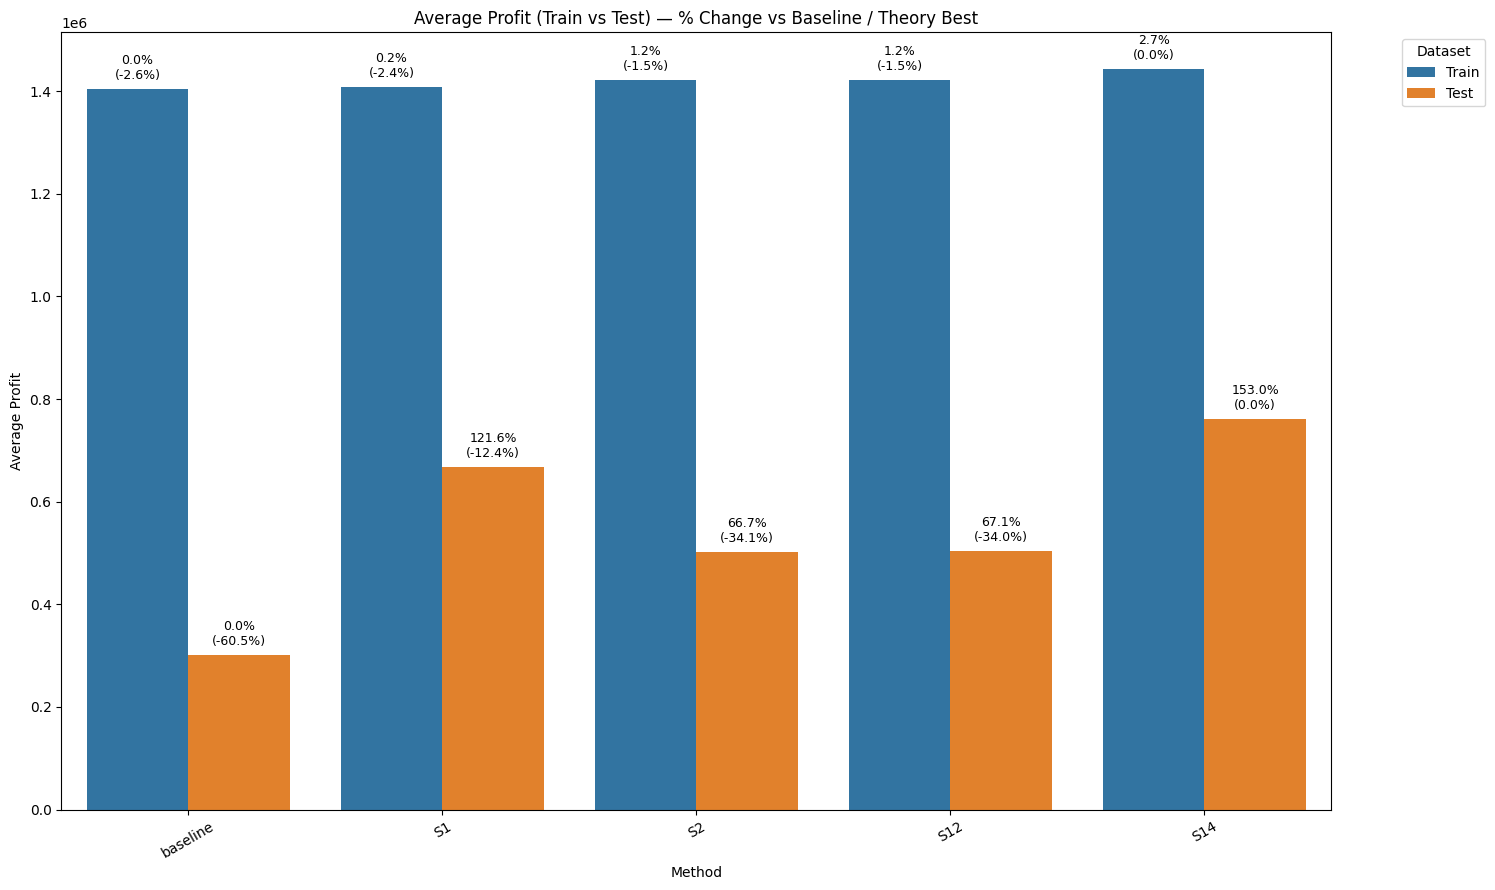

In [1555]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# train_all_fold_profit_df = train_all_fold_profit_df.drop(columns=["S12", "S15", "S16"])
# test_all_fold_profit_df = test_all_fold_profit_df.drop(columns=["S12", "S15", "S16"])

train_all_fold_profit_df = train_all_fold_profit_df.drop(columns=["S15", "S16"])
test_all_fold_profit_df = test_all_fold_profit_df.drop(columns=["S15", "S16"])

# 1️⃣ 計算平均 profit
train_means = train_all_fold_profit_df.mean()
test_means = test_all_fold_profit_df.mean()

# 2️⃣ 定義 baseline & theory best
baseline_train = train_means["baseline"]
baseline_test = test_means["baseline"]
theory_best_train = train_means["S14"]
theory_best_test = test_means["S14"]

# 3️⃣ 計算百分比變化：baseline & theory
train_pct_base = (train_means - baseline_train) / baseline_train * 100
test_pct_base = (test_means - baseline_test) / baseline_test * 100
train_pct_theory = (train_means - theory_best_train) / theory_best_train * 100
test_pct_theory = (test_means - theory_best_test) / theory_best_test * 100

# 4️⃣ 建 DataFrame
avg_df = pd.DataFrame(
    {
        "Method": train_means.index,
        "Train": train_means.values,
        "Test": test_means.values,
        "Train_%_Base": train_pct_base.values,
        "Test_%_Base": test_pct_base.values,
        "Train_%_Theory": train_pct_theory.values,
        "Test_%_Theory": test_pct_theory.values,
    }
)

avg_df_melted = avg_df.melt(
    id_vars=[
        "Method",
        "Train_%_Base",
        "Test_%_Base",
        "Train_%_Theory",
        "Test_%_Theory",
    ],
    value_vars=["Train", "Test"],
    var_name="Dataset",
    value_name="Average Profit",
)

# 5️⃣ 畫圖
plt.figure(figsize=(15, 9))
ax = sns.barplot(x="Method", y="Average Profit", hue="Dataset", data=avg_df_melted)

# 6️⃣ 標註：baseline (%) 在第一行、theory (%) 括號內第二行
for patch, (method, ds) in zip(
    ax.patches, zip(avg_df_melted["Method"], avg_df_melted["Dataset"])
):
    if ds == "Train":
        pct_base = avg_df.loc[avg_df.Method == method, "Train_%_Base"].values[0]
        pct_theory = avg_df.loc[avg_df.Method == method, "Train_%_Theory"].values[0]
    else:
        pct_base = avg_df.loc[avg_df.Method == method, "Test_%_Base"].values[0]
        pct_theory = avg_df.loc[avg_df.Method == method, "Test_%_Theory"].values[0]

    ax.annotate(
        f"{pct_base:.1f}%\n({pct_theory:.1f}%)",
        (patch.get_x() + patch.get_width() / 2, patch.get_height()),
        ha="center",
        va="bottom",
        fontsize=9,
        xytext=(0, 5),
        textcoords="offset points",
    )

plt.title("Average Profit (Train vs Test) — % Change vs Baseline / Theory Best")
plt.ylabel("Average Profit")
plt.xlabel("Method")
plt.xticks(rotation=30)
plt.legend(title="Dataset", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

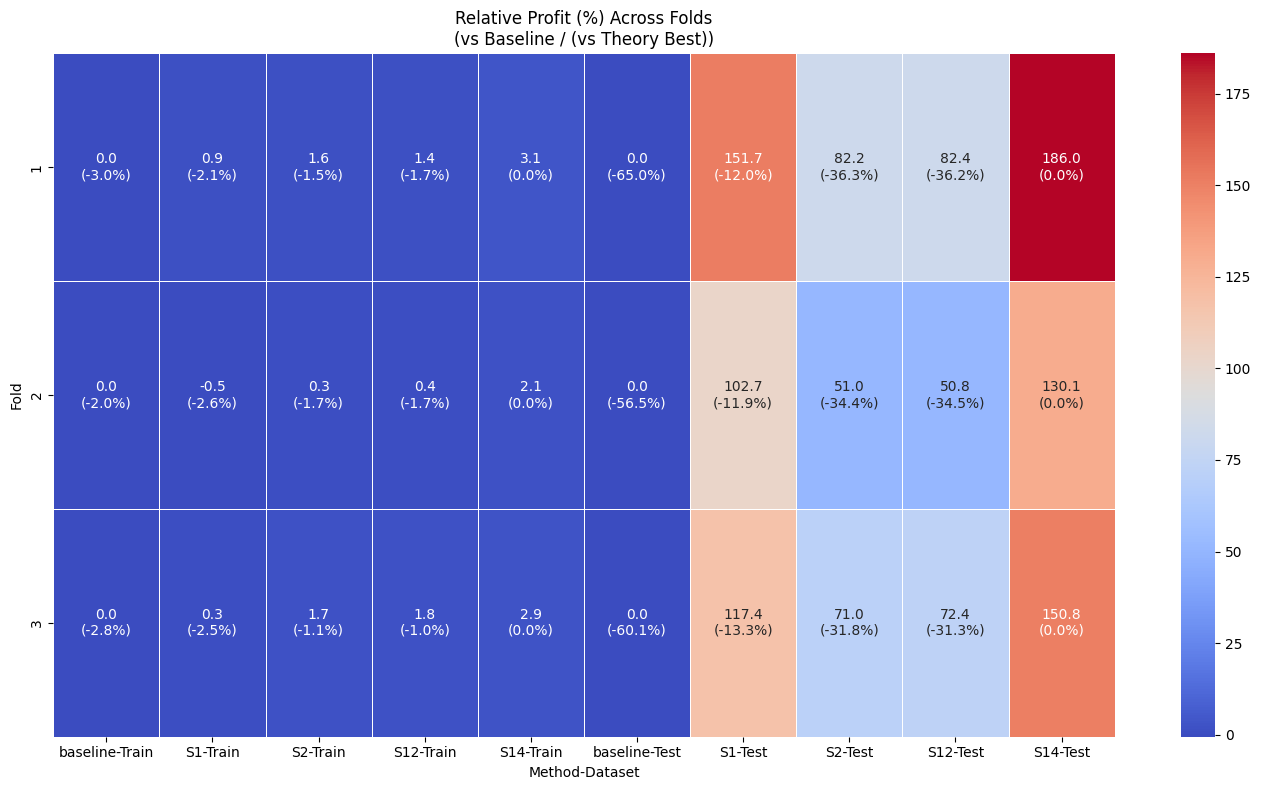

In [1556]:
# 計算 baseline（訓練與測試）
baseline_train = train_all_fold_profit_df["baseline"].to_numpy().reshape(-1, 1)
baseline_test = test_all_fold_profit_df["baseline"].to_numpy().reshape(-1, 1)

# # 計算百分比變化
# train_relative = (
#     (train_all_fold_profit_df.to_numpy() - baseline_train) / baseline_train * 100
# )
# test_relative = (
#     (test_all_fold_profit_df.to_numpy() - baseline_test) / baseline_test * 100
# )

train_relative = (
    (train_all_fold_profit_df.to_numpy() - baseline_train)
    / np.abs(baseline_train)
    * 100
)
test_relative = (
    (test_all_fold_profit_df.to_numpy() - baseline_test) / np.abs(baseline_test) * 100
)

# 轉回 DataFrame，並保留 column names
train_relative = pd.DataFrame(
    train_relative,
    columns=train_all_fold_profit_df.columns,
    index=train_all_fold_profit_df.index,
)
test_relative = pd.DataFrame(
    test_relative,
    columns=test_all_fold_profit_df.columns,
    index=test_all_fold_profit_df.index,
)

# 加入 fold 編號
train_relative["Fold"] = train_relative.index + 1
test_relative["Fold"] = test_relative.index + 1

# 轉換成長格式
train_long = train_relative.melt(
    id_vars="Fold", var_name="Method", value_name="Relative Profit (%)"
)
train_long["Dataset"] = "Train"

test_long = test_relative.melt(
    id_vars="Fold", var_name="Method", value_name="Relative Profit (%)"
)
test_long["Dataset"] = "Test"

# 合併數據
fold_long = pd.concat([train_long, test_long], axis=0)

# # === 1. 使用線圖 (Line Plot) 觀察不同 Fold 上的變化趨勢 ===
# plt.figure(figsize=(12, 6))
# sns.lineplot(
#     data=fold_long,
#     x="Fold",
#     y="Relative Profit (%)",
#     hue="Method",
#     style="Dataset",
#     markers=True,
#     dashes=False,
# )
# plt.axhline(0, color="gray", linestyle="--", linewidth=1)  # 基準線
# plt.title("Strategy Performance Across Folds (Relative to Baseline)")
# plt.legend(title="Method & Dataset", bbox_to_anchor=(1.05, 1), loc="upper left")
# plt.show()

# # === 2. 使用箱型圖 (Box Plot) 查看策略穩定性 ===
# plt.figure(figsize=(12, 6))
# sns.boxplot(data=fold_long, x="Method", y="Relative Profit (%)", hue="Dataset")
# plt.axhline(0, color="gray", linestyle="--", linewidth=1)
# plt.title("Strategy Performance Distribution Across Folds")
# plt.xticks(rotation=30)
# plt.legend(title="Dataset", bbox_to_anchor=(1.05, 1), loc="upper left")
# plt.show()

# 3️⃣ Heatmap：同時顯示 vs Baseline & vs Theory Best（每 Fold 的 S14）
theory_best_train = train_all_fold_profit_df["S14"].to_numpy().reshape(-1, 1)
theory_best_test = test_all_fold_profit_df["S14"].to_numpy().reshape(-1, 1)

# vs Theory (%) 計算
# train_theory_rel = (
#     (train_all_fold_profit_df.to_numpy() - theory_best_train) / theory_best_train * 100
# )
# test_theory_rel = (
#     (test_all_fold_profit_df.to_numpy() - theory_best_test) / theory_best_test * 100
# )
train_theory_rel = (
    (train_all_fold_profit_df.to_numpy() - theory_best_train)
    / np.abs(theory_best_train)
    * 100
)
test_theory_rel = (
    (test_all_fold_profit_df.to_numpy() - theory_best_test)
    / np.abs(theory_best_test)
    * 100
)

# 回 DataFrame 並 melt
train_theory_rel = pd.DataFrame(
    train_theory_rel,
    columns=train_all_fold_profit_df.columns,
    index=train_all_fold_profit_df.index,
)
train_theory_rel["Fold"] = train_theory_rel.index + 1
train_theory_long = train_theory_rel.melt(
    id_vars="Fold", var_name="Method", value_name="Relative vs Theory (%)"
)
train_theory_long["Dataset"] = "Train"

test_theory_rel = pd.DataFrame(
    test_theory_rel,
    columns=test_all_fold_profit_df.columns,
    index=test_all_fold_profit_df.index,
)
test_theory_rel["Fold"] = test_theory_rel.index + 1
test_theory_long = test_theory_rel.melt(
    id_vars="Fold", var_name="Method", value_name="Relative vs Theory (%)"
)
test_theory_long["Dataset"] = "Test"

# 合併 baseline (%) 與 theory (%) 資料
merged = fold_long.merge(
    pd.concat([train_theory_long, test_theory_long], axis=0),
    on=["Fold", "Method", "Dataset"],
)

# Pivot heatmap values + annotations
heatmap_data = merged.pivot(
    index="Fold", columns=["Method", "Dataset"], values="Relative Profit (%)"
)
annot = merged.assign(
    annot=merged["Relative Profit (%)"].round(1).astype(str)
    + "\n("
    + merged["Relative vs Theory (%)"].round(1).astype(str)
    + "%)"
).pivot(index="Fold", columns=["Method", "Dataset"], values="annot")

plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data, annot=annot, fmt="", cmap="coolwarm", linewidths=0.5)
plt.title("Relative Profit (%) Across Folds\n(vs Baseline / (vs Theory Best))")
plt.ylabel("Fold")
plt.tight_layout()
plt.show()

Plot saved as plots/plot_strategies_profits_scatter_train_med_with_holding_cost_0.png


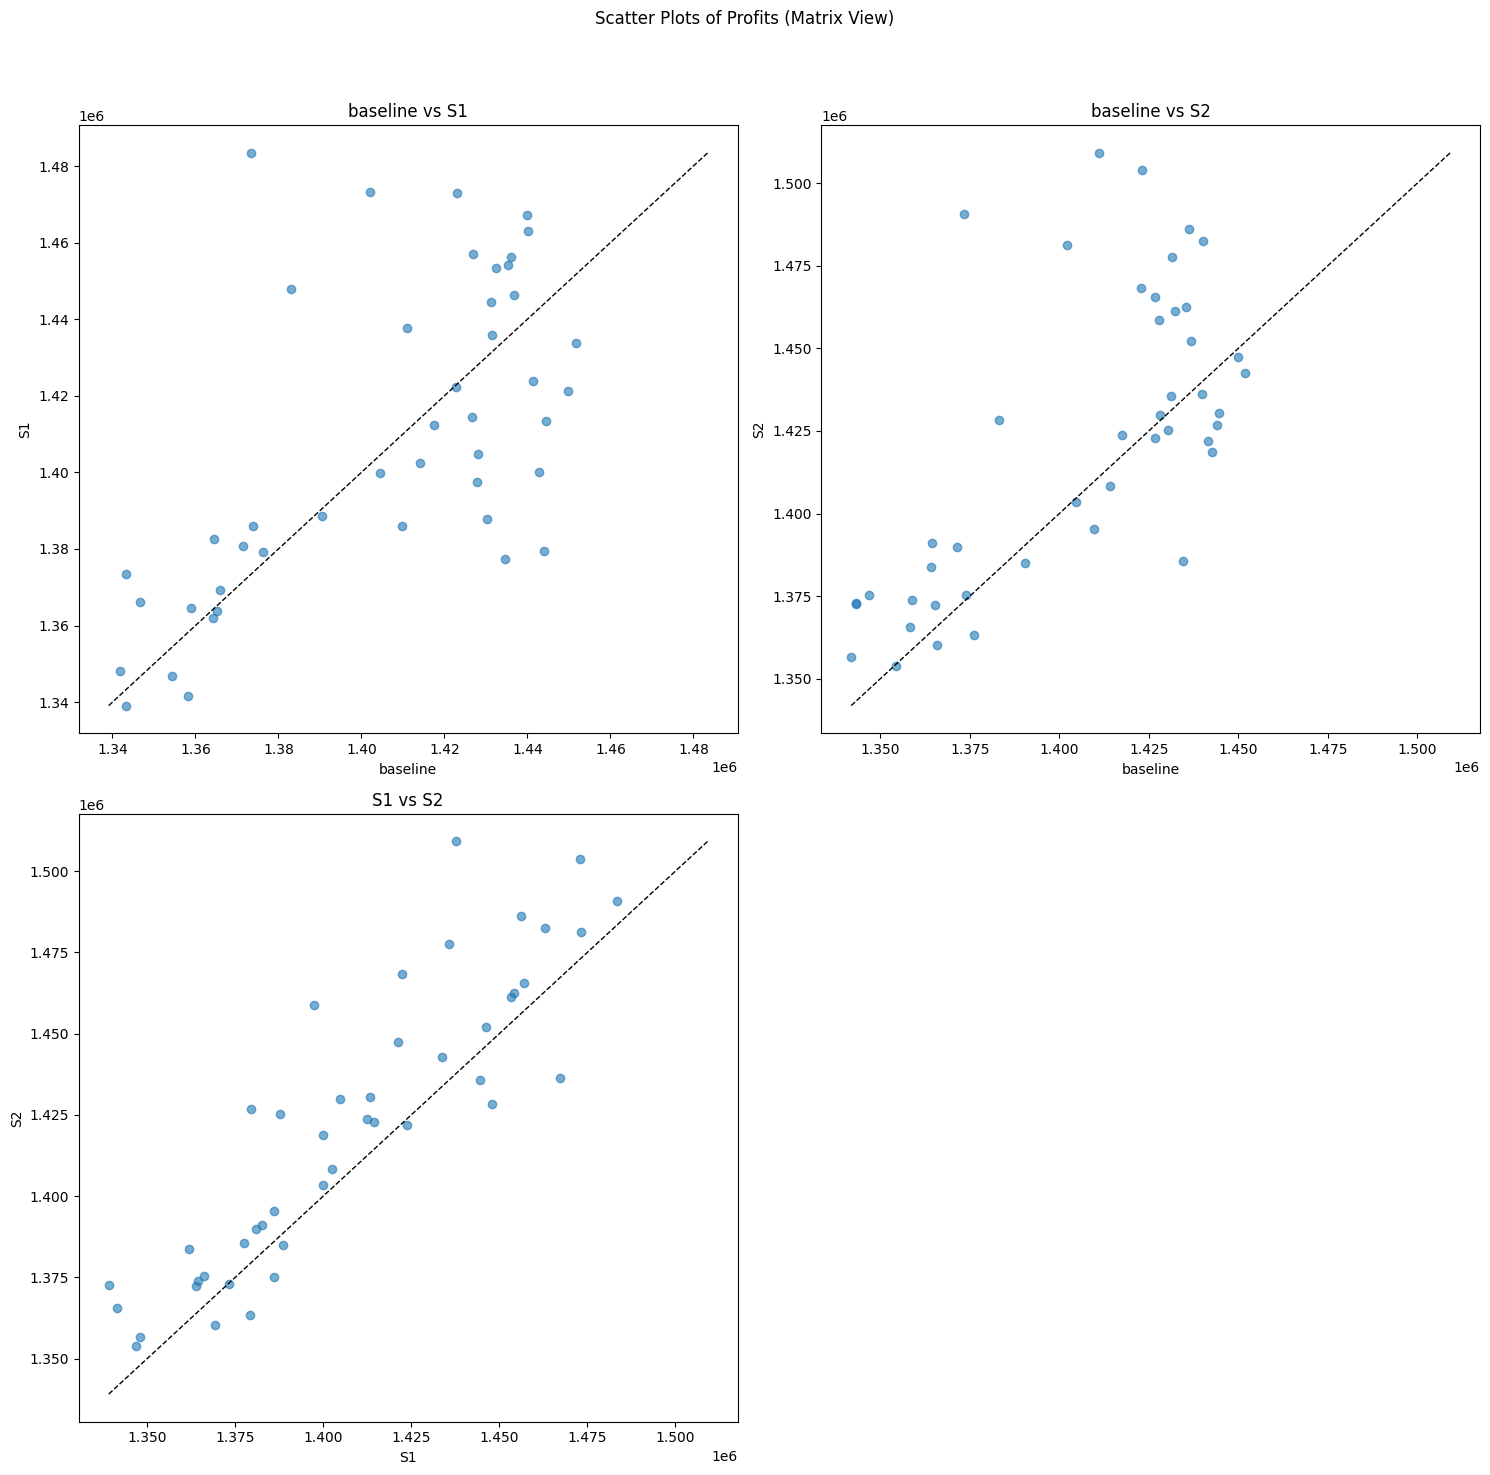

In [1557]:
# 訓練階段分佈

baseline_data = []
S1_data = []
S2_data = []
S12_data = []
S14_data = []
S15_data = []

for result in train_all_fold_stimulation_results:
    baseline_data.append(result["baseline"])
    S1_data.append(result["S1"])
    S2_data.append(result["S2"])
    # S12_data.append(result["S12"])
    # S14_data.append(result["S14"])
    # S15_data.append(result["S15"])

# 合併數據
baseline_df = pd.concat(baseline_data, ignore_index=True)
S1_df = pd.concat(S1_data, ignore_index=True)
S2_df = pd.concat(S2_data, ignore_index=True)
# S12_df = pd.concat(S12_data, ignore_index=True)
# S14_df = pd.concat(S14_data, ignore_index=True)
# S15_df = pd.concat(S15_data, ignore_index=True)


dfs = {
    "baseline": baseline_df,
    "S1": S1_df,
    "S2": S2_df,
    # "S12": S12_df,
    # "S15": S15_df,
    # "S14": S14_df,
}

# 調用繪圖函數
plot_strategies_profits_scatter(f"{status}_{model_prefix}", dfs)

Plot saved as plots/plot_strategies_profits_scatter_train_med_with_holding_cost_0.png


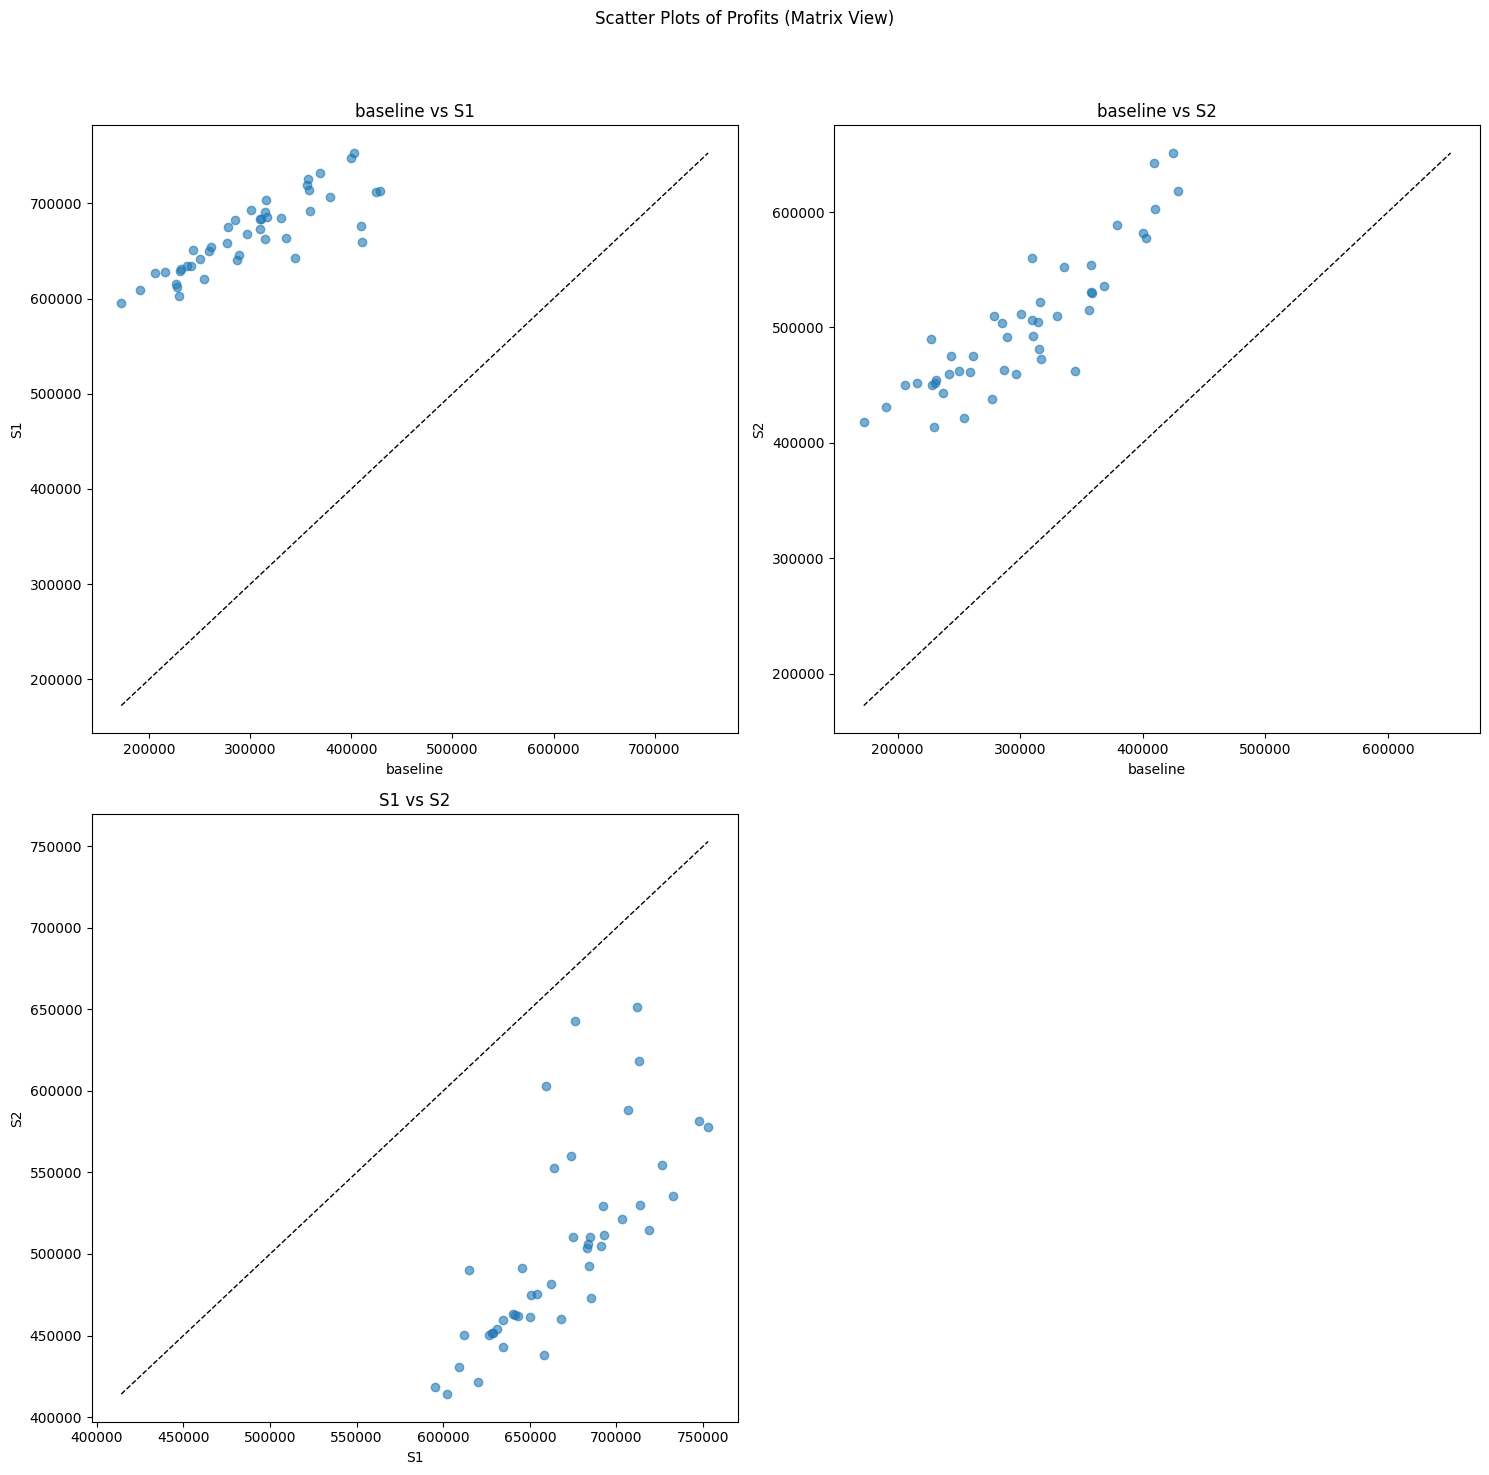

In [1558]:
# 測試結果分布圖

baseline_data = []
S1_data = []
S2_data = []
S12_data = []
S14_data = []
S15_data = []

for result in test_all_fold_stimulation_results:
    baseline_data.append(result["baseline"])
    S1_data.append(result["S1"])
    S2_data.append(result["S2"])
    # S12_data.append(result["S12"])
    # S14_data.append(result["S14"])
    # S15_data.append(result["S15"])
# 合併數據
baseline_df = pd.concat(baseline_data, ignore_index=True)
S1_df = pd.concat(S1_data, ignore_index=True)
S2_df = pd.concat(S2_data, ignore_index=True)
# S12_df = pd.concat(S12_data, ignore_index=True)
# S14_df = pd.concat(S14_data, ignore_index=True)
# S15_df = pd.concat(S15_data, ignore_index=True)

dfs = {
    "baseline": baseline_df,
    "S1": S1_df,
    "S2": S2_df,
    # "S12": S12_df,
    # "S15": S15_df,
    # "S14": S14_df,
}

# 調用繪圖函數
plot_strategies_profits_scatter(f"{status}_{model_prefix}", dfs)

In [1559]:
# import ast

# summary_df = pd.read_csv(
#     "/Users/hanyuan/Github/Two-Phase-Newsvendor/results/summary.csv"
# )

# records_str = summary_df.loc[0, "train_df"]
# records = ast.literal_eval(records_str)

# df_reconstructed = pd.DataFrame(records)
# df_reconstructed

#### EDA

In [1560]:
for fold_idx in range(len(training_data_folds)):
    print(f"===== Processing Fold {fold_idx + 1} =====")
    # 取出該 fold 的訓練資料與需求資料
    training_df, testing_df = training_data_folds[fold_idx]
    demand_df_train, demand_df_test = demand_folds[fold_idx]

    print(f"training_df: \n{training_df}")
    print(f"demand_df_train: \n{demand_df_train}")
    print(f"testing_df: \n{testing_df}")
    print(f"demand_df_test: \n{demand_df_test}")

===== Processing Fold 1 =====
training_df: 
       X1   X2        X3
0   250.0  0.0  7.097627
1   250.0  0.0  7.430379
2   250.0  0.0  7.205527
3   250.0  0.0  7.089766
4   250.0  0.0  6.847310
5   250.0  0.0  7.291788
6   250.0  0.0  6.875174
7   250.0  0.0  7.783546
8   250.0  0.0  7.927326
9   250.0  0.0  6.766883
10  250.0  0.0  7.583450
11  250.0  0.0  7.057790
12  250.0  0.0  7.136089
13  250.0  0.0  7.851193
14  250.0  0.0  6.142072
demand_df_train: 
     demand_t1   demand_t2   demand_t3   demand_t4   demand_t5   demand_t6  \
0   216.269540  211.134274  215.128316  217.994763  229.527662  228.343740   
1   213.412362  212.203824  210.885199  212.928863  214.608230  221.012875   
2   204.681787  207.336518  210.952538  203.368635  201.143341  212.945396   
3   198.383496  200.987261  197.538109  202.580936  202.908901  212.987482   
4   219.811740  215.888884  220.591784  218.304163  224.051815  230.563012   
5   220.360046  221.653541  221.084469  221.365066  219.588375  230.34

In [1561]:
demand_df_train.head()

,demand_t1,demand_t2,demand_t3,demand_t4,demand_t5,demand_t6,demand_t7,demand_t8,demand_t9,demand_t10
0,216.647776,217.707632,217.106637,216.842714,219.597076,233.419212,281.223054,286.606612,295.373362,295.021682
1,206.392192,207.466613,209.843167,207.604607,213.000352,224.961254,275.069930,290.849170,293.042855,290.427386
2,208.757150,211.215125,210.251555,213.156271,218.505110,222.001409,233.240220,284.029835,294.011162,298.315636
3,211.765499,214.318603,215.414811,216.141472,219.949536,233.053752,285.949828,296.587134,299.984362,300.882037
4,212.809346,217.810872,213.306858,217.226836,220.572888,233.189850,283.261878,291.515898,295.193378,301.422180


In [1562]:
demand_df_test.head()

,demand_t1,demand_t2,demand_t3,demand_t4,demand_t5,demand_t6,demand_t7,demand_t8,demand_t9,demand_t10
0,76.726007,85.292909,133.499628,142.686827,151.989907,148.099649,147.917016,153.114936,149.021591,145.097141
1,73.215452,84.322469,140.436462,147.706836,153.427440,155.765750,155.706461,157.681604,157.247505,159.518788
2,81.614354,93.288630,142.735808,149.774088,154.774819,155.977932,156.344506,152.764874,157.058150,156.135556
3,53.997127,65.378692,122.601776,137.369862,143.971341,145.596807,148.718305,148.766359,147.117258,151.321785
4,79.623523,88.635007,129.643968,136.108997,141.327015,142.297723,143.193646,140.258585,143.374846,140.789340


In [1563]:
mu_matrix, covariance_matrix = cal_mu_and_cov_matrix(demand_df_test)
Qk_hat_df_test = make_Qk_hat_df(
    demand_df_test, T, service_lv, mu_matrix, covariance_matrix
)
Qk_hat_df_test.head()

,Qk_hat_k2,Qk_hat_k3,Qk_hat_k4,Qk_hat_k5,Qk_hat_k6,Qk_hat_k7,Qk_hat_k8,Qk_hat_k9
0,1327.556091,1313.863760,1323.753555,1341.450027,1340.901501,1336.798594,1333.242991,1335.642211
1,1313.069378,1328.628503,1336.626359,1370.181494,1370.067265,1384.047741,1383.690384,1383.490833
2,1347.728425,1365.324931,1365.503153,1396.960416,1397.087606,1401.439730,1402.952999,1401.211673
3,1233.762716,1261.705212,1271.919590,1264.597860,1264.105834,1262.319750,1265.939404,1266.018576
4,1339.513031,1329.221297,1331.942771,1298.853685,1298.985543,1289.184434,1289.069098,1287.215295


In [1564]:
Q_star

np.float64(2439.950183572415)

##### S1

In [1565]:
Q_star

np.float64(2439.950183572415)

In [1566]:
results_df_1, stimulation_results_df_1 = None, None

results_df_1, stimulation_results_df_1 = grid_fixed_F_fixed_R(
    assigned_Ts=ASSIGNED_TS,
    assigned_Fs=ASSIGNED_FS,
    cost=cost,
    price=price,
    salvage_value=salvage_value,
    Qk_hat_df=Qk_hat_df_train,
    demand_df_train=demand_df_train,
    Q_star=Q_star,
)

results_df_1

,R(T),F,Q0,Q1,average_profits,average_losses,average_lefts,average_operation_profits
0,2,0.1,"[243.99501835724152, 243.99501835724152, 243.9...","[2269.95107075639, 2144.5231165888654, 2173.44...",1.414303e+06,13.041585,58.057253,1.445351e+06
10,3,0.2,"[487.99003671448304, 487.99003671448304, 487.9...","[2025.9372217432917, 1899.407887152837, 1930.2...",1.400996e+06,13.287333,90.587270,1.445203e+06
70,9,0.8,"[1951.9601468579322, 1951.9601468579322, 1951....","[523.4497811581105, 471.9663895204849, 442.392...",1.400309e+06,1.703915,127.054584,1.452153e+06
20,4,0.3,"[731.9850550717246, 731.9850550717246, 731.985...","[1780.5736633861006, 1656.8543342108806, 1685....",1.388309e+06,13.233072,122.467215,1.445236e+06
30,5,0.4,"[975.9800734289661, 975.9800734289661, 975.980...","[1483.59642709431, 1402.3642031024478, 1473.13...",1.383626e+06,9.090525,146.603148,1.447721e+06
...,...,...,...,...,...,...,...,...
55,8,0.2,"[487.99003671448304, 487.99003671448304, 487.9...","[1997.5575478142553, 1939.2001775168476, 1918....",-2.318004e+05,1052.429165,1055.152815,8.217182e+05
65,9,0.3,"[731.9850550717246, 731.9850550717246, 731.985...","[1743.424872944318, 1691.9414813066924, 1662.3...",-3.013963e+05,1096.210920,1097.797418,7.954492e+05
54,8,0.1,"[243.99501835724152, 243.99501835724152, 243.9...","[2241.552566171497, 2183.195195874089, 2162.47...",-6.221924e+05,1296.424183,1299.147833,6.753212e+05
64,9,0.2,"[487.99003671448304, 487.99003671448304, 487.9...","[1987.4198913015596, 1935.936499663934, 1906.3...",-6.917884e+05,1340.205939,1341.792436,6.490522e+05


In [1567]:
# Train
result = results_df_1.iloc[:, 0:2]
for i in range(len(result)):
    print(f"R: {result.iloc[i, 0]}, F: {result.iloc[i, 1]}")

R: 2, F: 0.1
R: 3, F: 0.2
R: 9, F: 0.8
R: 4, F: 0.30000000000000004
R: 5, F: 0.4
R: 8, F: 0.7000000000000001
R: 7, F: 0.6000000000000001
R: 6, F: 0.5
R: 7, F: 0.5
R: 8, F: 0.6000000000000001
R: 2, F: 0.2
R: 6, F: 0.4
R: 3, F: 0.30000000000000004
R: 9, F: 0.9
R: 4, F: 0.4
R: 5, F: 0.5
R: 8, F: 0.8
R: 7, F: 0.7000000000000001
R: 6, F: 0.6000000000000001
R: 5, F: 0.30000000000000004
R: 9, F: 0.7000000000000001
R: 2, F: 0.30000000000000004
R: 4, F: 0.2
R: 3, F: 0.4
R: 4, F: 0.5
R: 5, F: 0.6000000000000001
R: 8, F: 0.9
R: 7, F: 0.8
R: 6, F: 0.7000000000000001
R: 3, F: 0.1
R: 2, F: 0.4
R: 3, F: 0.5
R: 4, F: 0.6000000000000001
R: 5, F: 0.7000000000000001
R: 7, F: 0.9
R: 6, F: 0.8
R: 2, F: 0.5
R: 3, F: 0.6000000000000001
R: 4, F: 0.7000000000000001
R: 5, F: 0.8
R: 6, F: 0.9
R: 7, F: 0.4
R: 8, F: 0.5
R: 2, F: 0.6000000000000001
R: 6, F: 0.30000000000000004
R: 3, F: 0.7000000000000001
R: 4, F: 0.8
R: 5, F: 0.9
R: 5, F: 0.2
R: 9, F: 0.6000000000000001
R: 2, F: 0.7000000000000001
R: 4, F: 0.1
R: 3

In [1568]:
results_df_1, stimulation_results_df_1 = None, None

results_df_1, stimulation_results_df_1 = grid_fixed_F_fixed_R(
    assigned_Ts=ASSIGNED_TS,
    assigned_Fs=ASSIGNED_FS,
    cost=cost,
    price=price,
    salvage_value=salvage_value,
    Qk_hat_df=Qk_hat_df_test,
    demand_df_train=demand_df_test,
    Q_star=Q_star,
)

results_df_1

,R(T),F,Q0,Q1,average_profits,average_losses,average_lefts,average_operation_profits
47,7,0.3,"[731.9850550717246, 731.9850550717246, 731.985...","[604.8135392291935, 652.0626856585942, 669.454...",739326.687160,6.554651,56.007361,765662.422135
28,5,0.2,"[487.99003671448304, 487.99003671448304, 487.9...","[853.459989988143, 882.1914569676458, 908.9703...",728448.749818,2.862513,94.278616,767877.704484
66,9,0.4,"[975.9800734289661, 975.9800734289661, 975.980...","[359.6621377502245, 407.5107599456462, 425.231...",715854.471730,28.821212,47.888216,752302.485353
57,8,0.4,"[975.9800734289661, 975.9800734289661, 975.980...","[357.2629172343859, 407.71031018582994, 426.97...",713205.847564,0.482057,139.527240,769305.978084
18,4,0.1,"[243.99501835724152, 243.99501835724152, 243.9...","[1079.758536505809, 1092.6313403393742, 1121.5...",711167.910326,31.901102,50.364948,750454.551103
...,...,...,...,...,...,...,...,...
35,5,0.9,"[2195.9551652151736, 2195.9551652151736, 2195....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",-314466.592964,0.000000,2710.154514,769595.212557
26,4,0.9,"[2195.9551652151736, 2195.9551652151736, 2195....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",-369313.503986,0.000000,2847.271791,769595.212557
17,3,0.9,"[2195.9551652151736, 2195.9551652151736, 2195....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",-415063.594638,0.000000,2961.647018,769595.212557
63,9,0.1,"[243.99501835724152, 243.99501835724152, 243.9...","[1091.647192821949, 1139.4958150173707, 1157.2...",-417541.196948,741.887033,742.179924,324462.992695


In [1569]:
# Test
result = results_df_1.iloc[:, 0:2]
for i in range(len(result)):
    print(f"R: {result.iloc[i, 0]}, F: {result.iloc[i, 1]}")

R: 7, F: 0.30000000000000004
R: 5, F: 0.2
R: 9, F: 0.4
R: 8, F: 0.4
R: 4, F: 0.1
R: 3, F: 0.1
R: 6, F: 0.30000000000000004
R: 6, F: 0.2
R: 9, F: 0.5
R: 2, F: 0.1
R: 4, F: 0.2
R: 7, F: 0.4
R: 5, F: 0.30000000000000004
R: 8, F: 0.5
R: 3, F: 0.2
R: 8, F: 0.30000000000000004
R: 6, F: 0.4
R: 2, F: 0.2
R: 4, F: 0.30000000000000004
R: 7, F: 0.5
R: 5, F: 0.4
R: 5, F: 0.1
R: 3, F: 0.30000000000000004
R: 9, F: 0.6000000000000001
R: 6, F: 0.5
R: 2, F: 0.30000000000000004
R: 4, F: 0.4
R: 7, F: 0.2
R: 8, F: 0.6000000000000001
R: 5, F: 0.5
R: 3, F: 0.4
R: 7, F: 0.6000000000000001
R: 2, F: 0.4
R: 4, F: 0.5
R: 9, F: 0.30000000000000004
R: 6, F: 0.6000000000000001
R: 3, F: 0.5
R: 9, F: 0.7000000000000001
R: 6, F: 0.1
R: 2, F: 0.5
R: 5, F: 0.6000000000000001
R: 8, F: 0.7000000000000001
R: 4, F: 0.6000000000000001
R: 8, F: 0.2
R: 7, F: 0.7000000000000001
R: 3, F: 0.6000000000000001
R: 2, F: 0.6000000000000001
R: 6, F: 0.7000000000000001
R: 9, F: 0.8
R: 5, F: 0.7000000000000001
R: 7, F: 0.1
R: 8, F: 0.8
R

##### S2

In [1570]:
training_df.head()

,X1,X2,X3
0,250.0,0.0,6.317939
1,250.0,0.0,6.220750
2,250.0,0.0,7.312659
3,250.0,0.0,6.276366
4,250.0,0.0,6.393165


In [1571]:
demand_df_train.head()

,demand_t1,demand_t2,demand_t3,demand_t4,demand_t5,demand_t6,demand_t7,demand_t8,demand_t9,demand_t10
0,216.647776,217.707632,217.106637,216.842714,219.597076,233.419212,281.223054,286.606612,295.373362,295.021682
1,206.392192,207.466613,209.843167,207.604607,213.000352,224.961254,275.069930,290.849170,293.042855,290.427386
2,208.757150,211.215125,210.251555,213.156271,218.505110,222.001409,233.240220,284.029835,294.011162,298.315636
3,211.765499,214.318603,215.414811,216.141472,219.949536,233.053752,285.949828,296.587134,299.984362,300.882037
4,212.809346,217.810872,213.306858,217.226836,220.572888,233.189850,283.261878,291.515898,295.193378,301.422180


In [1572]:
demand_df_test.head()

,demand_t1,demand_t2,demand_t3,demand_t4,demand_t5,demand_t6,demand_t7,demand_t8,demand_t9,demand_t10
0,76.726007,85.292909,133.499628,142.686827,151.989907,148.099649,147.917016,153.114936,149.021591,145.097141
1,73.215452,84.322469,140.436462,147.706836,153.427440,155.765750,155.706461,157.681604,157.247505,159.518788
2,81.614354,93.288630,142.735808,149.774088,154.774819,155.977932,156.344506,152.764874,157.058150,156.135556
3,53.997127,65.378692,122.601776,137.369862,143.971341,145.596807,148.718305,148.766359,147.117258,151.321785
4,79.623523,88.635007,129.643968,136.108997,141.327015,142.297723,143.193646,140.258585,143.374846,140.789340


In [1573]:
Qk_hat_df_train.head()

,Qk_hat_k2,Qk_hat_k3,Qk_hat_k4,Qk_hat_k5,Qk_hat_k6,Qk_hat_k7,Qk_hat_k8,Qk_hat_k9
0,2513.946089,2513.927258,2512.558718,2459.576501,2458.613982,2482.734196,2485.547585,2475.409928
1,2388.518135,2387.397924,2388.839389,2378.344277,2382.912705,2438.709524,2427.190214,2423.926536
2,2417.442070,2418.245378,2417.663914,2449.113718,2452.384182,2413.429298,2406.473179,2394.352304
3,2454.234816,2455.480857,2456.327560,2459.188516,2458.357909,2482.921323,2483.762027,2497.761703
4,2467.001282,2471.308571,2468.981434,2477.945614,2477.035417,2490.348567,2494.383814,2489.961909


In [1574]:
Qk_hat_df_test.head()

,Qk_hat_k2,Qk_hat_k3,Qk_hat_k4,Qk_hat_k5,Qk_hat_k6,Qk_hat_k7,Qk_hat_k8,Qk_hat_k9
0,1327.556091,1313.863760,1323.753555,1341.450027,1340.901501,1336.798594,1333.242991,1335.642211
1,1313.069378,1328.628503,1336.626359,1370.181494,1370.067265,1384.047741,1383.690384,1383.490833
2,1347.728425,1365.324931,1365.503153,1396.960416,1397.087606,1401.439730,1402.952999,1401.211673
3,1233.762716,1261.705212,1271.919590,1264.597860,1264.105834,1262.319750,1265.939404,1266.018576
4,1339.513031,1329.221297,1331.942771,1298.853685,1298.985543,1289.184434,1289.069098,1287.215295


In [1575]:
results_df_2, stimulation_results_df_2 = None, None
results_df_2, stimulation_results_df_2 = grid_flexible_F_fixed_R(
    assigned_Ts=ASSIGNED_TS,
    salvage_value=salvage_value,
    cost=cost,
    price=price,
    Q_star=Q_star,
    demand_df_train=demand_df_train,
    Qk_hat_df_train=Qk_hat_df_train,
    training_df=training_df,
)

results_df_2

+++++++++++++++++++++++++++++++++++++++ THis is R=0 +++++++++++++++++++++++++++++++++++++++++++++++++
Set parameter Threads to value 12
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 20000
Set parameter NonConvex to value 2
Set parameter IntFeasTol to value 1e-09
Set parameter NumericFocus to value 3
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.2.0 24C101)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 173 rows, 263 columns and 466 nonzeros
Model fingerprint: 0x3149f492
Model has 120 general constraints
Variable types: 263 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 2e+03]
  RHS range        [1e+00, 3e+03]
  GenCon const rng [2e+02, 2e+03]
Presolve removed 63 rows

,R(T),R,average_profits,average_losses,average_lefts,average_operation_profits,alpha_values,F_vars,f_vars,Q0_vars,Q1_vars
6,8,"[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]",1.434546e+06,5.247298,30.833165,1.450027e+06,"[0.006051714831513595, 0.0, -0.134605539196010...","[0.659821552883867, 0.6627517683924896, 0.6291...","[0.6624990996575941, 0.6755812619218209, 0.528...","[1609.9317190840272, 1617.0812989521976, 1535....","[875.6158654447111, 810.108915279132, 871.3601..."
7,9,"[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]",1.434136e+06,9.689161,18.532544,1.447362e+06,"[0.010240182265778445, 0.0, -0.210121320763390...","[0.7742579033398518, 0.777807216567782, 0.7356...","[1.232511844110657, 1.2529333009824895, 1.0234...","[1889.1507133864645, 1897.8108608485088, 1794....","[586.2592146295781, 526.1156755299068, 599.393..."
5,7,"[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]",1.433129e+06,7.357813,28.044134,1.448761e+06,"[0.0025953592346893567, 0.0, -0.07438806201181...","[0.5445963124481379, 0.5463887712829674, 0.526...","[0.17886055810904336, 0.18609025091048734, 0.1...","[1328.7878725306944, 1333.1613827937824, 1283....","[1153.9463232326773, 1105.5481411726655, 1129...."
3,5,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]",1.425942e+06,9.090525,40.813075,1.447721e+06,"[-0.0018244602185753906, 0.0, -0.0192173681817...","[0.35950131856149947, 0.35993149150429105, 0.3...","[-0.5775292177713176, -0.5756615031858249, -0....","[877.1653082186559, 878.2149087693881, 866.454...","[1582.4111923046203, 1500.1293677620258, 1582...."
0,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1.425918e+06,13.041585,29.018317,1.445351e+06,"[-0.008770623601192223, 0.0, -0.02074167161838...","[0.08917826363963888, 0.08934275196196835, 0.0...","[-2.32370051981091, -2.321684659874063, -2.344...","[217.5905207382061, 217.99186405046942, 213.53...","[2296.3555683754253, 2170.5262708956375, 2203...."
4,6,"[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]",1.422176e+06,8.960540,50.617581,1.447799e+06,"[0.00037060799079072525, 0.0, -0.0426166225640...","[0.4559649343541702, 0.4569926935960077, 0.445...","[-0.17659723117709064, -0.17245536914923051, -...","[1112.5317252800417, 1115.0394066308313, 1086....","[1346.0822565582173, 1267.8732985251359, 1365...."
1,3,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1.418336e+06,13.639085,46.182974,1.444992e+06,"[-0.0076407192968197795, 0.0, 0.05785081133761...","[0.17585569219657235, 0.1750423115591844, 0.18...","[-1.5446819173954356, -1.5503043732435107, -1....","[429.07912845728083, 427.0945202217718, 449.80...","[2084.848130000494, 1960.3034036455454, 1968.4..."
2,4,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]",1.416240e+06,13.859713,50.759743,1.444860e+06,"[-0.005441550507021547, 0.0, 0.052343871798671...","[0.26314571535049286, 0.2621604880394866, 0.27...","[-1.0296822289508978, -1.034769471485627, -0.9...","[642.0624364757296, 639.6585309173793, 666.997...","[1870.4962819820958, 1749.1808583652285, 1750...."


In [1576]:
results_df_2, stimulation_results_df_2 = None, None
results_df_2, stimulation_results_df_2 = grid_flexible_F_fixed_R(
    assigned_Ts=ASSIGNED_TS,
    salvage_value=salvage_value,
    cost=cost,
    price=price,
    Q_star=Q_star,
    demand_df_train=demand_df_test,
    Qk_hat_df_train=Qk_hat_df_test,
    training_df=testing_df,
)

results_df_2

+++++++++++++++++++++++++++++++++++++++ THis is R=0 +++++++++++++++++++++++++++++++++++++++++++++++++
Set parameter Threads to value 12
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 20000
Set parameter NonConvex to value 2
Set parameter IntFeasTol to value 1e-09
Set parameter NumericFocus to value 3
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.2.0 24C101)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 173 rows, 263 columns and 481 nonzeros
Model fingerprint: 0x2ca04d36
Model has 120 general constraints
Variable types: 263 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 2e+03]
  RHS range        [1e+00, 1e+03]
  GenCon const rng [5e+01, 1e+03]
Presolve removed 44 rows

,R(T),R,average_profits,average_losses,average_lefts,average_operation_profits,alpha_values,F_vars,f_vars,Q0_vars,Q1_vars
3,5,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]",754640.649196,4.029129,25.299021,767177.735019,"[-0.009288359982061258, 0.0, -0.24536359809976...","[0.19173215358508425, 0.17388448178539448, 0.1...","[-1.4387937098238643, -1.5583442622164778, -1....","[467.81690333666074, 424.2694732526675, 452.96...","[873.6331233659653, 945.9120204294613, 943.990..."
4,6,"[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]",752543.260006,6.007143,24.608452,765990.926770,"[-0.007138407770080382, 0.0, -0.18981243836737...","[0.24818006151816085, 0.2313282705799354, 0.24...","[-1.1083423145468414, -1.2008262120505864, -1....","[605.5469866602498, 564.4294562670027, 591.655...","[735.3545139346106, 805.6378090567691, 805.432..."
5,7,"[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]",751802.712868,5.929278,26.693416,766037.645934,"[-0.004751909138388111, 0.0, -0.15845351916441...","[0.309060153144241, 0.2928208891486767, 0.3036...","[-0.8045168393496075, -0.8817228508005526, -0....","[754.0913773992096, 714.4683822321515, 740.781...","[582.7072169017061, 669.5793584981708, 660.658..."
6,8,"[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]",749217.568438,5.742898,33.715416,766149.473767,"[-0.0024003943457312003, 0.0, -0.1365799586581...","[0.3719398286264574, 0.35653140855184234, 0.36...","[-0.5239038859814881, -0.5904508784033518, -0....","[907.5146531350173, 869.9188757453994, 894.938...","[425.72833752833543, 513.7715078693979, 508.01..."
7,9,"[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]",746409.670845,6.408640,38.737933,765750.028338,"[-5.583752474166381e-05, 0.0, -0.1254201890354...","[0.43382695994437714, 0.41888225340762014, 0.4...","[-0.2662540111699422, -0.32736353595886286, -0...","[1058.5161705549458, 1022.0518310971496, 1046....","[277.12604062424435, 361.43900227746593, 354.8..."
2,4,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]",740201.188294,12.169942,36.975236,762293.247617,"[-0.015398247933078084, 0.0, -0.19655334726790...","[0.12473486237305755, 0.11464941529526103, 0.1...","[-1.9483364713228655, -2.0441047980937372, -1....","[304.34685034502166, 279.73886189614217, 295.9...","[1019.4067045180271, 1056.8874968004766, 1069...."
1,3,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",738916.991089,13.872905,35.076838,761271.469334,"[-0.025152895763734938, 0.0, -0.06159632672767...","[0.06640255076294996, 0.0645660402431093, 0.06...","[-2.643309877939718, -2.673321969964289, -2.65...","[162.01891592373636, 157.53792174371847, 160.5...","[1151.8448436619483, 1171.0905813527158, 1204...."
0,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",732830.864974,18.873202,35.291262,758271.291080,"[-0.030589481786886114, 0.0, -0.17586379324015...","[0.031539601822535575, 0.029024899054991345, 0...","[-3.4244591927580315, -3.5101467755557563, -3....","[76.95505725669655, 70.81930777739694, 74.8599...","[1250.6010335602036, 1242.250069722751, 1272.8..."


In [1577]:
num_neg_ones = results_df_2.iloc[0]["F_vars"].count(-1)
print("F_vars 中有 -1 的個數：", num_neg_ones)

F_vars 中有 -1 的個數： 3


In [1578]:
Q_star * 0.74

np.float64(1805.5631358435871)

In [1579]:
demand_df_test_analysis = demand_df_test.copy()
demand_df_test_analysis["sum_first_8"] = demand_df_test_analysis.iloc[:, :8].sum(axis=1)
demand_df_test_analysis["sum"] = demand_df_test_analysis.iloc[:, :10].sum(axis=1)

demand_df_test_analysis["Lost_0"] = (
    demand_df_test_analysis["sum_first_8"] - results_df_2.iloc[0]["Q0_vars"]
)
demand_df_test_analysis.head()

,demand_t1,demand_t2,demand_t3,demand_t4,demand_t5,demand_t6,demand_t7,demand_t8,demand_t9,demand_t10,sum_first_8,sum,Lost_0
0,76.726007,85.292909,133.499628,142.686827,151.989907,148.099649,147.917016,153.114936,149.021591,145.097141,1039.326879,1333.445611,571.509976
1,73.215452,84.322469,140.436462,147.706836,153.427440,155.765750,155.706461,157.681604,157.247505,159.518788,1068.262475,1385.028768,643.993002
2,81.614354,93.288630,142.735808,149.774088,154.774819,155.977932,156.344506,152.764874,157.058150,156.135556,1087.275011,1400.468717,634.305196
3,53.997127,65.378692,122.601776,137.369862,143.971341,145.596807,148.718305,148.766359,147.117258,151.321785,966.400270,1264.839313,967.400270
4,79.623523,88.635007,129.643968,136.108997,141.327015,142.297723,143.193646,140.258585,143.374846,140.789340,1001.088464,1285.252650,547.853087


In [1580]:
demand_df_test_analysis[demand_df_test_analysis["Lost_0"] >= 0]

,demand_t1,demand_t2,demand_t3,demand_t4,demand_t5,demand_t6,demand_t7,demand_t8,demand_t9,demand_t10,sum_first_8,sum,Lost_0
0,76.726007,85.292909,133.499628,142.686827,151.989907,148.099649,147.917016,153.114936,149.021591,145.097141,1039.326879,1333.445611,571.509976
1,73.215452,84.322469,140.436462,147.706836,153.427440,155.765750,155.706461,157.681604,157.247505,159.518788,1068.262475,1385.028768,643.993002
2,81.614354,93.288630,142.735808,149.774088,154.774819,155.977932,156.344506,152.764874,157.058150,156.135556,1087.275011,1400.468717,634.305196
3,53.997127,65.378692,122.601776,137.369862,143.971341,145.596807,148.718305,148.766359,147.117258,151.321785,966.400270,1264.839313,967.400270
4,79.623523,88.635007,129.643968,136.108997,141.327015,142.297723,143.193646,140.258585,143.374846,140.789340,1001.088464,1285.252650,547.853087
5,66.573648,73.473881,116.509127,130.907484,138.170199,139.414829,143.089660,141.209537,141.000788,144.971862,949.348366,1235.321016,531.095422
6,61.543065,69.925424,118.981441,128.541003,130.878560,138.357764,139.188552,143.200519,140.266246,142.386797,930.616328,1213.269370,528.483924
7,77.934606,89.308782,127.931099,137.811266,140.377104,143.458587,144.180047,142.103770,144.426712,143.175555,1003.105260,1290.707528,539.902104
8,61.555771,65.481206,76.431186,141.016287,148.612409,155.152840,160.099228,158.393803,158.380157,160.635284,966.742732,1285.758172,608.391562
9,71.879524,75.816228,88.691319,125.840719,138.654339,137.945803,139.968061,144.014399,140.495582,140.628759,922.810390,1203.934731,545.160679


In [1581]:
# demand_df_test_analysis.head()
results_df_2.iloc[0]

R(T)                                                                         5
R                                [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
average_profits                                                  754640.649196
average_losses                                                        4.029129
average_lefts                                                        25.299021
average_operation_profits                                        767177.735019
alpha_values                 [-0.009288359982061258, 0.0, -0.24536359809976...
F_vars                       [0.19173215358508425, 0.17388448178539448, 0.1...
f_vars                       [-1.4387937098238643, -1.5583442622164778, -1....
Q0_vars                      [467.81690333666074, 424.2694732526675, 452.96...
Q1_vars                      [873.6331233659653, 945.9120204294613, 943.990...
Name: 3, dtype: object

In [1582]:
alpha_values = results_df_2.iloc[0]["alpha_values"]
alpha_values

array([-0.00928836,  0.        , -0.2453636 ,  0.        ])

##### S12

In [1583]:
results_df_12, stimulation_results_df_12 = None, None
results_df_12, stimulation_results_df_12 = fully_flexible_beta_with_softmax_12(
    salvage_value=salvage_value,
    cost=cost,
    price=price,
    Q_star=Q_star,
    demand_df_train=demand_df_train,
    Qk_hat_df=Qk_hat_df_train,
    training_df=training_df,
)

results_df_12

Set parameter Threads to value 12
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 20000
Set parameter IntFeasTol to value 1e-09
Set parameter NumericFocus to value 3
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.2.0 24C101)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 435 rows, 741 columns and 1830 nonzeros
Model fingerprint: 0x50e61fa6
Model has 240 general constraints
Variable types: 621 continuous, 120 integer (120 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+03]
  RHS range        [1e-03, 1e+00]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 22 rows and 219 columns
Presolve time: 0.00s
Presolved: 533 rows, 523 columns, 1907 nonzeros
Presolved model has 198 SOS constraint(s)
Pres

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_65248/348315154.py:156: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)


H 3952  1772                    2.015352e+07 2.1784e+07  8.09%   3.6    0s
H 6137  1659                    2.040034e+07 2.1782e+07  6.77%   4.2    0s
H 6683  1679                    2.044642e+07 2.1778e+07  6.51%   4.4    0s
H 6696  1600                    2.044642e+07 2.1778e+07  6.51%   4.4    0s
H 6826  1487                    2.044642e+07 2.1778e+07  6.51%   4.5    0s
* 8373  2154             108    2.044862e+07 2.1777e+07  6.50%   4.8    0s
* 8374  2154             108    2.044891e+07 2.1777e+07  6.50%   4.8    0s
* 8379  2154             108    2.044948e+07 2.1777e+07  6.49%   4.8    0s
* 8380  2154             108    2.044981e+07 2.1777e+07  6.49%   4.8    0s
H 8532  2219                    2.047836e+07 2.1777e+07  6.34%   4.9    0s
*11293  3190              70    2.051011e+07 2.1774e+07  6.16%   5.3    0s
H11484  2999                    2.070070e+07 2.1774e+07  5.18%   5.3    0s
*13698  3631              94    2.077887e+07 2.1772e+07  4.78%   5.6    0s
H14136  3546             

,average_profits,average_losses,average_lefts,average_operation_profits,alpha_values,beta_values,tau_values,gamma_values
0,1.435688e+06,7.708805,20.592702,1.448550e+06,"[0.006898665065614452, 0.0, -0.169026921386503...","[[-4e-06, 0.0, 0.0, 0.0], [-4e-06, 0.0, 0.0, 0...","[[-0.001, -0.001, -0.001, -0.001, -0.001, -0.0...",None


In [1584]:
stimulation_results_df_12

,R(T),F,f_values,profits,losses,lefts,operation_profits,Q0,Q1,hc0,hc1,Left0s,Left1s,lost0s,lost1s
0,8,0.658533,0.656764,1.483629e+06,0.000000,10.245391,1.487727e+06,1606.787665,878.759919,0.0,0.0,4.243564,6.001827,0.000000,0.000000
1,8,0.662217,0.673192,1.419206e+06,0.000000,79.972211,1.451195e+06,1615.777638,811.412576,0.0,0.0,71.439522,8.532688,0.000000,0.000000
2,8,0.619784,0.488630,1.423077e+06,4.885578,17.875286,1.433159e+06,1512.241261,894.231918,0.0,0.0,0.000000,17.875286,4.885578,0.000000
3,8,0.660112,0.663791,1.478468e+06,10.285009,14.045696,1.490257e+06,1610.639198,873.122829,0.0,0.0,14.045696,0.000000,0.000000,10.285009
4,8,0.655668,0.644049,1.487909e+06,0.000000,9.692970,1.491786e+06,1599.797669,894.586145,0.0,0.0,1.619141,8.073829,0.000000,0.000000
5,8,0.642414,0.585856,1.418271e+06,40.463233,53.169738,1.463816e+06,1567.457437,925.406397,0.0,0.0,0.000000,53.169738,40.463233,0.000000
6,8,0.606581,0.432965,1.409512e+06,15.691585,0.000000,1.418927e+06,1480.028310,884.850620,0.0,0.0,0.000000,0.000000,14.632644,1.058942
7,8,0.663221,0.677679,1.504127e+06,0.000000,1.815930,1.504854e+06,1618.225080,891.680150,0.0,0.0,0.000000,1.815930,0.000000,0.000000
8,8,0.605213,0.427234,1.387365e+06,12.374515,19.136861,1.402445e+06,1476.689663,860.717939,0.0,0.0,19.136861,0.000000,0.000000,12.374515
9,8,0.663296,0.678018,1.509417e+06,4.466222,5.455382,1.514279e+06,1618.409690,905.388824,0.0,0.0,5.455382,0.000000,0.000000,4.466222


In [1585]:
results_df_12, stimulation_results_df_12 = None, None
results_df_12, stimulation_results_df_12 = fully_flexible_beta_with_softmax_12(
    salvage_value=salvage_value,
    cost=cost,
    price=price,
    Q_star=Q_star,
    demand_df_train=demand_df_test,
    Qk_hat_df=Qk_hat_df_test,
    training_df=testing_df,
)

results_df_12

Set parameter Threads to value 12
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 20000
Set parameter IntFeasTol to value 1e-09
Set parameter NumericFocus to value 3
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.2.0 24C101)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 435 rows, 741 columns and 1965 nonzeros
Model fingerprint: 0xbd28005d
Model has 240 general constraints
Variable types: 621 continuous, 120 integer (120 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+03]
  RHS range        [1e-03, 1e+00]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 16 rows and 209 columns
Presolve time: 0.00s
Presolved: 539 rows, 533 columns, 1925 nonzeros
Presolved model has 202 SOS constraint(s)
Pres

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_65248/348315154.py:156: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)


H 6341  1615                    1.098797e+07 1.1541e+07  5.03%   6.0    0s
*10779  3263              86    1.109520e+07 1.1540e+07  4.01%   6.1    0s
H11315  3513                    1.109757e+07 1.1540e+07  3.99%   6.1    0s
*11541  3259              82    1.114628e+07 1.1540e+07  3.53%   6.1    0s
H11795  3349                    1.115357e+07 1.1540e+07  3.46%   6.2    0s
H11816  3349                    1.115357e+07 1.1540e+07  3.46%   6.2    0s
H11950  3349                    1.115357e+07 1.1540e+07  3.46%   6.2    0s
*12349  3375              82    1.117198e+07 1.1540e+07  3.29%   6.3    0s
*12422  3086              84    1.121008e+07 1.1540e+07  2.94%   6.3    0s
H12616  3068                    1.122496e+07 1.1540e+07  2.81%   6.4    0s
*18253  4058             109    1.129678e+07 1.1534e+07  2.10%   7.5    1s
H18713  4056                    1.130842e+07 1.1534e+07  1.99%   7.7    1s
H25369  5373                    1.130944e+07 1.1520e+07  1.86%   9.0    1s
*25373  5373             

,average_profits,average_losses,average_lefts,average_operation_profits,alpha_values,beta_values,tau_values,gamma_values
0,754796.78956,4.492233,23.519357,766899.872517,"[0.0, 0.0, -0.2387265447202306, -0.95444302763...","[[0.0, -1.0, 0.0, 0.0], [0.0, 0.0, -1.0, 0.0],...","[[-1.0, -2.0783755845086413, -2.07837558450864...",None


In [1586]:
stimulation_results_df_12

,R(T),F,f_values,profits,losses,lefts,operation_profits,Q0,Q1,hc0,hc1,Left0s,Left1s,lost0s,lost1s
0,5,0.189908,-1.450606,786801.080269,0.000000,33.165715,800067.366357,463.366670,878.083356,0.0,0.0,25.161299,8.004416,0.000000,0.000000
1,5,0.172655,-1.566923,797899.372213,24.410499,9.563224,816370.961528,421.270721,948.910773,0.0,0.0,0.000000,9.563224,24.410499,0.000000
2,5,0.184029,-1.489284,812259.149193,18.390876,14.882575,829246.704623,449.022004,947.938411,0.0,0.0,0.000000,14.882575,18.390876,0.000000
3,5,0.171748,-1.573289,742730.201607,0.241454,39.709104,758758.715727,419.056562,845.541298,0.0,0.0,39.709104,0.000000,0.000000,0.241454
4,5,0.184135,-1.488583,759604.169936,0.000000,28.868550,771151.590130,449.279011,849.574674,0.0,0.0,15.267515,13.601035,0.000000,0.000000
5,5,0.170270,-1.583718,727400.387838,0.000000,34.480554,741192.609368,415.449203,826.367304,0.0,0.0,27.985063,6.495491,0.000000,0.000000
6,5,0.163873,-1.629687,718011.251258,0.000000,24.875927,727961.622183,399.842463,817.451305,0.0,0.0,20.851530,4.024398,0.000000,0.000000
7,5,0.188082,-1.462524,758383.125063,0.000000,40.103479,774424.516533,458.909881,845.976996,0.0,0.0,25.924129,14.179350,0.000000,0.000000
8,5,0.146475,-1.762519,763019.264951,0.000000,21.089096,771454.903353,357.391330,936.549058,0.0,0.0,12.906880,8.182216,0.000000,0.000000
9,5,0.154149,-1.702422,714747.955090,0.000000,19.032209,722360.838704,376.116152,832.962425,0.0,0.0,13.888363,5.143846,0.000000,0.000000


##### Other

In [1587]:
# 線性模型預測公式
def compute_f_F_Q(X_data, alphas, Q_star):
    f = sum(X_data[j] * alphas[j] for j in range(len(alphas)))
    big_f = 1 / (1 + np.exp(-f))
    q0 = big_f * Q_star
    # print(f"f_vars[i]: {f:.4f}, F_vars[i]: {big_f:.4f}, Q0_vars[i]: {q0:.4f}")
    return f, big_f, q0


results_df_2, stimulation_results_df_2 = grid_flexible_F_fixed_R(
    assigned_Ts=ASSIGNED_TS,
    salvage_value=salvage_value,
    cost=cost,
    price=price,
    Q_star=Q_star,
    demand_df_train=demand_df_train,
    Qk_hat_df_train=Qk_hat_df_train,
    training_df=training_df,
)

alphas = np.array(results_df_2.iloc[0]["alpha_values"])
print(f"alphas: {alphas}")

train_result_list = []
test_result_list = []

for i in range(len(training_df)):
    # 計算訓練與測試的 f_vars, F_vars, Q0_vars
    X_train = training_df.iloc[i, :].values.flatten().tolist()
    X_test = testing_df.iloc[i, :].values.flatten().tolist()

    # 加入 bias 特徵
    X_train.append(1)
    X_test.append(1)
    f_train, F_train, Q0_train = compute_f_F_Q(X_train, alphas, Q_star)
    f_test, F_test, Q0_test = compute_f_F_Q(X_test, alphas, Q_star)

    demand_train = sum(demand_df_train.iloc[i, :].values.flatten().tolist())
    demand_test = sum(demand_df_test.iloc[i, :].values.flatten().tolist())

    print("=" * 50)
    print(f"X_train: {X_train}")
    print(
        f"f_train: {f_train}, demand_trian: {demand_train}, F_train: {F_train}, Q0_train: {Q0_train}"
    )
    print(f"X_test: {X_test}")
    print(
        f"f_test: {f_test}, demand_test: {demand_test}, F_test: {F_test} ,Q0_test: {Q0_test}"
    )

    # 計算結果
    train_result_list.append((f_train, F_train, Q0_train))
    test_result_list.append((f_test, F_test, Q0_test))

+++++++++++++++++++++++++++++++++++++++ THis is R=0 +++++++++++++++++++++++++++++++++++++++++++++++++
Set parameter Threads to value 12
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 20000
Set parameter NonConvex to value 2
Set parameter IntFeasTol to value 1e-09
Set parameter NumericFocus to value 3
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.2.0 24C101)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 173 rows, 263 columns and 466 nonzeros
Model fingerprint: 0x3149f492
Model has 120 general constraints
Variable types: 263 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 2e+03]
  RHS range        [1e+00, 3e+03]
  GenCon const rng [2e+02, 2e+03]
Presolve removed 63 rows